# Data Science Avancées

## <span style='color:green; font-weight: bold;'> Importation des modules, Variables globales, etc </span>

In [1]:
from pathlib import Path
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import _criterion

# import matplotlib.cm as cm

document_name = "bbc"
datasets_path = Path.cwd().parent.parent / "core" / "datasets" / "data"
print(datasets_path)

/home/khaldi/Documents/text-clustering/core/datasets/data


In [2]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / f"{document_name}"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## <span style='color:green; font-weight: bold;'>Chargement des données bbc</span>

In [3]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer=f'{datasets_path}/{document_name}.csv',
    usecols=['text', 'label']
)
df.shape

(2225, 2)

In [4]:
df_bbc = df.copy()
df_bbc.head()

text  label
0  England coach faces rap after row\n\nEngland c...  sport
1  Moody joins up with England\n\nLewis Moody has...  sport
2  Ferguson fears Milan cutting edge\n\nMancheste...  sport
3  Henry tipped for Fifa award\n\nFifa president ...  sport
4  Arnesen denies rift with Santini\n\nTottenham ...  sport

In [5]:
labels = df_bbc['label'].unique()
labels

array(['sport', 'entertainment', 'tech', 'business', 'politics'],
      dtype=object)

In [6]:
list_unique_labels = list(df_bbc['label'].unique())
list_unique_labels

['sport', 'entertainment', 'tech', 'business', 'politics']

## <span style='color:green; font-weight: bold;'>Analyse exploratoire des données</span>

In [7]:
# Y-a-t'il des reviews vides?
df_bbc['text'].isnull().sum()

0

In [8]:
from collections import Counter

def target2counts(df_doc: pd.DataFrame) -> {str: int}:
    """
    Count number of document per label
    :param df_doc:
    :return:
    """
    targets = list(df_doc.label)
    target_counter = Counter(targets)  # -> dico
    return target_counter

target2counts(df_bbc)

Counter({'sport': 511,
         'business': 510,
         'politics': 417,
         'tech': 401,
         'entertainment': 386})

In [9]:
# Combien de mots dans chaque review ?
word_counts = df_bbc['text'].apply(lambda x: len(x.split())) # pd.series
word_counts.describe()

count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: text, dtype: float64

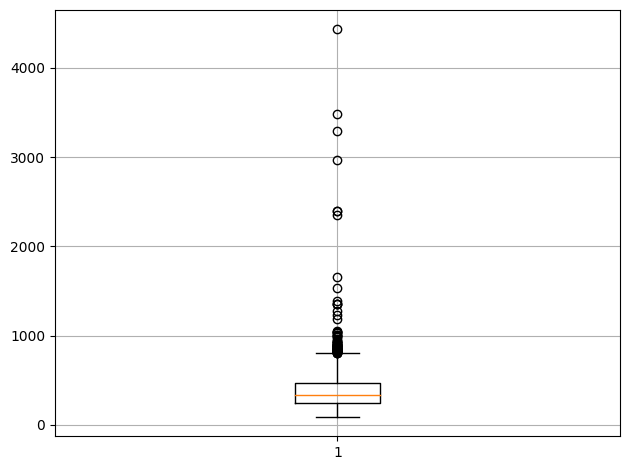

In [10]:
_ = plt.boxplot(word_counts.values)
plt.grid(True)
save_fig(f"{document_name}_words_box_plot")
plt.show()


# NB :
# La plupart des reviews ont entre 250 et 475 mots

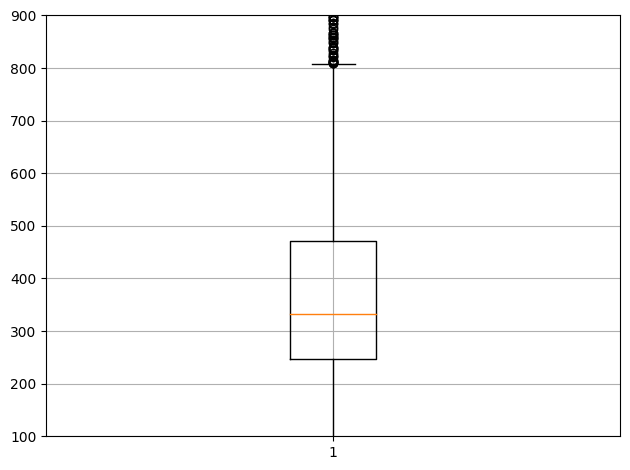

In [11]:
_ = plt.boxplot(word_counts.values)
plt.ylim(100, 900)
plt.grid(True)
save_fig(f"{document_name}_words_box_plot_zoomed")
plt.show()

## <span style='color:green; font-weight: bold;'>Nettoyage des données textuelles</span>

On enchaîne dans la fonction *data_preprocessing* les méthodes de nettoyage classiques vues précédemment.

* suppression des tag HTML
* conservation des mots uniquement
* passage en minuscule
* *(tokenization)*
* lemmatisation
* *(réassemblage des reviews)*

In [12]:
from core.preprocessing import Corpus

[nltk_data] Downloading package punkt to /home/khaldi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/khaldi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/khaldi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/khaldi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
cp = Corpus()
df_bbc = cp.process_documents(df_bbc)

In [14]:
df_bbc.head()

text  label
0  england coach face rap row england coach andy ...  sport
1  moody join england lewis moody flown dublin jo...  sport
2  ferguson fear milan cutting edge manchester un...  sport
3  henry tipped fifa award fifa president sepp bl...  sport
4  arnesen denies rift santini tottenham sporting...  sport

## <span style='color:green; font-weight: bold;'>Représentation vectorielle de données textuelles</span>

Dans cette partie, nous souhaitons représenter notre corpus de documents en matrice document-terme $\mathbf{X}$ de taille $N\times V$, $N$ étant le nombre de documents et $V$ le nombre total de mots présents dans le vocabulaire. Exemple avec $N=2$ et $V=9$ :
<img src="https://drive.google.com/uc?id=1jdz0lyVCH-7ZfxC5dpj_34f34rBWKs52" width=700>

### 1_ère approche: Bag-Of-Words (BOW)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(min_df=10)
X_docs_bow = bow_vectorizer.fit_transform(df_bbc['text'])
print('X_docs_bow shape: ', X_docs_bow.shape)

# NB:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

X_docs_bow shape:  (2225, 5167)


In [16]:
from numpy import count_nonzero

nb_nonZero = count_nonzero(X_docs_bow.todense())
my_size = float(X_docs_bow.todense().size)
print("Nombre d'éléments non nuls : ", nb_nonZero)
print("Nombre d'éléments : ", my_size)
print("Sparsité : ", 1-(nb_nonZero/my_size))

# NB:
# On a une matrice très sparse!

Nombre d'éléments non nuls :  290076
Nombre d'éléments :  11496575.0
Sparsité :  0.9747684853967378


### 2_ème approche: Pondération matrice *documents x termes* par TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5, # ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5)
    min_df=5,   # ignoring terms that are not present in at least 5 documents (set by min_df=5)
    stop_words="english",
)
t0 = time()
X_docs_tfidf = tfidf_vectorizer.fit_transform(df_bbc['text'])
print('X_docs_bow shape: ', X_docs_tfidf.shape)
print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_docs_tfidf.shape[0]}, n_features: {X_docs_tfidf.shape[1]}")

X_docs_bow shape:  (2225, 8108)
vectorization done in 0.400 s
n_samples: 2225, n_features: 8108


In [18]:
from numpy import count_nonzero

nb_nonZero = count_nonzero(X_docs_tfidf.todense())
my_size = float(X_docs_tfidf.todense().size)
print("Nombre d'éléments non nuls : ", nb_nonZero)
print("Nombre d'éléments : ", my_size)
print("Sparsité : ", 1-(nb_nonZero/my_size))

# NB:
# On a une matrice très sparse!

Nombre d'éléments non nuls :  274668
Nombre d'éléments :  18040300.0
Sparsité :  0.9847747543000948


### 3_ème approche: Word embedding

In [15]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [16]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

#### <span style='color:#3390FF; font-weight: bold;'>Word2Vec representation of words</span>

In [17]:
# from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec

Exécuter les sections suivantes si vous n'avez pas encore chargé et sauvegardé les vectors dans le model dédié

In [18]:
from globals import embeddings_path
# 2nd alternative
word2vec_file = embeddings_path
# we could load keyed vector by specifying that there is no header (dim shape) on top of file.
words_vectors_from_text = KeyedVectors.load_word2vec_format(word2vec_file, binary=False, no_header=True)

# 1st way
# load keyed vector build by own
# word2vec_file = f'{datasets_path}/../glove_model2.txt'
# word2vec_trained_model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)


# 3rd alt: only if we store data on gensim site_package folder
# words_vectors_from_text = KeyedVectors.load_word2vec_format(datapath('glove.840B.300d.txt'), binary=False, no_header=True)

INFO - 09:35:30: loading projection weights from /home/khaldi/glove.840B.300d.txt
WARNING - 09:36:20: duplicate word '����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������' in word2vec file, ignoring all but first
INFO - 09:40:06: KeyedVectors lifecycle event {'msg': 'loaded (2196017, 300) matrix of type float32 from /home/khaldi/glove.840B.300d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-05-23T09:40:06.899275', 'gensim': '4.3.1', 'python': '3.10.7 (main, Mar 10 2023, 10:47:39) [GCC 12.2.0]', 'platform': 'Linux-5.19.0-42-generic-x86_64-with-glibc2.36', 'event': 'load_word2vec_format'}


In [20]:
# sauvegarder le model pour une reproductibilité
# words_vectors_from_text.save('word2vec.wordvectors')

In [21]:
# charger les vecteurs depuis la projection mémoire, partagée par les processus
# words_vectors_from_mapping = KeyedVectors.load('word2vec.wordvectors', mmap='r')
# print(words_vectors_from_mapping)

In [22]:
# Finding similar words
# The most_similar() function finds the cosine similarity of the given word with 
# other words using the word2Vec representations of each word
# result = words_vectors_from_mapping.most_similar('king', topn=5)
# result

In [23]:
# Calculons: (king - man) + woman = ?
#result = words_vectors_from_mapping.most_similar(
#    positive=['woman', 'king'],
#    negative=['man'],
#    topn=1
#)
#result

In [24]:
# voir la taille d'un vecteur de mot
# words_vectors_from_mapping['hello'].shape
# model['hello']

In [25]:
#'hello' in words_vectors_from_mapping.key_to_index.keys()

In [26]:
#computer_vector = words_vectors_from_mapping['computer']  # Get numpy vector of a word
#computer_vector

Nous allons maintenant récupérer la représentation des mots du modèle

In [27]:
# import sys
# sys.path.insert(0,"..")

In [28]:
from core.word_embedding import Word2VecVectorizer

# Set a word2vec vectorizer
vectorizer = Word2VecVectorizer(model=words_vectors_from_text)
# Get the sentence embeddings for the train dataset
X_w2v = vectorizer.fit_transform(df_bbc['text'])
print('X_w2v shape: ', X_w2v.shape)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2225
X_w2v shape:  (2225, 300)


#### <span style='color:#3390FF; font-weight: bold;'>GloVe representation of words</span>

Exécuter les sections suivantes si vous n'avez pas encore chargé et sauvegardé les vectors dans le model dédié

###### load glove vector into gensim object

In [29]:
from globals import embeddings_path

glove_file = embeddings_path

# we could load keyed vector by specifying that
# there is no header (dim shape) on top of file.

glove_words_vectors_from_text = KeyedVectors.load_word2vec_format(
    fname=glove_file,
    binary=False,
    no_header=True
)

# sauvegarder les vecteurs de l'objet gensim dans un fichier
# ---
# glove_words_vectors_from_text.save('glove.wordvectors')

# load
# ---
#glove_words_vectors_from_mapping = KeyedVectors.load('glove.wordvectors', mmap='r')
# print(glove_words_vectors_from_mapping)

INFO - 09:40:44: loading projection weights from /home/khaldi/glove.840B.300d.txt
WARNING - 09:41:58: duplicate word '����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������' in word2vec file, ignoring all but first
INFO - 09:46:05: KeyedVectors lifecycle event {'msg': 'loaded (2196017, 300) matrix of type float32 from /home/khaldi/glove.840B.300d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-05-23T09:46:05.825042', 'gensim': '4.3.1', 'python': '3.10.7 (main, Mar 10 2023, 10:47:39) [GCC 12.2.0]', 'platform': 'Linux-5.19.0-42-generic-x86_64-with-glibc2.36', 'event': 'load_word2vec_format'}


###### load gensim object from file

In [30]:
# updated/new way to do that

# glove_file = f'{datasets_path}/../glove.840B.300d.txt'
# glove_trained_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

###### save glove object into output file

In [31]:
# deprecated way

#(_,_) = glove2word2vec(
#    glove_input_file=word2vec_file,
#    word2vec_output_file=tmp_file
#)

Nous allons maintenant récupérer la représentation des mots du modèle

In [32]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model=glove_words_vectors_from_text)
# Get the sentence embeddings for the train dataset
X_glove = vectorizer.fit_transform(df_bbc['text'])
print('X_glove shape: ', X_glove.shape)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2225
X_glove shape:  (2225, 300)


# <span style='color:green; font-weight: bold;'>Visualisation through Dimensionality Reduction</span>

In [39]:
from core.plot import points

In [40]:
topics = df_bbc['label'].unique()
color_mapping = {topic: i for i, topic in enumerate(topics)}
topic_colors = [color_mapping[topic] for topic in df_bbc['label']]

## Bac-Of-Words X-matrix
---

### Principal Component Analysis 

In [41]:
from sklearn.decomposition import PCA # ne supporte pas la sparcité

l' **ACP** ne supporte pas les matrices très sparces

In [42]:
# 
# >> pca = PCA(n_components=2)
# >> result = pca.fit_transform(X_docs_bow)

# Scatter plot de la projection
# pyplot.scatter(result[:, 0], result[:, 1])
# dico_terms_idx = result.vocabulary_
# for i, word in enumerate(words):
# 	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
# pyplot.show()

# NB:
# Il est difficile de tirer beaucoup de sens de ce graphique avec un 
# corpus aussi minuscule...

Nous allons trouver un autre alternative qui est la technique de dimensionnalité **LSA** connu sous le nom de **TruncatedSVD**

### LSA (aka TruncatedSVD)

In [43]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [44]:
# la svd fait une décomposition sans normalisation. 
# nous allons effectuer une normalisation pour optimiser les résultats
n_components = 5
lsa = make_pipeline(
    TruncatedSVD(
        n_components=n_components,
        n_iter=2500,
        random_state=123
    )
    ,
    Normalizer(copy=False)
)

t0 = time()
X_docs_bow_red_lsa = lsa.fit_transform(X_docs_bow)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 121.129 s
Explained variance of the SVD step: 12.9%


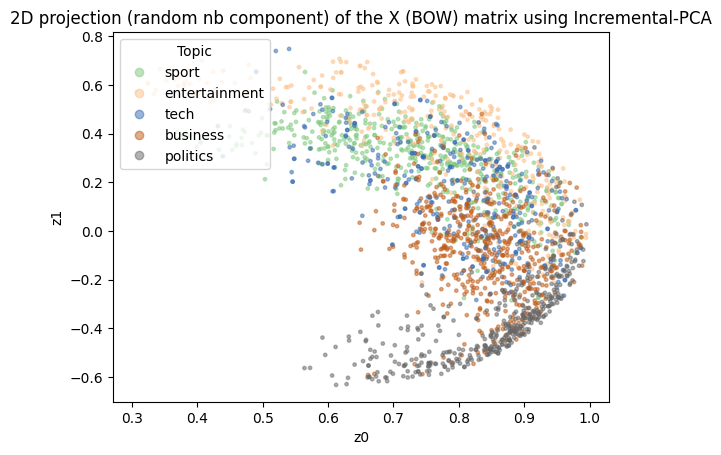

<Figure size 640x480 with 0 Axes>

In [45]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_lsa[:, nth_dims[0]],
    y=X_docs_bow_red_lsa[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    s=6,
    t='2D projection (random nb component) of the X (BOW) matrix using Incremental-PCA'
)
save_fig(f"{document_name}_bow_IPCA_2Dplot")

Nous allons tenter d'explorer un peu les résultats, en cherchant nombre d'axes factoriels, nous permettant de préserver un certains ```%centage``` de variance de nos données, dans un but purement représentative.

In [46]:
# la dimension fitté par le modèle
lsa2 = TruncatedSVD()
lsa2.fit(X_docs_bow)
cumsum2 = np.cumsum(lsa2.explained_variance_ratio_)
d = np.argmax(cumsum2 >= 0.95) + 1  # d equals 1
d

1

la matrice étant très sparce, il ne faut qu'1 seul dimension, on va essayer de confirmer ce résulat via le graphique en ```coude```


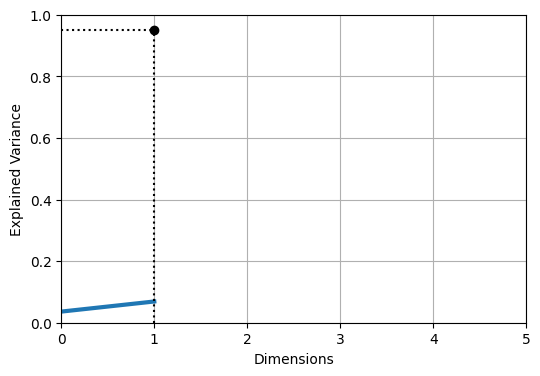

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum2, linewidth=3)
plt.axis([0, 5, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(10, 0.1), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

#### $\rightarrow$ vers une approche ICPA

Etant donné que l'on a une matrice très sparse, nous allons explorer une autre approche de PCA qui nous permettra de faire
 en même temps du PCA, de l'imputation. En d'autre terme, nous ferons une imputation à l'aide du PCA

### Incremental PCA

In [48]:
from sklearn.decomposition import IncrementalPCA

# choix arbitraire
n_components = 2
ipca = IncrementalPCA(
    n_components=n_components,
    batch_size=100
)

X_docs_bow_red_ipca = ipca.fit_transform(X_docs_bow)

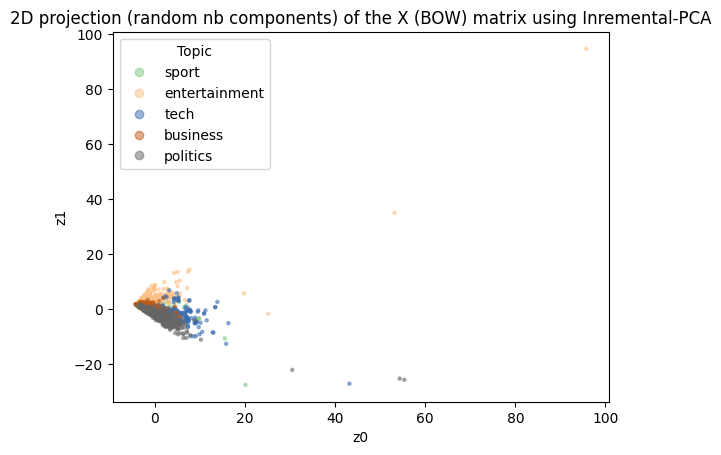

In [49]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_ipca[:, nth_dims[0]],
    y=X_docs_bow_red_ipca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    s=5,
    t='2D projection (random nb components) of the X (BOW) matrix using Inremental-PCA'
)

In [50]:
# nombre de composant principal fitté par le model 
inc_pca = IncrementalPCA()
inc_pca.fit(X_docs_bow)
inc_pca.n_components_

2225

In [51]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
inc_pca_ck = IncrementalPCA()
inc_pca_ck.fit(X_docs_bow)
inc_pca_ck_cumsum = np.cumsum(inc_pca_ck.explained_variance_ratio_)
inc_pca_ck_d = np.argmax(inc_pca_ck_cumsum >= 0.95) + 1
inc_pca_ck_d

1065

Essayons de confirmer notre intuition via la méthode ou le graphique du **coude** .

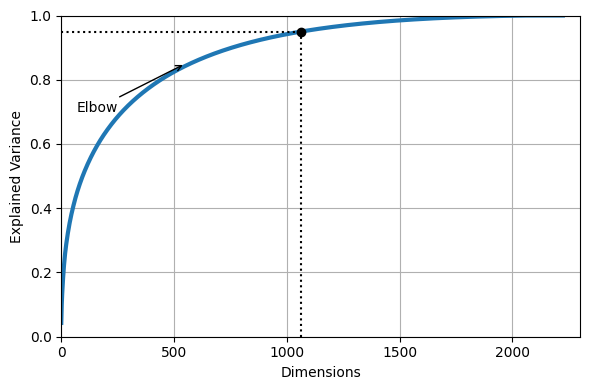

In [52]:
plt.figure(figsize=(6, 4))
plt.plot(inc_pca_ck_cumsum, linewidth=3)
plt.axis([0, 2300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([inc_pca_ck_d, inc_pca_ck_d], [0, 0.95], "k:")
plt.plot([0, inc_pca_ck_d], [0.95, 0.95], "k:")
plt.plot(inc_pca_ck_d, 0.95, "ko")
plt.annotate("Elbow", xy=(550, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("BOW_IPCA_explained_variance_plot")
plt.show()

In [53]:
# refaisons la projection
inc_pca_ck2 = IncrementalPCA(
    n_components=inc_pca_ck_d,
    batch_size=1500
)
X_docs_bow_red_inc_pca_ck = inc_pca_ck2.fit_transform(X_docs_bow)

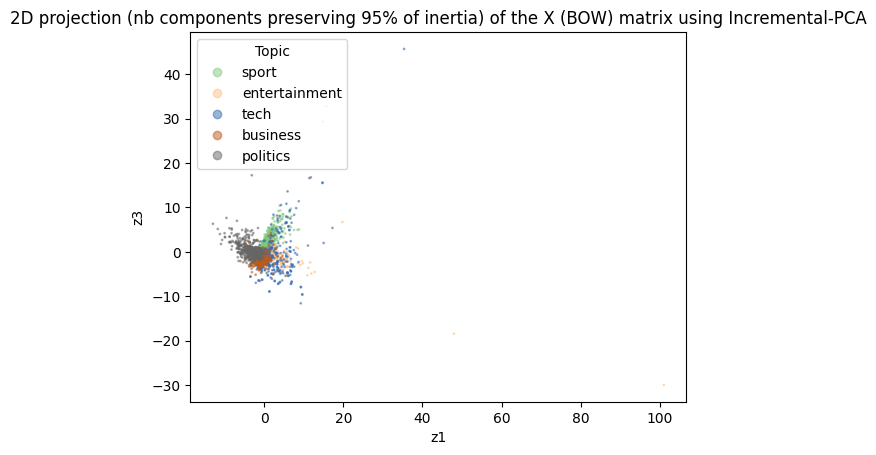

In [54]:
_, ax = plt.subplots()

nth_dims = (1, 3)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_inc_pca_ck[:, nth_dims[0]],
    y=X_docs_bow_red_inc_pca_ck[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (nb components preserving 95% of inertia) of the X (BOW) matrix using Incremental-PCA'
)

### Document embedding using UMAP

In [55]:
import umap
import umap.plot
# umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

/home/godwin/.cache/pypoetry/virtualenvs/text-clust-OuPGshOE-py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/godwin/.cache/pypoetry/virtualenvs/text-clust-OuPGshOE-py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hom

In [56]:
%%time
X_docs_bow_umap_embedding = umap.UMAP(
    n_components=2,
    metric='hellinger'
).fit(X_docs_bow)
X_docs_bow_umap_embedding.embedding_.shape

CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 1s


(2225, 2)

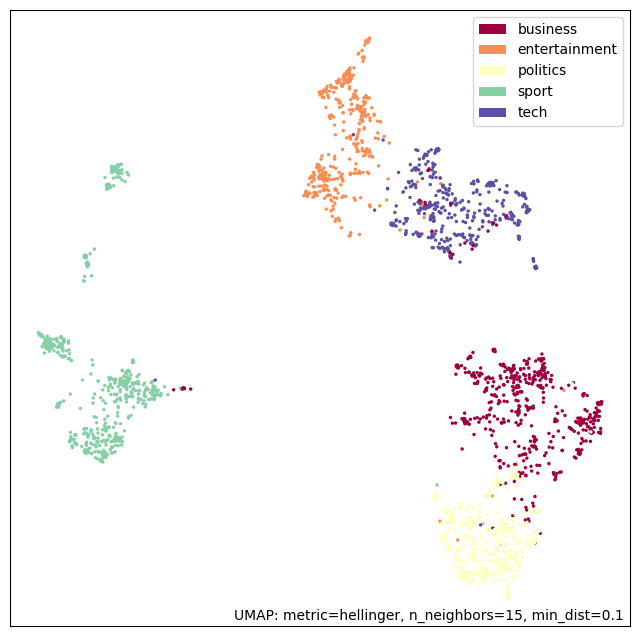

In [57]:
# For interactive plotting use
# f = umap.plot.interactive(embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(f)
f = umap.plot.points(X_docs_bow_umap_embedding, labels=df_bbc['label'])

#save_fig("bbc_BOW_UMAP_plot")

## TF-IDF X-matrix
---

In [58]:
#### La matrice reste sparce, et on ne peut pas appliquer le PCA

#### LSA (aka TruncatedSVD)

In [59]:
# la svd fait une décomposition sans normalisation. 
# nous allons effectuer une normalisation pour optimiser les résultats

n_components=1065  # after fitting
lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
t0 = time()
X_docs_tfidf_red_lsa = lsa.fit_transform(X_docs_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 27.156 s
Explained variance of the SVD step: 86.1%


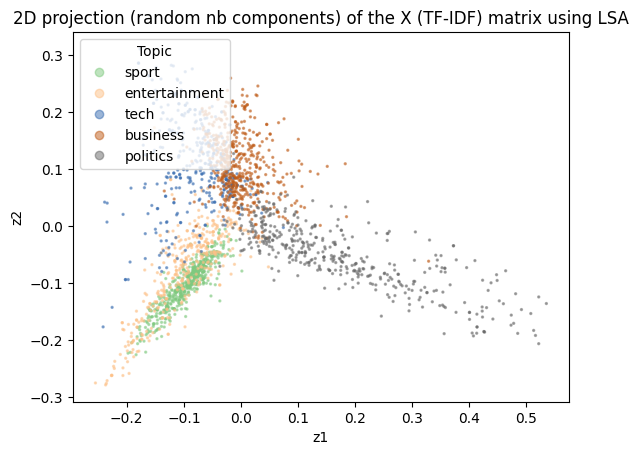

In [60]:
_, ax = plt.subplots()

nth_dims = (1, 2)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_lsa[:, nth_dims[0]],
    y=X_docs_tfidf_red_lsa[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=2,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (TF-IDF) matrix using LSA'
)

Nous allons tenter d'explorer un peu les résultats, en cherchant nombre d'axes factoriels, nous permettant de préserver le plus de variance de nos données, dans un but purement représentative.

In [61]:
# la dimension fitté par le modèle
lsa2_tfidf = TruncatedSVD()
lsa2_tfidf.fit(X_docs_tfidf)
cumsum2_tfidf = np.cumsum(lsa2_tfidf.explained_variance_ratio_)
d = np.argmax(cumsum2_tfidf >= 0.95) + 1  # d equals XXX
d

1

la matrice étant très sparce, il ne faut qu'1 seul dimension, on va essayer de confirmer ce résulat via le graphique en ```coude```


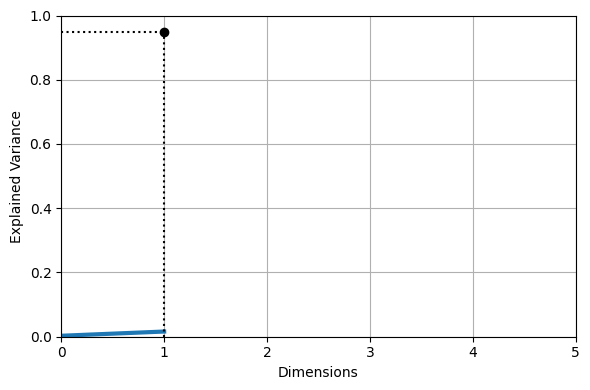

In [62]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum2_tfidf, linewidth=3)
plt.axis([0, 5, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(10, 0.1), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig(f"{document_name}_TFIDF_LSA_explained_variance_plot")
plt.show()

#### $\rightarrow$ vers une approche ICPAholoviews

Etant donné que l'on a une matrice très sparse, nous allons explorer une autre approche de PCA qui nous
permettra de faire en même temps du PCA, de l'imputation. En d'autre terme, nous ferons une imputation à l'aide du PCA

#### Incremental PCA

In [63]:
from sklearn.decomposition import IncrementalPCA


# choix arbitraire
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=100)
X_docs_tfidf_red_ipca = ipca.fit_transform(X_docs_tfidf)

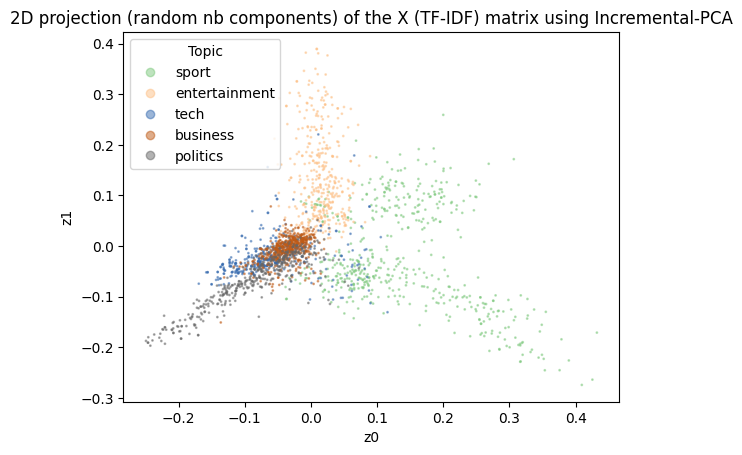

In [64]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_ipca[:, nth_dims[0]],
    y=X_docs_tfidf_red_ipca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=1,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (TF-IDF) matrix using Incremental-PCA'
)

In [65]:
# nombre de composant principal fitté par le model 
inc_pca_tfidf = IncrementalPCA()
inc_pca_tfidf.fit(X_docs_tfidf)
inc_pca_tfidf.n_components_

2225

In [66]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
inc_pca_tfidf_ck = IncrementalPCA()
inc_pca_tfidf_ck.fit(X_docs_tfidf)
inc_pca_tfidf_ck_cumsum = np.cumsum(inc_pca_ck.explained_variance_ratio_)
inc_pca_tfidf_ck_d = np.argmax(inc_pca_ck_cumsum >= 0.95) + 1
inc_pca_tfidf_ck_d

1065

Confirmons notre intuition à partir d'un graphique 

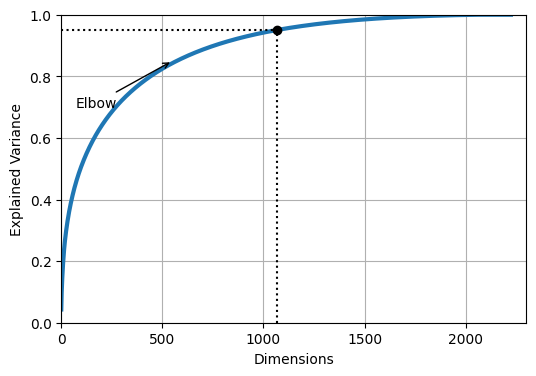

In [67]:
plt.figure(figsize=(6, 4))
plt.plot(inc_pca_tfidf_ck_cumsum, linewidth=3)
plt.axis([0, 2300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([inc_pca_tfidf_ck_d, inc_pca_tfidf_ck_d], [0, 0.95], "k:")
plt.plot([0, inc_pca_tfidf_ck_d], [0.95, 0.95], "k:")
plt.plot(inc_pca_tfidf_ck_d, 0.95, "ko")
plt.annotate("Elbow", xy=(550, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [68]:
X_docs_tfidf.shape

(2225, 8108)

In [69]:
# refaisons la projection
inc_pca_tfidf_new = IncrementalPCA(
    n_components=inc_pca_ck_d,
    batch_size=1500
)
X_docs_tfidf_red_inc_pca_new = inc_pca_tfidf_new.fit_transform(X_docs_tfidf)
print('X_docs_tfidf_red_inc_pca_new: ', X_docs_tfidf_red_inc_pca_new.shape)

X_docs_tfidf_red_inc_pca_new:  (2225, 1065)


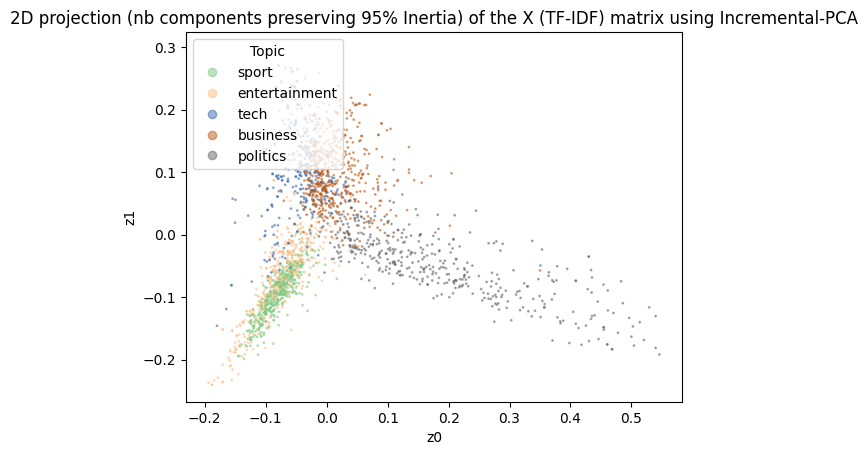

In [70]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_inc_pca_new[:, nth_dims[0]],
    y=X_docs_tfidf_red_inc_pca_new[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=1,
    target_idx_colors=topic_colors,
    t='2D projection (nb components preserving 95% Inertia) of the X (TF-IDF) matrix using Incremental-PCA'
)

### Document embedding using UMAP

In [71]:
%%time
X_docs_tfidf_umap_embedding = umap.UMAP(metric='hellinger').fit(X_docs_tfidf)


CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 55.4 s


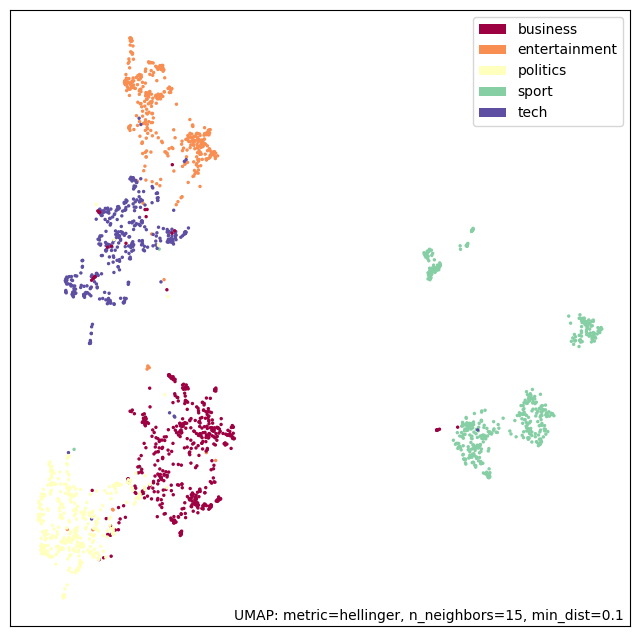

In [72]:
# For interactive plotting use
# fig = umap.plot.interactive(tfidf_embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(fig)
_ = umap.plot.points(X_docs_tfidf_umap_embedding, labels=df_bbc['label'])

## <span style='color:#3390FF; font-weight: bold;'>Word2Vec representation of words</span>
---

### Principal Component Analysis (PCA)

In [73]:
# choix arbitraire
n_components = 2
pca = PCA(n_components=n_components)
X_w2v_pca = pca.fit_transform(X_w2v)

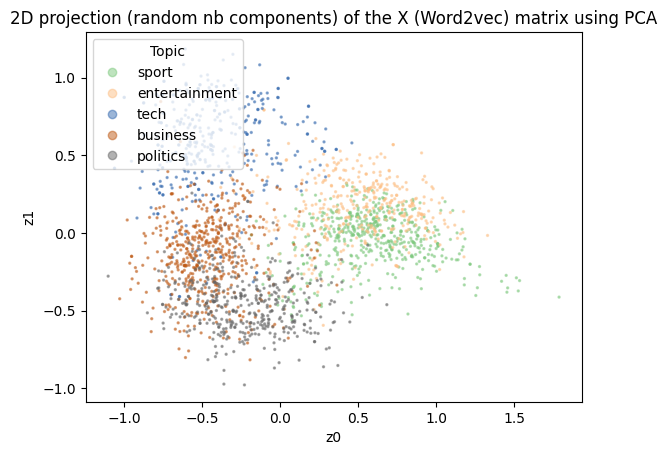

In [74]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_w2v_pca[:, nth_dims[0]],
    y=X_w2v_pca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=2,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2vec) matrix using PCA'
)

In [75]:
# nombre de composant principal fitté par le model 
pca_w2v2 = PCA()
pca_w2v2.fit(X_w2v)
pca_w2v2.n_components_

300

On peut constater que les données la projection des données ne réduit pas la dimension de ces dernier. Celà indique que les données sont bien représenter dans l'espace vectoriel.

Cela dit, voyons quel nombre de dimension serait le plus adapter pour grader ```95% d'intertie``` de notre jeu de données

In [76]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
pca_w2v2_ck = PCA()
pca_w2v2_ck.fit(X_w2v)
pca_w2v2_ck_cumsum = np.cumsum(pca_w2v2_ck.explained_variance_ratio_)
pca_w2v2_ck_d = np.argmax(pca_w2v2_ck_cumsum >= 0.95) + 1
pca_w2v2_ck_d # d=130


130

### Manifold learning

#### $\rightarrow$ vers une approche t-SNE

Nous pouvons tracer les embeddings dans un **espace bidimensionnel** qui peut nous montrer comment les mots sont liés.
Les mots les plus **similaires** devraient être représentés **en groupes**, tandis que les mots non apparentés apparaîtront à une grande distance. <br><br>

Cela nécessite une technique de **réduction de dimension** supplémentaire pour ramener les dimensions à 2 ou 3.
La technique de réduction la plus populaire est elle-même une méthode d'embedding: **t-Distributed Stochastic Neighbor Embedding (t-SNE)**.

t-SNE est une technique de réduction de la dimensionnalité qui convient parfaitement à la visualisation d'ensembles de données de grande dimension.
Il s'agit d'une technique d'apprentissage de type **manifold**, ce qui signifie qu'il tente de faire **correspondre des données de haute dimension à un manifold de plus faible dimension**, créant ainsi un embedding qui tente de maintenir la structure locale des données. Elle est presque exclusivement utilisée pour la visualisation car la sortie est stochastique et elle ne prend pas en charge la transformation de nouvelles données.

In [77]:
from sklearn.manifold import TSNE                   # final reduction

#### t-Distributed Sémantic Neighbord Embedding (t-SNE)

In [78]:
tsne = TSNE(
    perplexity=40,
    n_components=2,
    init='pca',
    n_iter=2500,
    random_state=123
)
z = tsne.fit_transform(X_w2v)

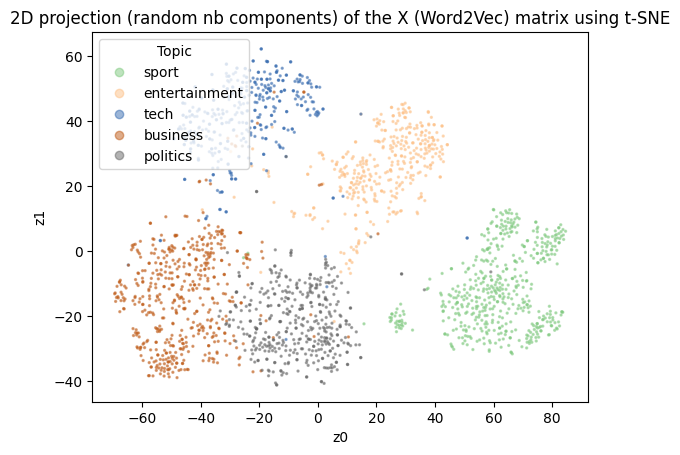

In [79]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=z[:, nth_dims[0]],
    y=z[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    s=2,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2Vec) matrix using t-SNE'
)

### Locally Linear Embedding (LLE)

In [80]:
n_neighbors = 100  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [81]:
from sklearn import manifold

In [82]:
lle_params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "dense",
    "random_state": 123,
}

lle_standard = manifold.LocallyLinearEmbedding(method="standard", **lle_params)
X_w2v_standard_unrolled = lle_standard.fit_transform(X_w2v)

lle_ltsa = manifold.LocallyLinearEmbedding(method="ltsa", **lle_params)
X_w2v_ltsa_unrolled = lle_ltsa.fit_transform(X_w2v)

lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **lle_params)
X_w2v_hessian_unrolled = lle_hessian.fit_transform(X_w2v)

lle_mod = manifold.LocallyLinearEmbedding(method="modified", **lle_params)
X_w2v_mod_unrolled = lle_mod.fit_transform(X_w2v)

In [83]:
#lle = LocallyLinearEmbedding(n_components=5, n_neighbors=100, random_state=42)
#X_w2v_unrolled = lle.fit_transform(X_w2v)


lle_methods = [
    ("Standard locally linear embedding", X_w2v_standard_unrolled),
    ("Local tangent space alignment", X_w2v_ltsa_unrolled),
    ("Hessian eigenmap", X_w2v_hessian_unrolled),
    ("Modified locally linear embedding", X_w2v_mod_unrolled),
]

classes = [
    'sport',
    'entertainment',
    'tech',
    'business',
    'politics'
    ]

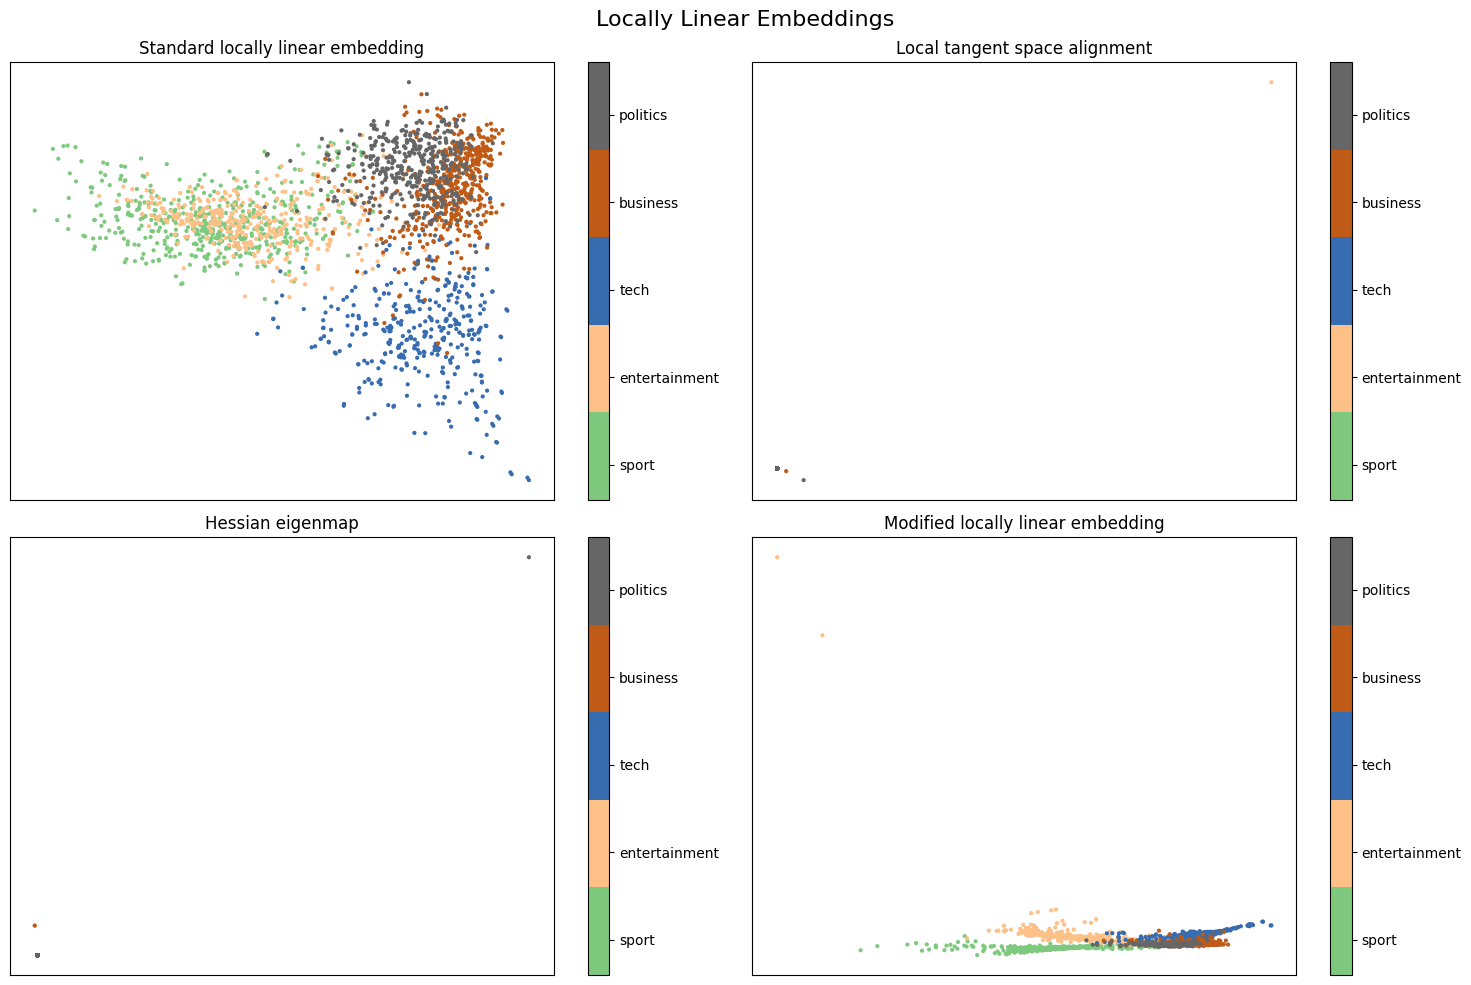

In [84]:
#fig, ax = plt.subplots()
nth_dims=(0, 1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Locally Linear Embeddings", size=16)

for ax, method in zip(axs.flat, lle_methods):
    name, X_red = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=topic_colors,
        cmap='Accent',
        s=4,
        alpha=1
    )
    #handles, labels = scatter.legend_elements()
    #labels = target_names
    #ax.legend(handles, labels, loc="upper left", title="Topic")
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
    cbar.set_ticks(np.arange(5))
    cbar.set_ticklabels(classes, size=10)

    ax.set_title(name, size=12)
save_fig("bbc_W2V_LLEs_plot")
plt.show()
#ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using t-SNE')

### Isomap Embedding

In [85]:
isomap = manifold.Isomap(
    n_neighbors=n_neighbors,
    n_components=n_components,
    p=1)
X_w2v_isomap = isomap.fit_transform(X_w2v)

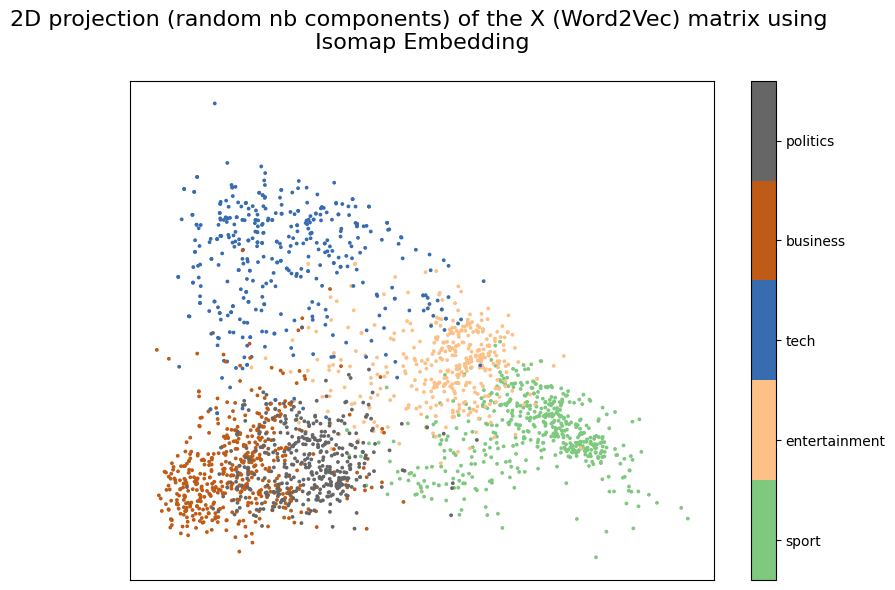

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    x=X_w2v_isomap[:, 0],
    y=X_w2v_isomap[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)
#handles, labels = scatter.legend_elements()
#labels = target_names
#ax.legend(handles, labels, loc="upper left", title="Topic")
plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Isomap Embedding \n', size=16)
save_fig("bbc_W2V_ISOMAP_plot")
plt.show()

### Multidimensional scaling

In [87]:
md_scaling = manifold.MDS(
    n_components=n_components,
    max_iter=2500,
    n_init=5,
    random_state=123,
    normalized_stress='auto',
)
X_w2v_scaling = md_scaling.fit_transform(X_w2v)


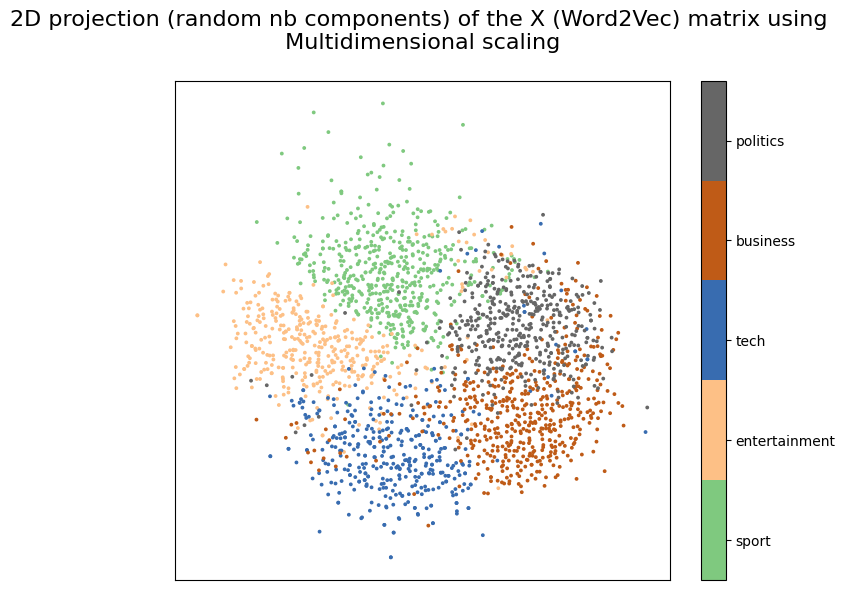

In [88]:
fig, ax = plt.subplots(figsize=(7, 6))

scatter = ax.scatter(
    x=X_w2v_scaling[:, 0],
    y=X_w2v_scaling[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)
plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Multidimensional scaling \n', size=16)
save_fig("bbc_W2V_MultiSCALING_plot")
plt.show()

### Spectral embedding for non-linear dimensionality reduction

In [89]:
spectral4w2v = manifold.SpectralEmbedding(
    n_components=n_components,
    n_neighbors=n_neighbors,
)
X_w2v_spectral = spectral4w2v.fit_transform(X_w2v)


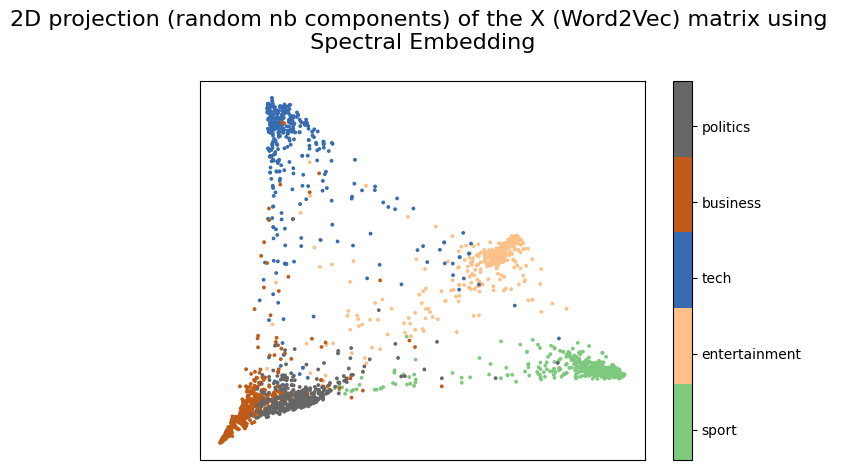

In [90]:
fig, ax = plt.subplots()

scatter = ax.scatter(
    x=X_w2v_spectral[:, 0],
    y=X_w2v_spectral[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)
#handles, labels = scatter.legend_elements()
#labels = target_names
#ax.legend(handles, labels, loc="upper left", title="Topic")
plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using \n Spectral Embedding \n ', size=16)
save_fig("bbc_W2V_SpectralEMBEDDING_plot")
plt.show()

### T-distributed Stochastic Neighbor Embedding

In [91]:
t_sne4w2v = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=2500,
    random_state=123,
)
X_w2v_tsne = t_sne4w2v.fit_transform(X_w2v)

t_sne4w2v_pca = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="pca",
    n_iter=2500,
    random_state=123,
)
X_w2v_tsne_pca = t_sne4w2v_pca.fit_transform(X_w2v)

In [92]:
tsne_inits = [
    ("t-sne init random", X_w2v_tsne),
    ("t-sne init pca", X_w2v_tsne_pca)
]

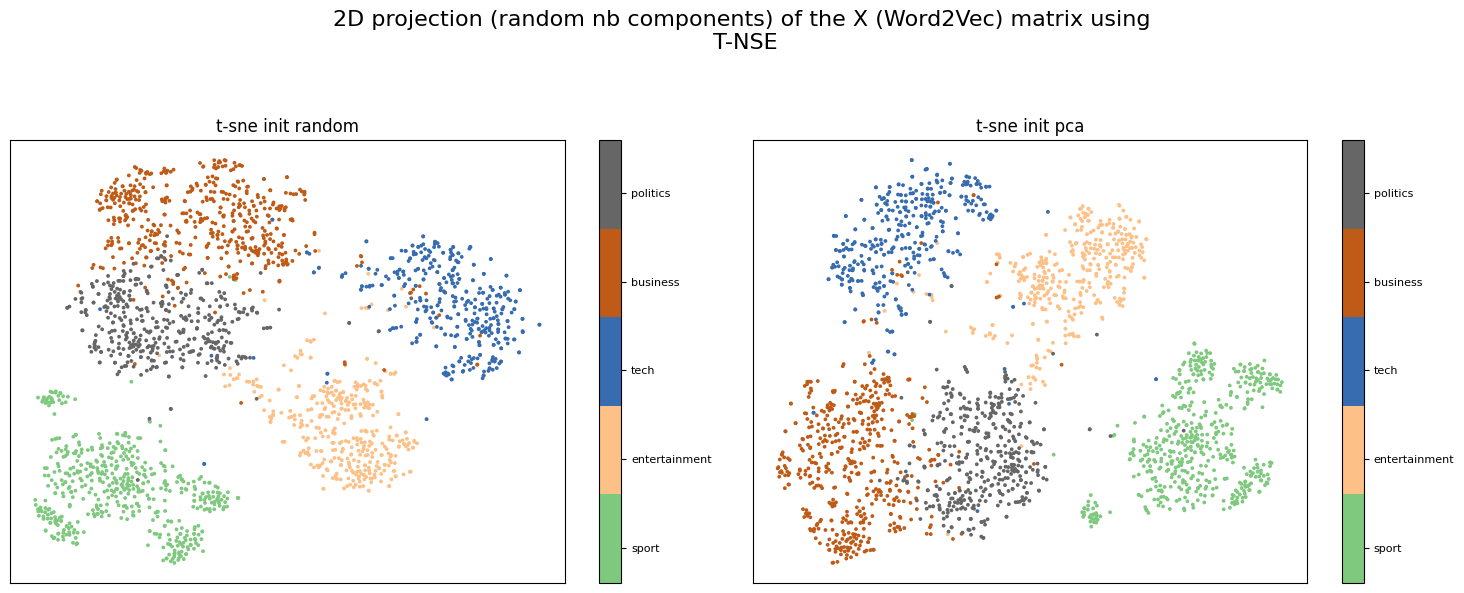

In [93]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle("2D projection (random nb components) of the X (Word2Vec) matrix using \n T-NSE \n\n", size=16)

for ax, init in zip(axs.flat, tsne_inits):
    name, X_red = init
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=topic_colors,
        cmap='Accent',
        s=3,
        alpha=1
    )
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
    cbar.set_ticks(np.arange(5))
    cbar.set_ticklabels(classes, size=8)
    ax.set_title(name, size=12)
save_fig(f"{document_name}_W2V_TSNE_2Dplot")
plt.show()

On a une bonne représentation des données dans le sens où l'on peut identifier les groupe ou clustering

## <span style='color:#3390FF; font-weight: bold;'>GloVe representation of words</span>
---

### Principal Component Analysis 

In [94]:
import matplotlib.pyplot as plt
# choix arbitraire
n_components = 2
pca = PCA(n_components=n_components)
X_glove_pca = pca.fit_transform(X_glove)

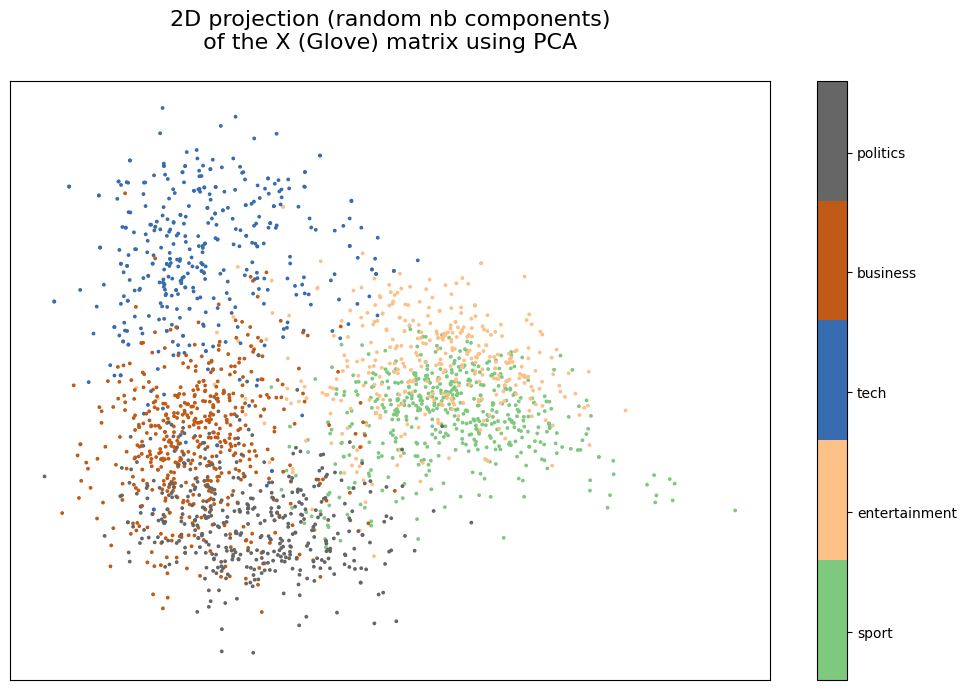

In [95]:
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    x=X_glove_pca[:, 0],
    y=X_glove_pca[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)

plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components)\n of the X (Glove) matrix using PCA \n ', size=16)
save_fig(f"{document_name}_GLOVE_PCA_2Dplot")
plt.show()

#### $\rightarrow$ vers une approche T-SNE

In [96]:
t_sne4glove = TSNE(
    perplexity=40,
    n_components=2,
    init='pca',
    n_iter=2500,
    random_state=123
)
reduced_glove_tsne = t_sne4glove.fit_transform(X_glove)

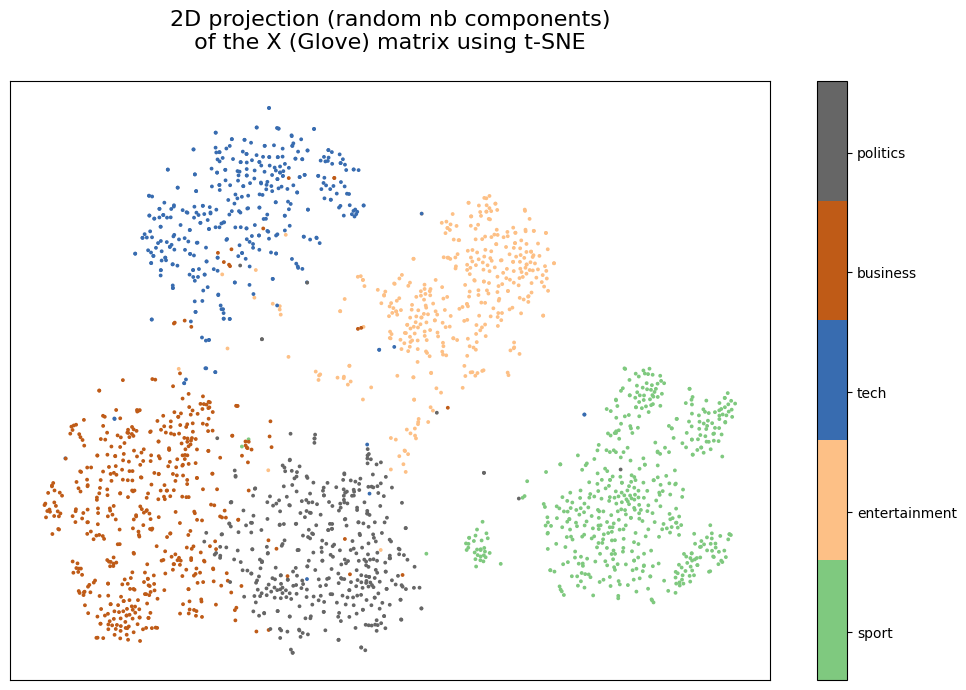

In [97]:
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    x=reduced_glove_tsne[:, 0],
    y=reduced_glove_tsne[:, 1],
    c=topic_colors,
    cmap='Accent',
    s=3,
    alpha=1
)

plt.setp(ax, xticks=[], yticks=[])
cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes, size=10)
ax.set_title('2D projection (random nb components)\n of the X (Glove) matrix using t-SNE \n', size=16)
save_fig(f"{document_name}_GLOVE_TSNE_2Dplot")
plt.show()

# <span style='color:green; font-weight: bold;'>Preparing Data frame For machine learning</span>

#### $\rightarrow$ dataframe
- Transformons $\mathbf{X}$ en dataframe où chaque ligne correspond à un document (ID en index) et chaque colonne correspond à un mot du vocabulaire (les mots en colonne).

In [98]:
# df_words = pd.DataFrame(
#    data = X,
#    columns = vocab,
#    index = df_text.index
#)
# df_words

# X_docs_bow => bow original (sparce) => not pca
# X_docs_bow_red_lsa => lsa reducted
# X_docs_bow_red_ipca => ipca reducted

# X_docs_tfidf => ifidf original (sparce) => not pca
# X_docs_tfidf_lsa => lsa reduced
# X_docs_tfidf_red_ipca => ipca reduced

In [99]:
df_words_bow = pd.DataFrame(
    data = X_docs_bow.toarray(), 
    index = df_bbc.index, 
    columns = bow_vectorizer.get_feature_names_out()
)
df_words_bow.head()


000  000m  05  10  100  100m  102  104  10bn  10m  ...  youngster  youth   
0    1     0   0   0    0     0    0    0     0    0  ...          0      0  \
1    0     0   0   2    0     0    0    0     0    0  ...          0      0   
2    0     0   0   0    0     0    0    0     0    0  ...          0      0   
3    0     0   0   0    0     0    0    0     0    0  ...          1      0   
4    0     0   0   0    0     0    0    0     0    0  ...          0      0   

   yuan  yugansk  yuganskneftegas  yukos  zealand  zero  zone  zurich  
0     0        0                0      0        0     0     0       0  
1     0        0                0      0        1     0     0       0  
2     0        0                0      0        0     0     0       0  
3     0        0                0      0        0     0     0       1  
4     0        0                0      0        0     0     0       0  

[5 rows x 5167 columns]

In [100]:
df_words_tfidf = pd.DataFrame(
    data = X_docs_tfidf.toarray(),
    index = df_bbc.index,
    columns = tfidf_vectorizer.get_feature_names_out()
)
df_words_tfidf.head()


00       000  000m   01   03   04   05   06   07        10  ...  zach   
0  0.0  0.036688   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   0.0  \
1  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.066171  ...   0.0   
2  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   0.0   
3  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   0.0   
4  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   0.0   

    zealand  zeppelin  zero  zhang  zimbabwe  zombie  zone  zoom    zurich  
0  0.000000       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000  
1  0.061951       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000  
2  0.000000       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000  
3  0.000000       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.115875  
4  0.000000       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000  

[5 rows x 8108 columns]

#### $\rightarrow$ dataframe(words-label)

- Jointure entre le dataframe obtenu et la colonne [topic].
- Faire le même nuage de points, cette fois-ci en coloriant les points par rapport à la thématique (colonne TOPIC).

In [101]:
df_bow = df_words_bow.merge(
    right = df_bbc.label,
    left_index = True,
    right_index=True
)
df_bow.head()

000  000m  05  10  100  100m  102  104  10bn  10m  ...  youth  yuan   
0    1     0   0   0    0     0    0    0     0    0  ...      0     0  \
1    0     0   0   2    0     0    0    0     0    0  ...      0     0   
2    0     0   0   0    0     0    0    0     0    0  ...      0     0   
3    0     0   0   0    0     0    0    0     0    0  ...      0     0   
4    0     0   0   0    0     0    0    0     0    0  ...      0     0   

   yugansk  yuganskneftegas  yukos  zealand  zero  zone  zurich  label_y  
0        0                0      0        0     0     0       0    sport  
1        0                0      0        1     0     0       0    sport  
2        0                0      0        0     0     0       0    sport  
3        0                0      0        0     0     0       1    sport  
4        0                0      0        0     0     0       0    sport  

[5 rows x 5168 columns]

In [102]:
df_tfidf = df_words_tfidf.merge(
    right = df_bbc.label,
    left_index = True,
    right_index=True
)
df_tfidf.head()

00       000  000m   01   03   04   05   06   07        10  ...   zealand   
0  0.0  0.036688   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.000000  \
1  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.066171  ...  0.061951   
2  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.000000   
3  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.000000   
4  0.0  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...  0.000000   

   zeppelin  zero  zhang  zimbabwe  zombie  zone  zoom    zurich  label_y  
0       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000    sport  
1       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000    sport  
2       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000    sport  
3       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.115875    sport  
4       0.0   0.0    0.0       0.0     0.0   0.0   0.0  0.000000    sport  

[5 rows x 8109 columns]

## Quantifying the quality of clustering results

- homogeneity, which quantifies how much clusters contain only members of a single class;

- completeness, which quantifies how much members of a given class are assigned to the same clusters;

- V-measure, the harmonic mean of completeness and homogeneity;

- Rand-Index, which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment;

- Adjusted Rand-Index, a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation.



In [103]:
from collections import defaultdict
from sklearn import metrics
from time import time
from time import sleep

evaluations = []
evaluations_std = []

scores = defaultdict(list)

labels = topic_colors

def evaluate(labels_, X, name=None, metric=None, dset=None, train_times=None):
    scores["Homogeneity"].append(metrics.homogeneity_score(labels, labels_))
    scores["Completeness"].append(metrics.completeness_score(labels, labels_))
    scores["V-measure"].append(metrics.v_measure_score(labels, labels_))
    scores["Rand index"].append(
        metrics.rand_score(labels, labels_)
    )
    scores["ARI"].append(
        metrics.adjusted_rand_score(labels, labels_)
    )
    scores["MI"].append(
        metrics.mutual_info_score(labels, labels_)
    )
    scores["NMI"].append(
        metrics.normalized_mutual_info_score(labels, labels_)
    )
    scores["Silhouette Coefficient"].append(
        metrics.silhouette_score(X, labels_, sample_size=2000)
    )

    evaluation = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    evaluation_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

def fit_and_evaluate(km, X, name=None, metric=None, dset=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    for seed in range(n_runs):

        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Rand index"].append(
            metrics.rand_score(labels, km.labels_)
        )
        scores["ARI"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["MI"].append(
            metrics.mutual_info_score(labels, km.labels_)
        )
        scores["NMI"].append(
            metrics.normalized_mutual_info_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")

    evaluation = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

# <span style='color:green; font-weight: bold;'> Approche Tandem : Réduction de la dimension à laquelle est ajoutée ensuite une tâche de clustering </span>
---

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

import umap
import hdbscan # > sudo apt-get install python3.10-dev before

import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

##  <span style='color:#F9A861; font-weight: bold;'> DONNEES ORIGINALES </span>

In [105]:
X_w2v.shape # wo labels

(2225, 300)

In [106]:
%%time
w2v_umap_emb_irnd = umap.UMAP(
    metric='cosine',
    random_state=123,
    init='random'
).fit_transform(X_w2v)

w2v_umap_emb_ispt = umap.UMAP(
    metric='cosine',
    random_state=123,
    init='spectral'
).fit_transform(X_w2v)

CPU times: user 16.1 s, sys: 1.08 s, total: 17.2 s
Wall time: 21.7 s


In [107]:
print(w2v_umap_emb_irnd.shape)
print(w2v_umap_emb_ispt.shape)

(2225, 2)
(2225, 2)


In [108]:
umap_methods = [
    ("UMAP metric=cosine, init=random", w2v_umap_emb_irnd),
    ("UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt)
]

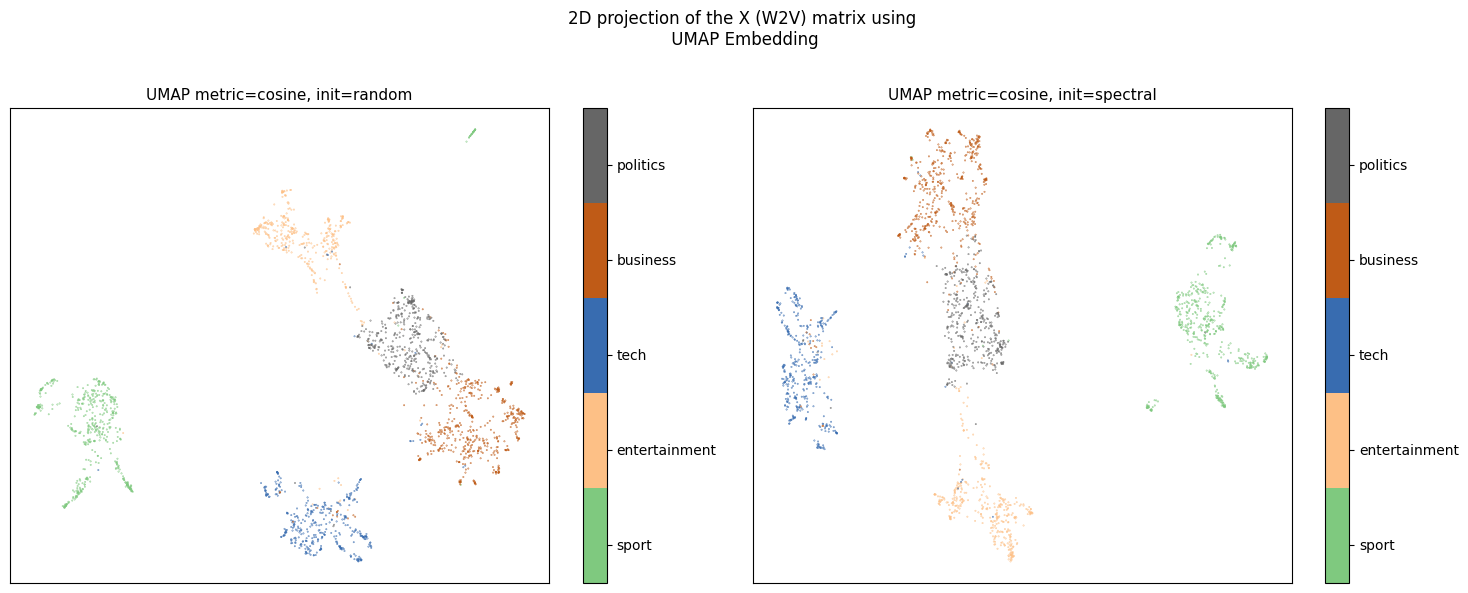

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    name, X_red = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=topic_colors,
        cmap='Accent',
        s=0.1,
        alpha=1
    )
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
    cbar.set_ticks(np.arange(5))
    cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("bbc_W2V_UMAP_2Dplot")
plt.show()

##### <span style='color:#3390FF; font-weight: bold;'> K-Means </span>

In [110]:
km_w2v = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='random',
    random_state=123
)
km_fit_w2v = km_w2v.fit(X_w2v)
km_lab_w2v = km_w2v.fit_predict(X_w2v)

In [111]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors, km_w2v.cluster_centers_),
    ('c1', "Check Clustering - UMAP metric=cosine, init=random", w2v_umap_emb_irnd, km_lab_w2v, km_w2v.cluster_centers_),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors, km_w2v.cluster_centers_),
    ('c2', "Check Clustering UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, km_lab_w2v, km_w2v.cluster_centers_)
]

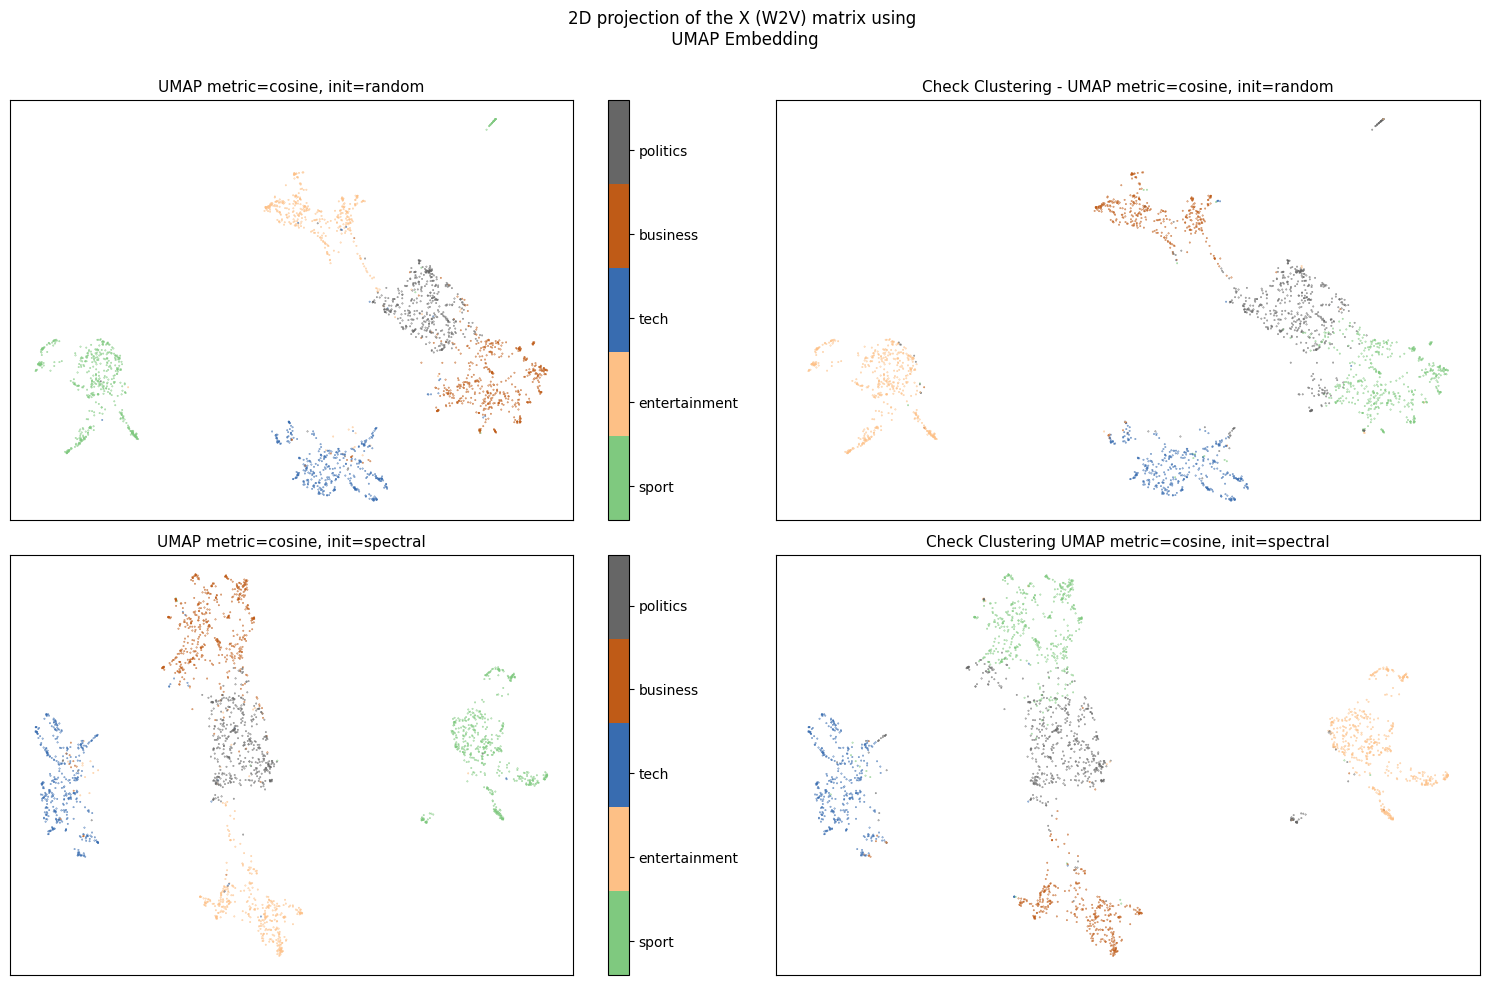

In [112]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap, centers = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig(f"{document_name}_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_UMAP_2Dplot")
plt.show()

###### $\rightarrow$ Model evaluations

In [113]:
fit_and_evaluate(
    km_w2v, # model or estimator
    X_w2v, # matrix original
    name="k-means",
    dset=f"{document_name}-w2v"
)

clustering done in 9.72 ± 2.59 s 
Homogeneity: 0.738 ± 0.002
Completeness: 0.739 ± 0.002
V-measure: 0.739 ± 0.002
Rand index: 0.919 ± 0.001
ARI: 0.749 ± 0.003
MI: 1.182 ± 0.003
NMI: 0.739 ± 0.002
Silhouette Coefficient: 0.148 ± 0.001


In [114]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v.inertia_:.2f}')


Distortion: 2093.60


###### $\rightarrow$ Elbow method to Estimate number of clusters needs


In [115]:
kmeans_per_k =\
    [cluster.KMeans(
    n_clusters=k,
    init='random',
    n_init=10,
    tol=1e-04,
    max_iter=300,
    random_state=0
    ).fit(X_w2v)
    for k in range(1, 11)]

In [116]:
inertias = [model.inertia_ for model in kmeans_per_k]

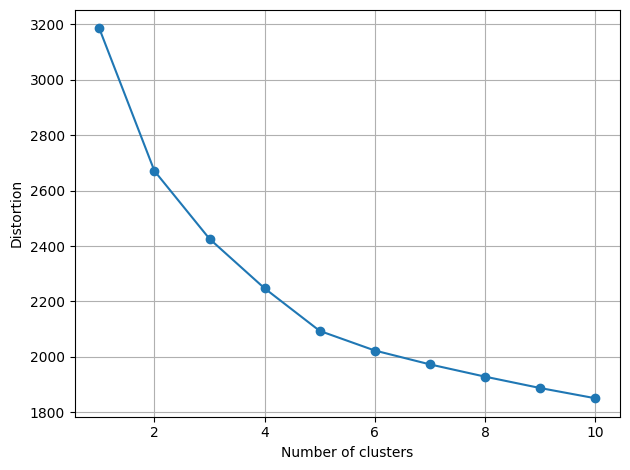

In [117]:
plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.grid()
save_fig(f"{document_name}_W2V_BEST_NB_CLUST_DISTORTION_Line_plot")
plt.show()

###### $\rightarrow$ Silhouette method to Estimate number of clusters needs


In [118]:
silhouette_scores = [metrics.silhouette_score(X_w2v, model.labels_)
                     for model in kmeans_per_k[1:]]

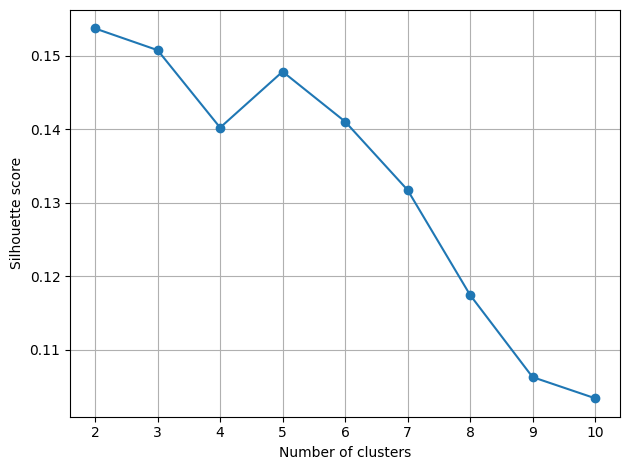

In [119]:
plt.plot(range(2,11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.tight_layout()
save_fig(f"{document_name}_W2V_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.grid()
plt.show()

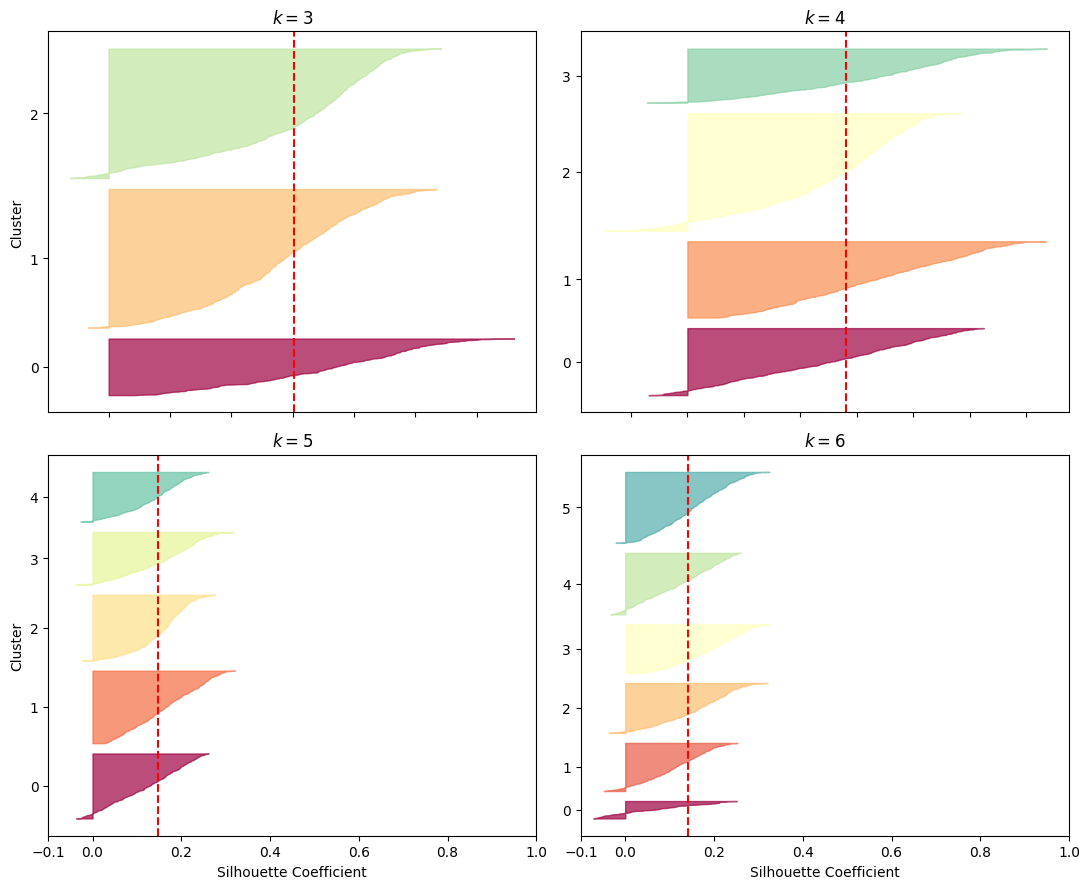

In [120]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_w2v, y_pred)

    padding = len(X_w2v) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig(f"{document_name}_KMEANS++_silhouette_analysis_plot")
plt.show()

##### <span style='color:#3390FF; font-weight: bold;'> K-Means++ </span>

In [121]:
kmpp_w2v = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    init='k-means++',
    max_iter=300,
    tol=1e-04,
    random_state=0
)

kmpp_lab_w2v = kmpp_w2v.fit_predict(X_w2v)

In [122]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors),
    ('c1', "Check K-mean++ Clustering \n UMAP metric=cosine, init=random", w2v_umap_emb_irnd, kmpp_lab_w2v),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('c2', "Check K-mean++ Clustering \n UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, kmpp_lab_w2v)
]

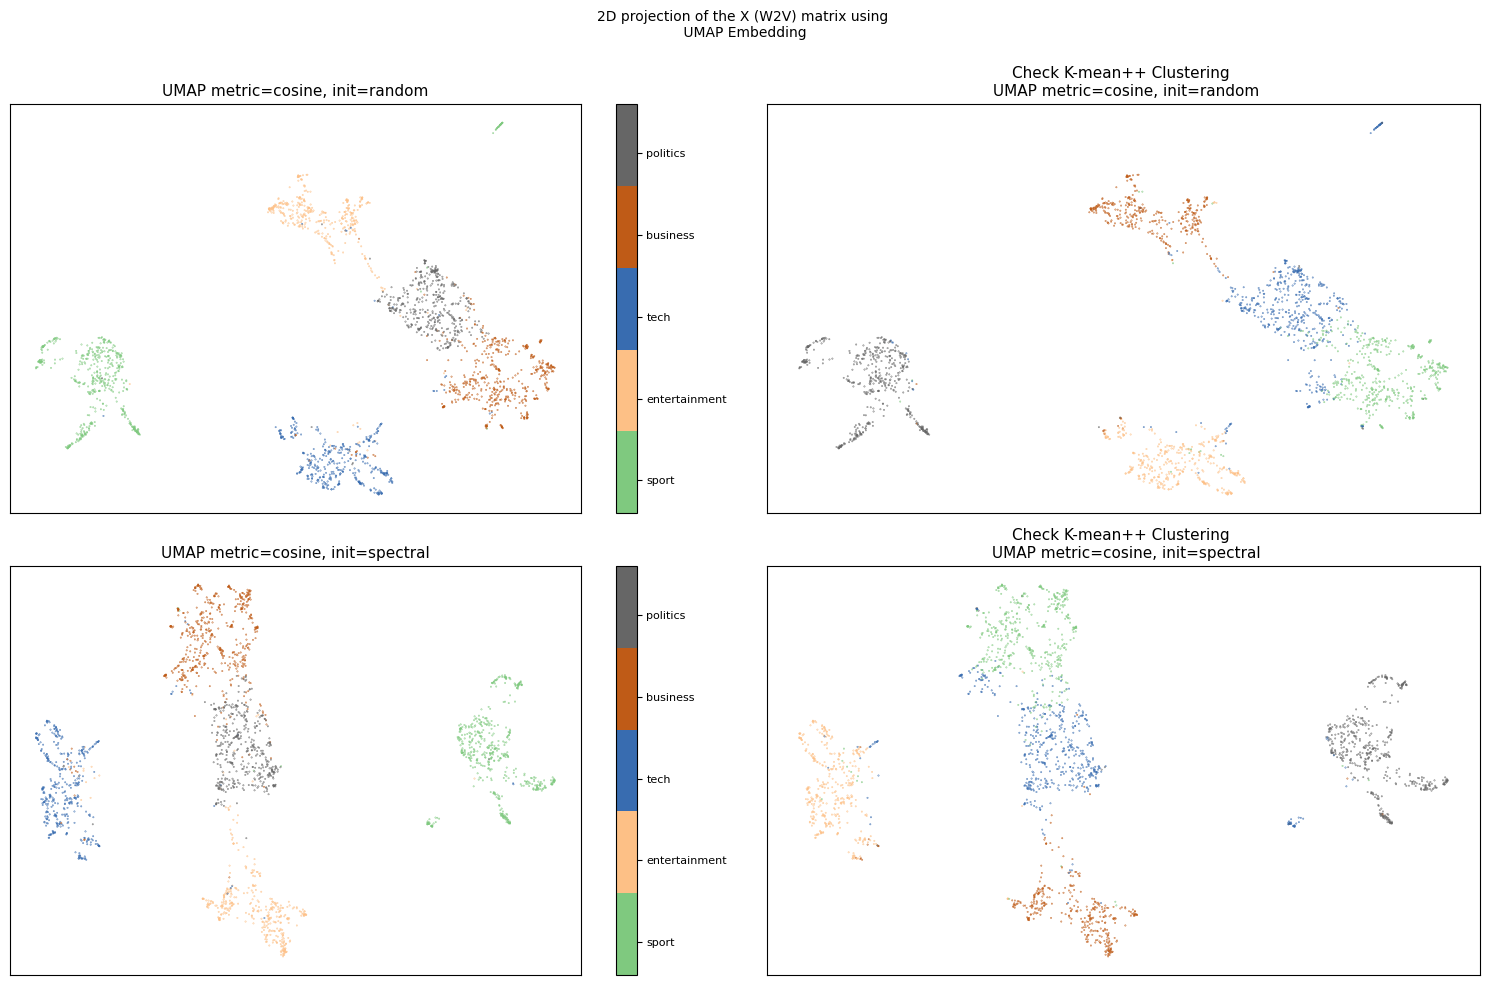

In [123]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=10)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=8)
    ax.set_title(name, size=11)
save_fig(f"{document_name}_W2V_ORIGINAL_VS_KMEANS++_CLUSTERING_2Dplot")
plt.show()

###### $\rightarrow$ Model evaluations

In [124]:
fit_and_evaluate(
    kmpp_w2v, # model
    X_w2v, # matrix original
    name="k-means++",
    metric=None,
    dset=f"{document_name}-w2v"
)

clustering done in 3.01 ± 2.50 s 
Homogeneity: 0.738 ± 0.002
Completeness: 0.739 ± 0.001
V-measure: 0.739 ± 0.001
Rand index: 0.919 ± 0.001
ARI: 0.749 ± 0.002
MI: 1.182 ± 0.002
NMI: 0.739 ± 0.001
Silhouette Coefficient: 0.148 ± 0.001


In [125]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmpp_w2v.inertia_:.2f}')

Distortion: 2093.60


In [126]:
kmeanspp_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(X_w2v)
     for k in range(1, 11)]

In [127]:
inertias = [model.inertia_ for model in kmeanspp_per_k]

###### $\rightarrow$ Elbow method to Estimate number of clusters needs

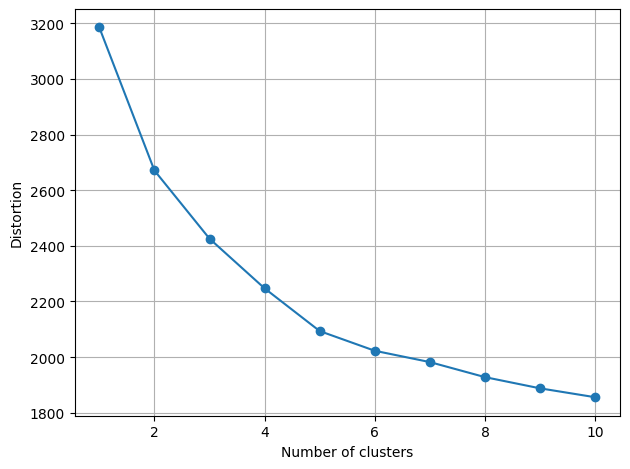

In [128]:
plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.grid()
save_fig(f"{document_name}_W2V_KMEANSPP_BEST_NB_CLUST_DISTORTION_Line_plot")
plt.show()

###### $\rightarrow$  silhouette diagram

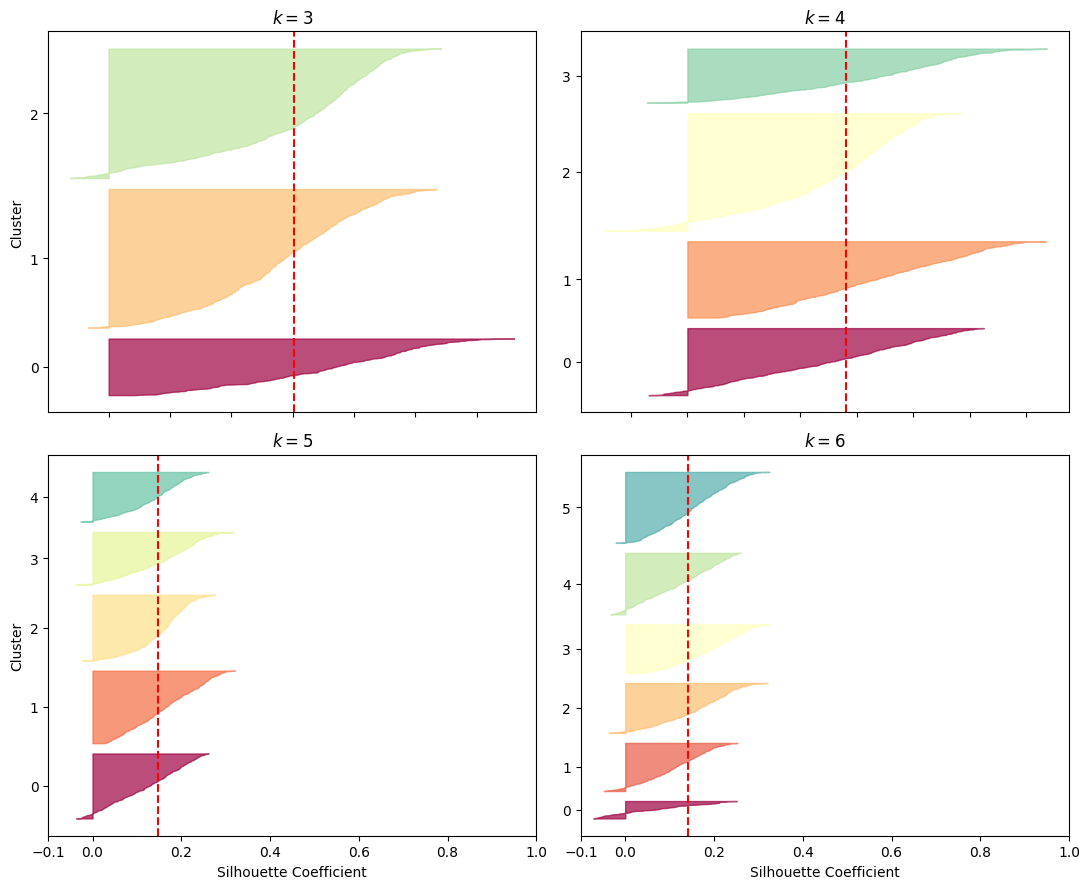

In [129]:

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_w2v, y_pred)

    padding = len(X_w2v) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig(f"{document_name}_KMEANS++_silhouette_analysis_plot")
plt.show()

As you can see, ***k = 5***, looks like the best option here, as all clusters are roughly the same size,
and they all cross the dashed line, which represents the mean silhouette score.

###### $\rightarrow$  Clustering evaluation summary¶


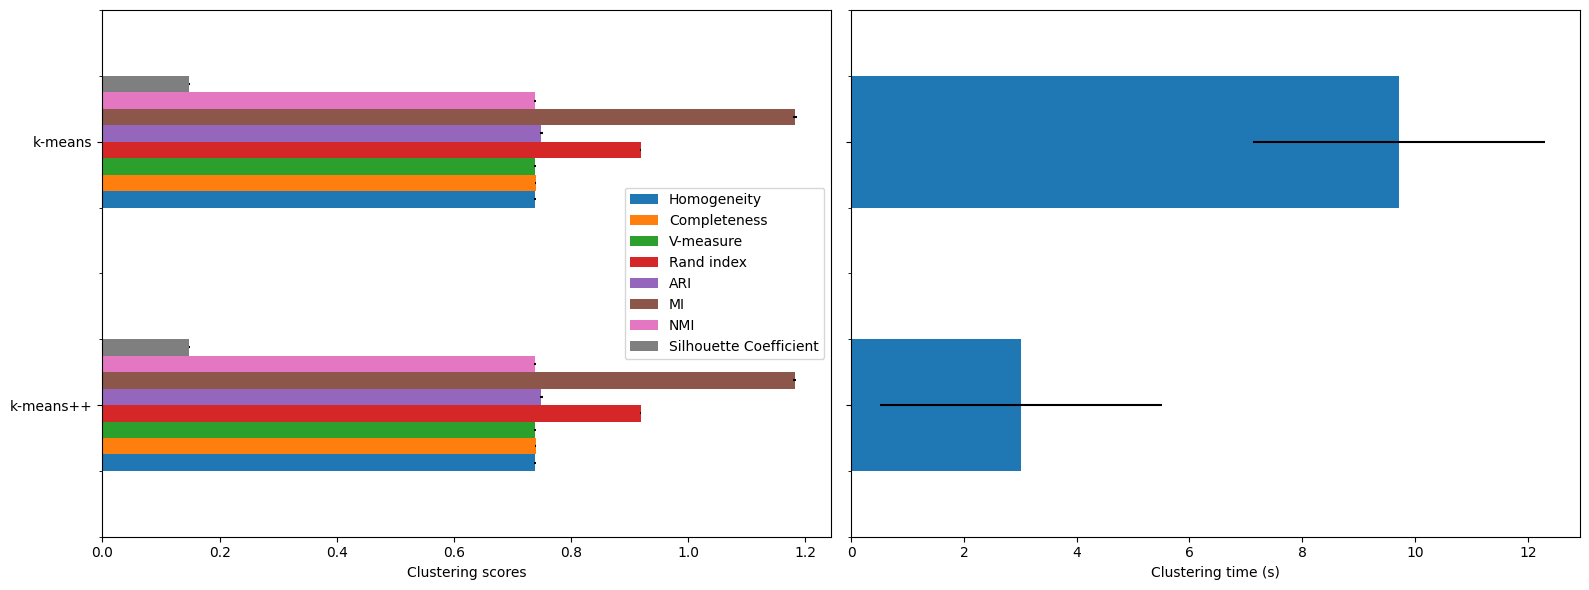

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()
######

##### <span style='color:#3390FF; font-weight: bold;'> Kmedoids </span>

In [131]:
from sklearn_extra.cluster import KMedoids, CLARA

In [132]:
kmd_w2v_cos = KMedoids(
    metric="cosine",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

kmd_w2v_mnt = KMedoids(
    metric="manhattan",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

clr_w2v_cos = CLARA(
    metric="cosine",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clr_w2v_mnt = CLARA(
    metric="manhattan",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clustering_algorithms_metrics = [
    ('kcos', "K-Medoid metric=cosine \n UMAP metric=cosine, init=random", kmd_w2v_cos),
    ('kmnt', "K-Medoid metric=manathan \n UMAP metric=cosine, init=random", kmd_w2v_mnt),
    ('rcos', "CLARA metric=cosine \n UMAP metric=cosine, init=random", clr_w2v_cos),
    ('rmnt', "CLARA metric=manathan \nUMAP metric=cosine, init=spectral", clr_w2v_mnt),
]

In [133]:
umap_mth = [
    ('o1', "UMAP metric=cosine", w2v_umap_emb_irnd, topic_colors),
    ('kc', "KMenoids metric=cosine", w2v_umap_emb_irnd, kmpp_lab_w2v),
    ('km', "KMenoids metric=manhattan", w2v_umap_emb_irnd, kmpp_lab_w2v),
]

umap_mth_spt = [
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
]

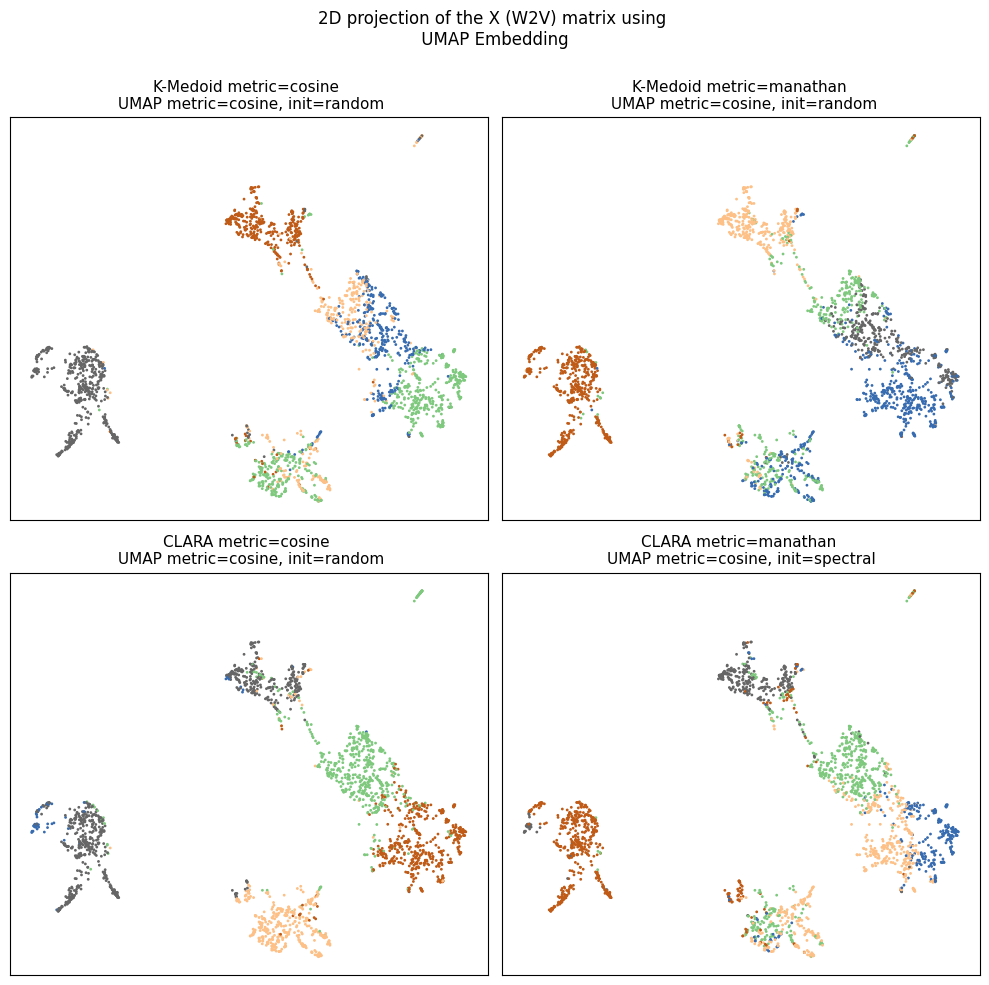

In [134]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, algorithm in zip(axs.flat, clustering_algorithms_metrics):
    tag, name, model = algorithm

    # on entraine les modèles
    model.fit(X_w2v)

    # dépendamment de l'implémentation, on peut avoir des attributs labels_ ou non
    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(X_w2v)

    # select reduction umap method
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=y_pred,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig(f"{document_name}_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

In [135]:
fit_and_evaluate(
    kmd_w2v_cos, # model
    X_w2v, # matrix original
    name="kmenoid-cos",
    metric="cosine",
    dset=f"{document_name}-w2v"
)

clustering done in 0.29 ± 0.04 s 
Homogeneity: 0.681 ± 0.081
Completeness: 0.684 ± 0.079
V-measure: 0.682 ± 0.080
Rand index: 0.894 ± 0.035
ARI: 0.675 ± 0.105
MI: 1.090 ± 0.130
NMI: 0.682 ± 0.080
Silhouette Coefficient: 0.126 ± 0.031


In [136]:
fit_and_evaluate(
    kmd_w2v_mnt, # model
    X_w2v, # matrix original
    name="kmenoid-mnt",
    metric="manhattan",
    dset=f"{document_name}-w2v"
)

clustering done in 1.86 ± 0.56 s 
Homogeneity: 0.641 ± 0.098
Completeness: 0.645 ± 0.096
V-measure: 0.643 ± 0.097
Rand index: 0.878 ± 0.041
ARI: 0.627 ± 0.124
MI: 1.027 ± 0.157
NMI: 0.643 ± 0.097
Silhouette Coefficient: 0.113 ± 0.035


In [137]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_cos.inertia_:.2f}')
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_mnt.inertia_:.2f}')

Distortion: 180.98
Distortion: 33278.76


In [138]:
kmenoid_cos_per_k = \
    [KMedoids(
        metric="cosine",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(X_w2v)
     for k in range(1, 11)]

In [139]:
kmenoid_mnt_per_k = \
    [KMedoids(
        metric="manhattan",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(X_w2v)
     for k in range(1, 11)]

In [140]:
inertias_kmd_cos = [model.inertia_ for model in kmenoid_cos_per_k]
inertias_kmd_mnt = [model.inertia_ for model in kmenoid_mnt_per_k]
silhouette_scores_cos = [metrics.silhouette_score(X_w2v, model.labels_)
                     for model in kmenoid_cos_per_k[1:]]
silhouette_scores_mnt = [metrics.silhouette_score(X_w2v, model.labels_)
                     for model in kmenoid_mnt_per_k[1:]]

###### $\rightarrow$ Elbow method to Estimate number of clusters needs

In [141]:
nbcluster_choice_methods = [
    ("Elbow method - cos", range(1,11), inertias_kmd_cos, "Number of clusters", "Distortion"),
    ("Silhouette method - cos", range(2,11), silhouette_scores_cos, "Number of clusters", "Silhouette score"),
    ("Elbow method - mnt", range(1,11), inertias_kmd_mnt, "Number of clusters", "Distortion"),
    ("Silhouette method - mnt ", range(2,11), silhouette_scores_mnt, "Number of clusters", "Silhouette score")
]

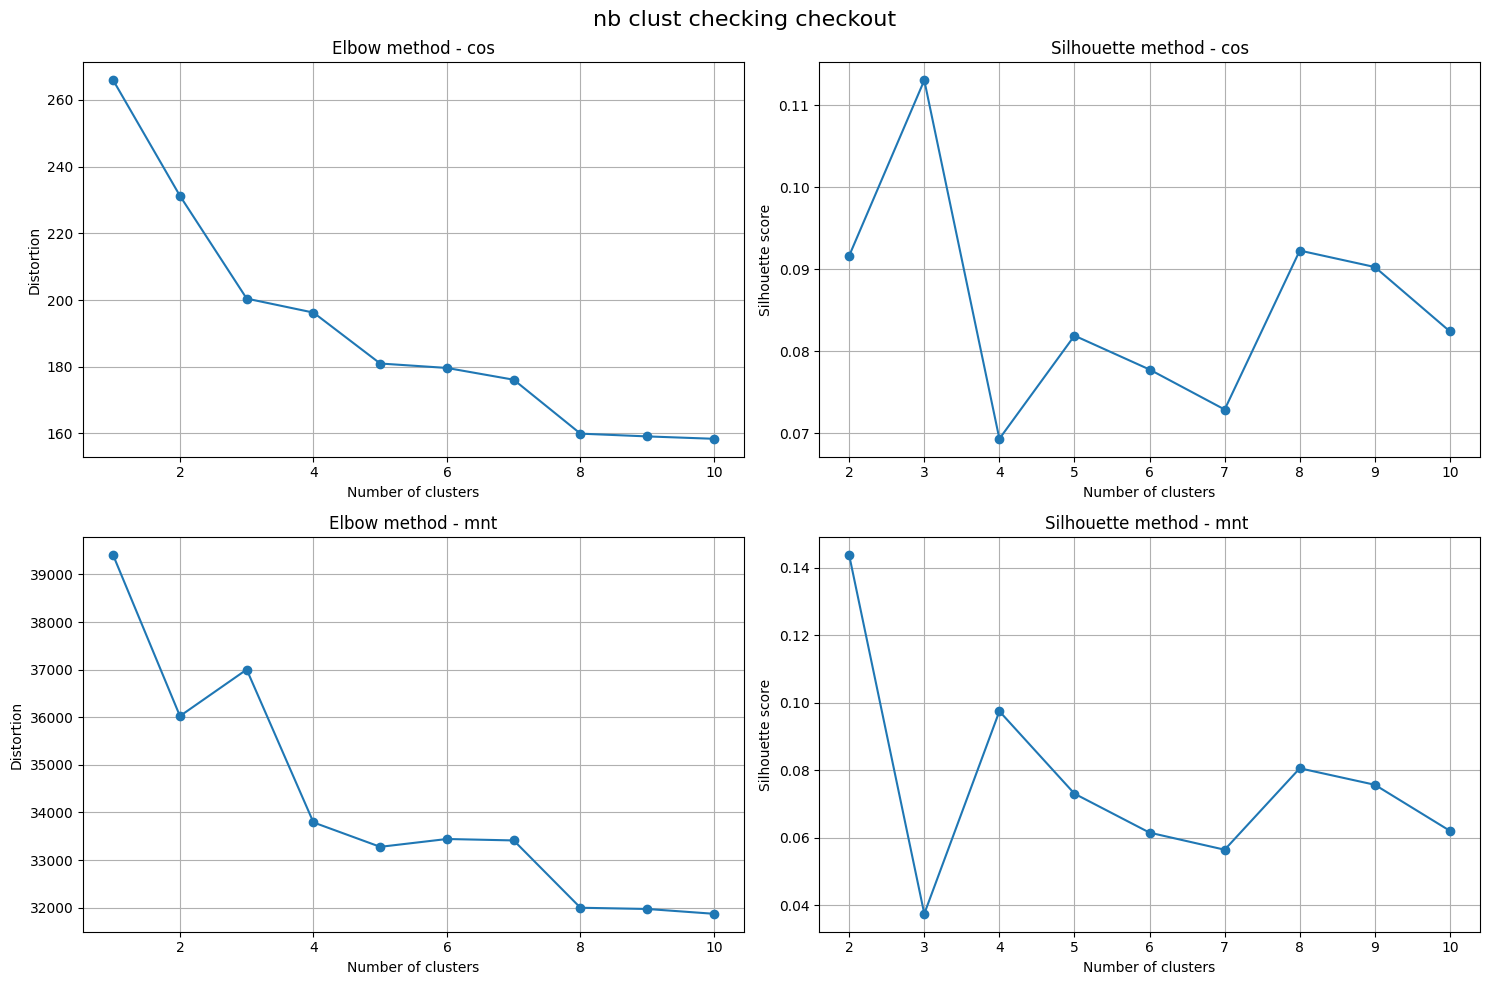

In [142]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig(f"{document_name}_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

##### <span style='color:#3390FF; font-weight: bold;'> Sphérical Kmean </span>

In [143]:
from coclust.clustering.spherical_kmeans import SphericalKmeans
skm = SphericalKmeans(
    n_clusters=5,
    n_init=10,
    tol=1e-4,
    max_iter=300
)

In [144]:
t0 = time()
skm.fit(X_w2v)
t = time() - t0

 == New init == 
iteration: 0
2026.5770505930047
iteration: 1
2075.136922711171
iteration: 2
2078.4052181076318
iteration: 3
2081.177580522957
iteration: 4
2088.2381968455047
iteration: 5
2092.8279993060946
iteration: 6
2093.193996619832
iteration: 7
2093.2781633269774
iteration: 8
2093.3110039747185
iteration: 9
2093.3222738423347
iteration: 10
2093.3261867847477
iteration: 11
2093.329582164369
iteration: 12
2093.331402808279
iteration: 13
2093.3321819026623
iteration: 14
2093.332408084362
iteration: 15
 == New init == 
iteration: 0
2027.8454174804065
iteration: 1
2073.379686567957
iteration: 2
2078.1055258264405
iteration: 3
2082.7743416260423
iteration: 4
2086.3086679964113
iteration: 5
2090.3937019007567
iteration: 6
2092.953916853137
iteration: 7
2093.2434790231773
iteration: 8
2093.317471173698
iteration: 9
2093.331400293066
iteration: 10
2093.3337147522525
iteration: 11
2093.3342709747913
iteration: 12
 == New init == 
iteration: 0
2027.734136730308
iteration: 1
2081.69166880258

In [145]:
skm_labels = skm.labels_

In [146]:
evaluate(
    labels_= skm_labels, # label
    X= X_w2v, # matrix original
    name="skm",
    metric=None,
    dset=f"{document_name}-w2v",
    train_times=t
)

Homogeneity: 0.646 ± 0.099
Completeness: 0.650 ± 0.096
V-measure: 0.648 ± 0.097
Rand index: 0.880 ± 0.041
ARI: 0.632 ± 0.124
MI: 1.035 ± 0.158
NMI: 0.648 ± 0.097
Silhouette Coefficient: 0.114 ± 0.035


In [147]:
space = [
    ('org', "Origin", topic_colors),
    ('skm', "skm (color just means cluster discovered)", skm_labels)
    ]

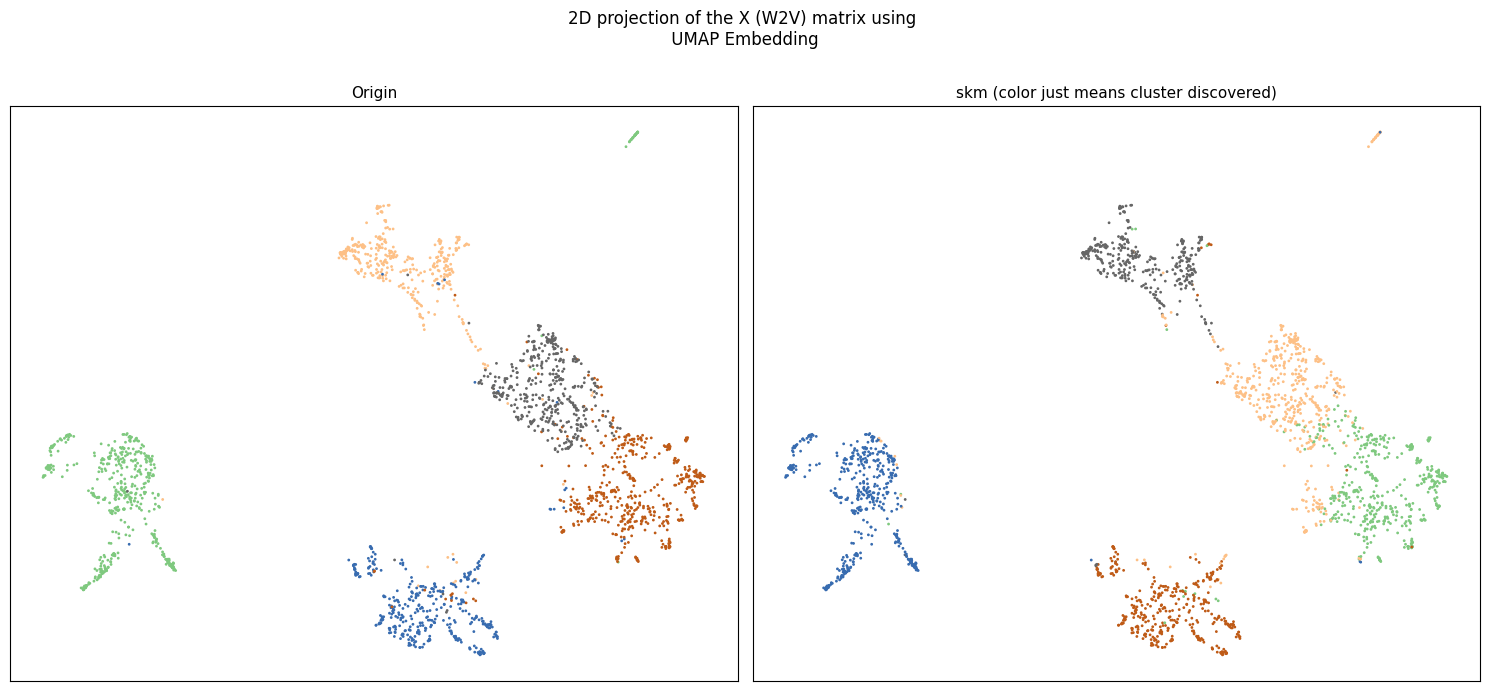

In [148]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, sp in zip(axs.flat, space):
    tag, name, cmap = sp

    # select reduction umap method
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig(f"{document_name}_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()


##### <span style='color:#3390FF; font-weight: bold;'> CAH </span>

In [149]:
from sklearn.cluster import AgglomerativeClustering

In [150]:
linkage = ("ward", "average", "complete", "single")

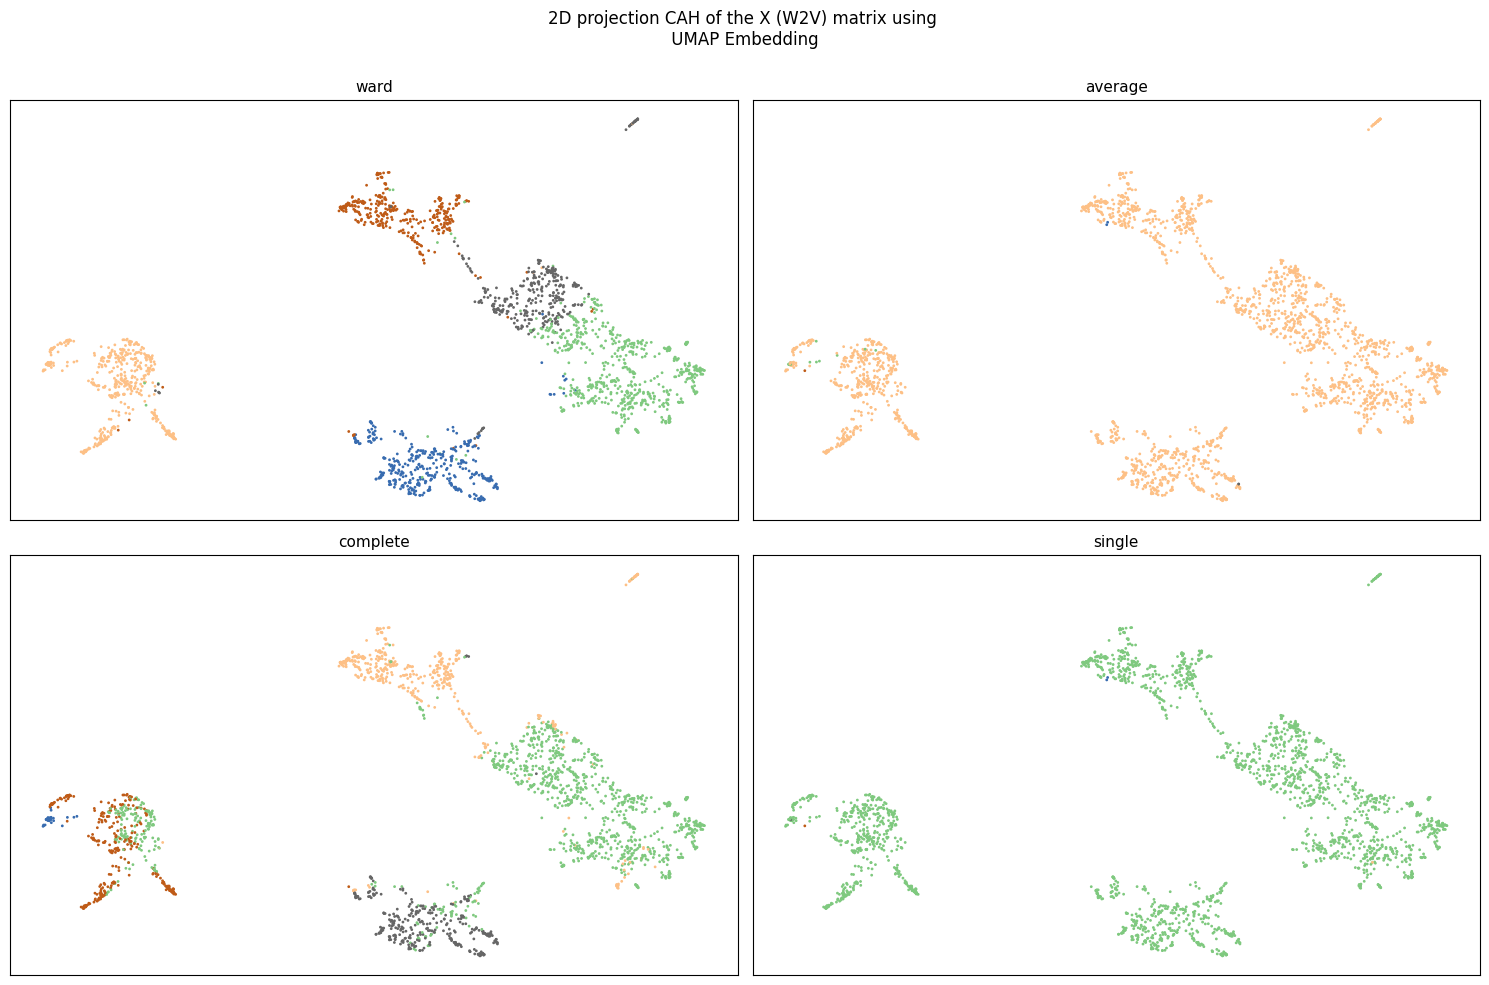

In [151]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection CAH of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, lk in zip(axs.flat, linkage):

    # select reduction umap method for plotting
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    clustering = AgglomerativeClustering(linkage=lk, n_clusters=5)
    clustering.fit(X_w2v)

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=clustering.labels_,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(f'{lk}', size=11)
save_fig(f"{document_name}_CAH_CLUSTERING_VARIOUS_LINKAGE_2Dplot")
plt.show()

In [152]:
cah_ward_per_k = [AgglomerativeClustering(linkage="ward", n_clusters=k).fit(X_w2v) for k in range(1, 11)]

In [153]:
silhouette_scores_cah_ward = [metrics.silhouette_score(X_w2v, model.labels_) for model in cah_ward_per_k[1:]]

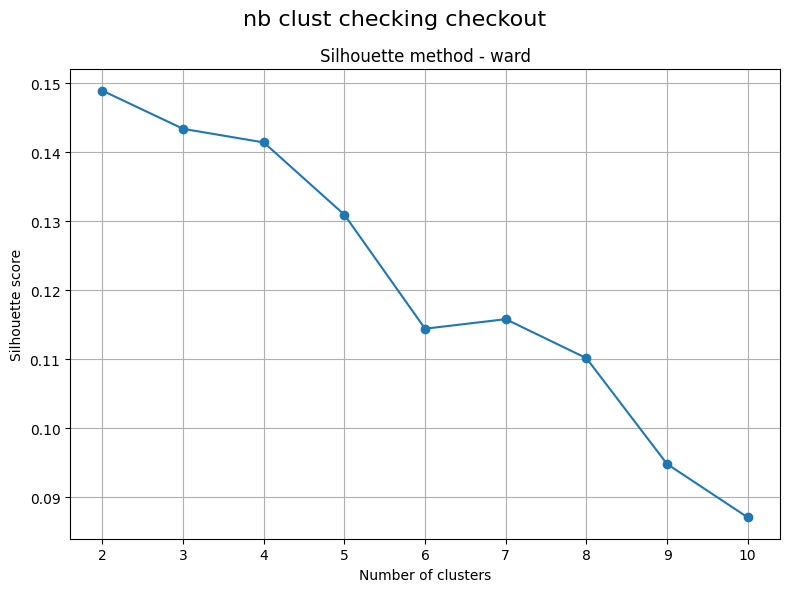

In [154]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("nb clust checking checkout", size=16)

plot = ax.plot(range(2,11), silhouette_scores_cah_ward, marker='o')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette method - ward", size=12)
ax.grid()
plt.tight_layout()
save_fig(f"{document_name}_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [155]:
cah_ward_per_linkage_k5 = [AgglomerativeClustering(linkage=lk, n_clusters=5).fit(X_w2v) for lk in linkage]

In [156]:
t0 = time()
cah_single = AgglomerativeClustering(linkage="single", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-single", metric=None, dset=f"{document_name}-w2v", train_times=t)

Homogeneity: 0.617 ± 0.165
Completeness: 0.629 ± 0.134
V-measure: 0.619 ± 0.164
Rand index: 0.849 ± 0.146
ARI: 0.604 ± 0.179
MI: 0.988 ± 0.264
NMI: 0.619 ± 0.164
Silhouette Coefficient: 0.116 ± 0.035


In [157]:
t0 = time()
AgglomerativeClustering(linkage="average", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-average", metric=None, dset=f"{document_name}-w2v", train_times=t)

Homogeneity: 0.590 ± 0.204
Completeness: 0.610 ± 0.159
V-measure: 0.592 ± 0.204
Rand index: 0.821 ± 0.194
ARI: 0.577 ± 0.214
MI: 0.945 ± 0.327
NMI: 0.592 ± 0.204
Silhouette Coefficient: 0.117 ± 0.035


In [158]:
t0 = time()
AgglomerativeClustering(linkage="complete", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-complete", metric=None, dset=f"{document_name}-w2v", train_times=t)

Homogeneity: 0.566 ± 0.232
Completeness: 0.592 ± 0.177
V-measure: 0.567 ± 0.231
Rand index: 0.796 ± 0.226
ARI: 0.553 ± 0.239
MI: 0.906 ± 0.372
NMI: 0.567 ± 0.231
Silhouette Coefficient: 0.118 ± 0.035


In [159]:
t0 = time()
AgglomerativeClustering(linkage="ward", n_clusters=5).fit(X_w2v)
t = time() - t0
evaluate(labels_= cah_single.labels_, X= X_w2v, name="cah-ward", metric=None, dset=f"{document_name}-w2v", train_times=t)

Homogeneity: 0.543 ± 0.253
Completeness: 0.576 ± 0.191
V-measure: 0.545 ± 0.252
Rand index: 0.772 ± 0.250
ARI: 0.531 ± 0.258
MI: 0.870 ± 0.405
NMI: 0.545 ± 0.252
Silhouette Coefficient: 0.119 ± 0.034


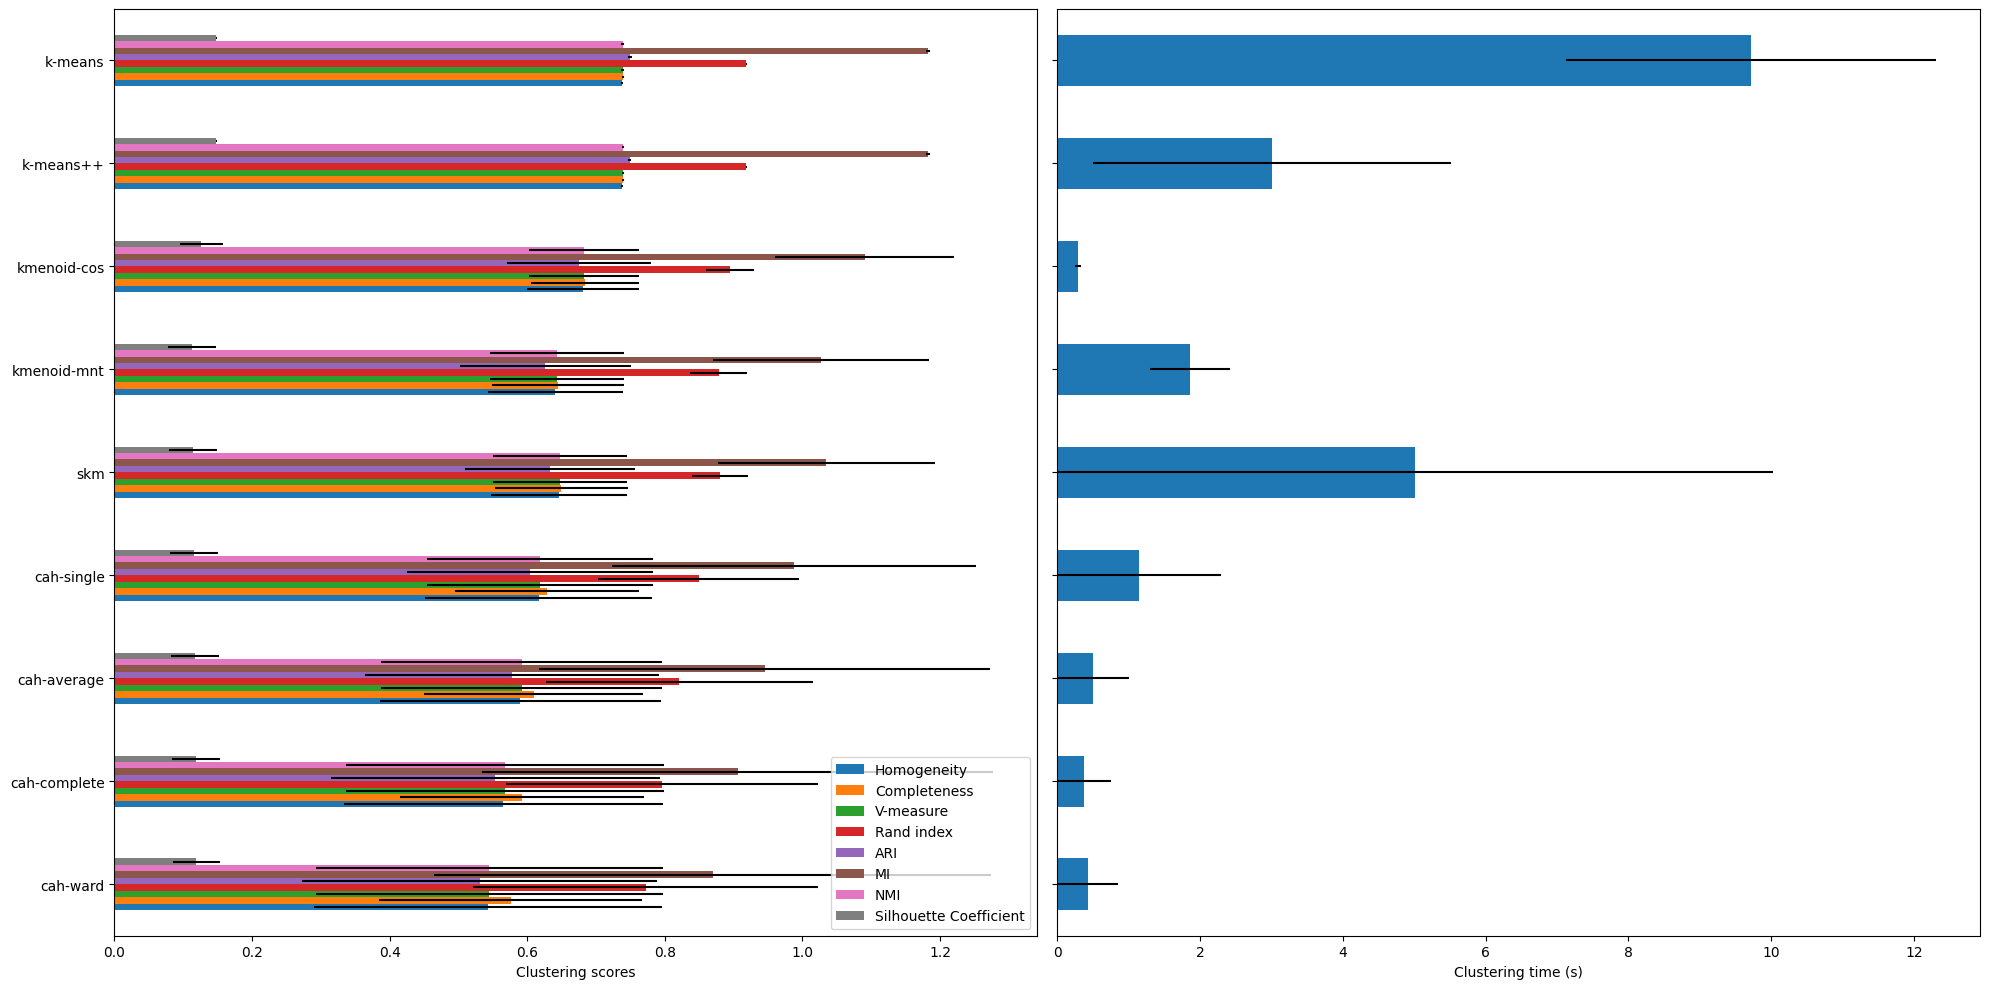

In [160]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

df_clust_ori = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_clust_ori_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df_clust_ori.drop(
    ["train_time", "dset", "metric"], # we don't need plotting those (non--numeric)
    axis="columns",
).plot.barh(ax=ax0, xerr=df_clust_ori_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df_clust_ori["train_time"].plot.barh(ax=ax1, xerr=df_clust_ori_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()
######

In [161]:
# summary dataframe of clustering on original data
df_clust_ori.head(n=10)

dset     metric  train_time  Homogeneity  Completeness   
estimator                                                                 
cah-ward      bbc-w2v       None    0.429493     0.542977      0.575859  \
cah-complete  bbc-w2v       None    0.375419     0.565508      0.592020   
cah-average   bbc-w2v       None    0.503970     0.589999      0.609586   
cah-single    bbc-w2v       None    1.147374     0.616716      0.628749   
skm           bbc-w2v       None    5.013345     0.645977      0.649737   
kmenoid-mnt   bbc-w2v  manhattan    1.861073     0.640957      0.644814   
kmenoid-cos   bbc-w2v     cosine    0.293603     0.680618      0.683715   
k-means++     bbc-w2v       None    3.009164     0.738017      0.739399   
k-means       bbc-w2v       None    9.720266     0.738016      0.739399   

              V-measure  Rand index       ARI        MI       NMI   
estimator                                                           
cah-ward       0.544895    0.772083  0.531244  0.869873  0.544895  \
cah-complete   0.567416    0.795701  0.553381  0.905969  0.567416   
cah-average    0.591896    0.821372  0.577443  0.945205  0.591896   
cah-single     0.618600    0.849377  0.603692  0.988007  0.618600   
skm            0.647848    0.880049  0.632442  1.034885  0.647848   
kmenoid-mnt    0.642876    0.878091  0.626529  1.026842  0.642876   
kmenoid-cos    0.682160    0.894161  0.675080  1.090382  0.682160   
k-means++      0.738707    0.918765  0.749132  1.182336  0.738707   
k-means        0.738707    0.918764  0.749132  1.182336  0.738707   

              Silhouette Coefficient  
estimator                             
cah-ward                    0.119144  
cah-complete                0.118139  
cah-average                 0.116864  
cah-single                  0.115627  
skm                         0.114299  
kmenoid-mnt                 0.112685  
kmenoid-cos                 0.125968  
k-means++                   0.147970  
k-means                     0.148084

In [162]:
df_clust_ori.to_latex(
    index=["estimator"],
    columns=["ARI", "PMI", "NMI", "Silhouette Coefficient"],
    formatters={"name": str.upper},
    float_format="{:.2f}".format,
)

'\\begin{tabular}{lrrr}\n\\toprule\n & ARI & NMI & Silhouette Coefficient \\\\\nestimator &  &  &  \\\\\n\\midrule\ncah-ward & 0.53 & 0.54 & 0.12 \\\\\ncah-complete & 0.55 & 0.57 & 0.12 \\\\\ncah-average & 0.58 & 0.59 & 0.12 \\\\\ncah-single & 0.60 & 0.62 & 0.12 \\\\\nskm & 0.63 & 0.65 & 0.11 \\\\\nkmenoid-mnt & 0.63 & 0.64 & 0.11 \\\\\nkmenoid-cos & 0.68 & 0.68 & 0.13 \\\\\nk-means++ & 0.75 & 0.74 & 0.15 \\\\\nk-means & 0.75 & 0.74 & 0.15 \\\\\n\\bottomrule\n\\end{tabular}\n'

## <span style='color:#F9A861; font-weight: bold;'> DONNEES REDUITES </span>
---

In [163]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / f"{document_name}-red"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [164]:
from collections import defaultdict
from sklearn import metrics
from time import time
from time import sleep

evaluations_red = []
evaluations_red_std = []

scores_red = defaultdict(list)

labels = topic_colors

def evaluate_red(labels_, X, name=None, metric=None, dset=None, train_times=None):
    scores_red["Homogeneity"].append(metrics.homogeneity_score(labels, labels_))
    scores_red["Completeness"].append(metrics.completeness_score(labels, labels_))
    scores_red["V-measure"].append(metrics.v_measure_score(labels, labels_))
    scores_red["Rand index"].append(
        metrics.rand_score(labels, labels_)
    )
    scores_red["ARI"].append(
        metrics.adjusted_rand_score(labels, labels_)
    )
    scores_red["MI"].append(
        metrics.mutual_info_score(labels, labels_)
    )
    scores_red["NMI"].append(
        metrics.normalized_mutual_info_score(labels, labels_)
    )
    scores_red["Silhouette Coefficient"].append(
        metrics.silhouette_score(X, labels_, sample_size=2000)
    )

    evaluation_red = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    evaluation_red_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times,
    }
    for score_name, score_values in scores_red.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation_red[score_name] = mean_score
        evaluation_red_std[score_name] = std_score
    evaluations_red.append(evaluation_red)
    evaluations_red_std.append(evaluation_red_std)

def fit_and_evaluate_red(km, X, name=None, metric=None, dset=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    for seed in range(n_runs):

        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores_red["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores_red["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores_red["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores_red["Rand index"].append(
            metrics.rand_score(labels, km.labels_)
        )
        scores_red["ARI"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores_red["MI"].append(
            metrics.mutual_info_score(labels, km.labels_)
        )
        scores_red["NMI"].append(
            metrics.normalized_mutual_info_score(labels, km.labels_)
        )
        scores_red["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")

    evaluation_red = {
        "dset": dset,
        "estimator": name,
        "metric": metric,
        "train_time": train_times.mean(),
    }
    evaluation_red_std = {
        "dset": dset, # origin or reduced
        "estimator": name,
        "metric": metric,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores_red.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation_red[score_name] = mean_score
        evaluation_red_std[score_name] = std_score
    evaluations_red.append(evaluation_red)
    evaluations_red_std.append(evaluation_red_std)

### >> <span style='color:#3390FF; font-weight: bold;'> UMAP</span>

#### >> >> >>  Kmeans

In [165]:
km_w2v_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='random',
    random_state=123
)

km_w2v_red_rnd_fit = km_w2v_red.fit(w2v_umap_emb_irnd)
km_w2v_red_spt_fit = km_w2v_red.fit(w2v_umap_emb_ispt)

km_lab_w2v_umap_emb_irnd = km_w2v_red.fit_predict(w2v_umap_emb_irnd)
km_lab_w2v_umap_emb_spt = km_w2v_red.fit_predict(w2v_umap_emb_ispt)

In [166]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors),
    ('c1', "Check Clustering - UMAP metric=cosine, init=random", w2v_umap_emb_irnd, km_lab_w2v_umap_emb_irnd),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('c2', "Check Clustering UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, km_lab_w2v_umap_emb_spt)
]

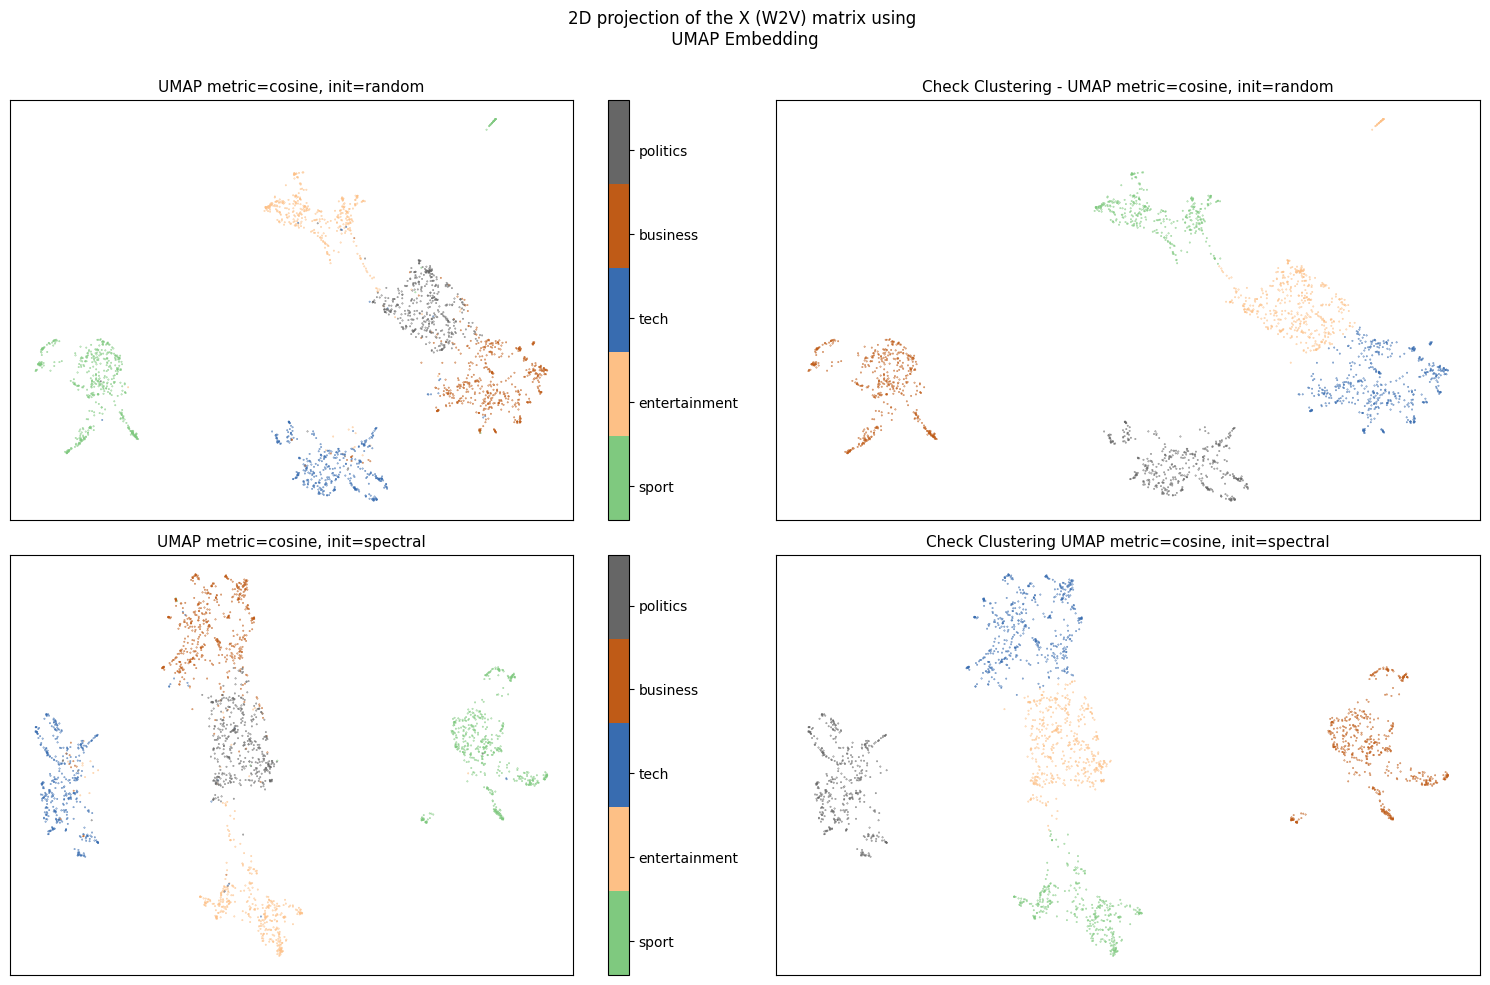

In [167]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("bbc_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_UMAP_2Dplot")
plt.show()

In [168]:
# random reducted
fit_and_evaluate_red(
    km_w2v_red, # model or estimator
    w2v_umap_emb_irnd, # matrix original
    name="k-means _ rnd",
    dset="bbc-w2v-rnd-red"
)
print("========")
# spectral reduced
fit_and_evaluate_red(
    km_w2v_red,  # model or estimator
    w2v_umap_emb_ispt,  # matrix original
    name="k-means _ spt",
    dset="bbc-w2v-spt-red"
)

clustering done in 0.77 ± 0.68 s 
Homogeneity: 0.831 ± 0.000
Completeness: 0.830 ± 0.000
V-measure: 0.830 ± 0.000
Rand index: 0.953 ± 0.000
ARI: 0.855 ± 0.000
MI: 1.331 ± 0.000
NMI: 0.830 ± 0.000
Silhouette Coefficient: 0.650 ± 0.002
clustering done in 2.00 ± 2.06 s 
Homogeneity: 0.844 ± 0.014
Completeness: 0.844 ± 0.014
V-measure: 0.844 ± 0.014
Rand index: 0.958 ± 0.005
ARI: 0.871 ± 0.016
MI: 1.353 ± 0.022
NMI: 0.844 ± 0.014
Silhouette Coefficient: 0.659 ± 0.009


In [169]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v_red_rnd_fit.inertia_:.2f}')
print(f'Distortion: {km_w2v_red_spt_fit.inertia_:.2f}')

Distortion: 3883.75
Distortion: 3883.75


###### $\rightarrow$  Elbow method to Estimate number of clusters needs


In [170]:
kmeans_rnd_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='random',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

kmeans_spt_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='random',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_ispt)
     for k in range(1, 11)]

In [171]:
inertias_rnd = [model.inertia_ for model in kmeans_rnd_per_k]
inertias_spt = [model.inertia_ for model in kmeans_spt_per_k]
silhouette_scores_rnd = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmeans_rnd_per_k[1:]]
silhouette_scores_spt = [metrics.silhouette_score(w2v_umap_emb_ispt, model.labels_)
                         for model in kmeans_spt_per_k[1:]]

In [172]:
nbcluster_choice_methods = [
    ("Elbow method - rnd", range(1,11), inertias_rnd, "Number of clusters", "Distortion"),
    ("Silhouette method -spt", range(2,11), silhouette_scores_rnd, "Number of clusters", "Silhouette score"),
    ("Elbow method - rnd", range(1,11), inertias_spt, "Number of clusters", "Distortion"),
    ("Silhouette method -spt ", range(2,11), silhouette_scores_spt, "Number of clusters", "Silhouette score")
]

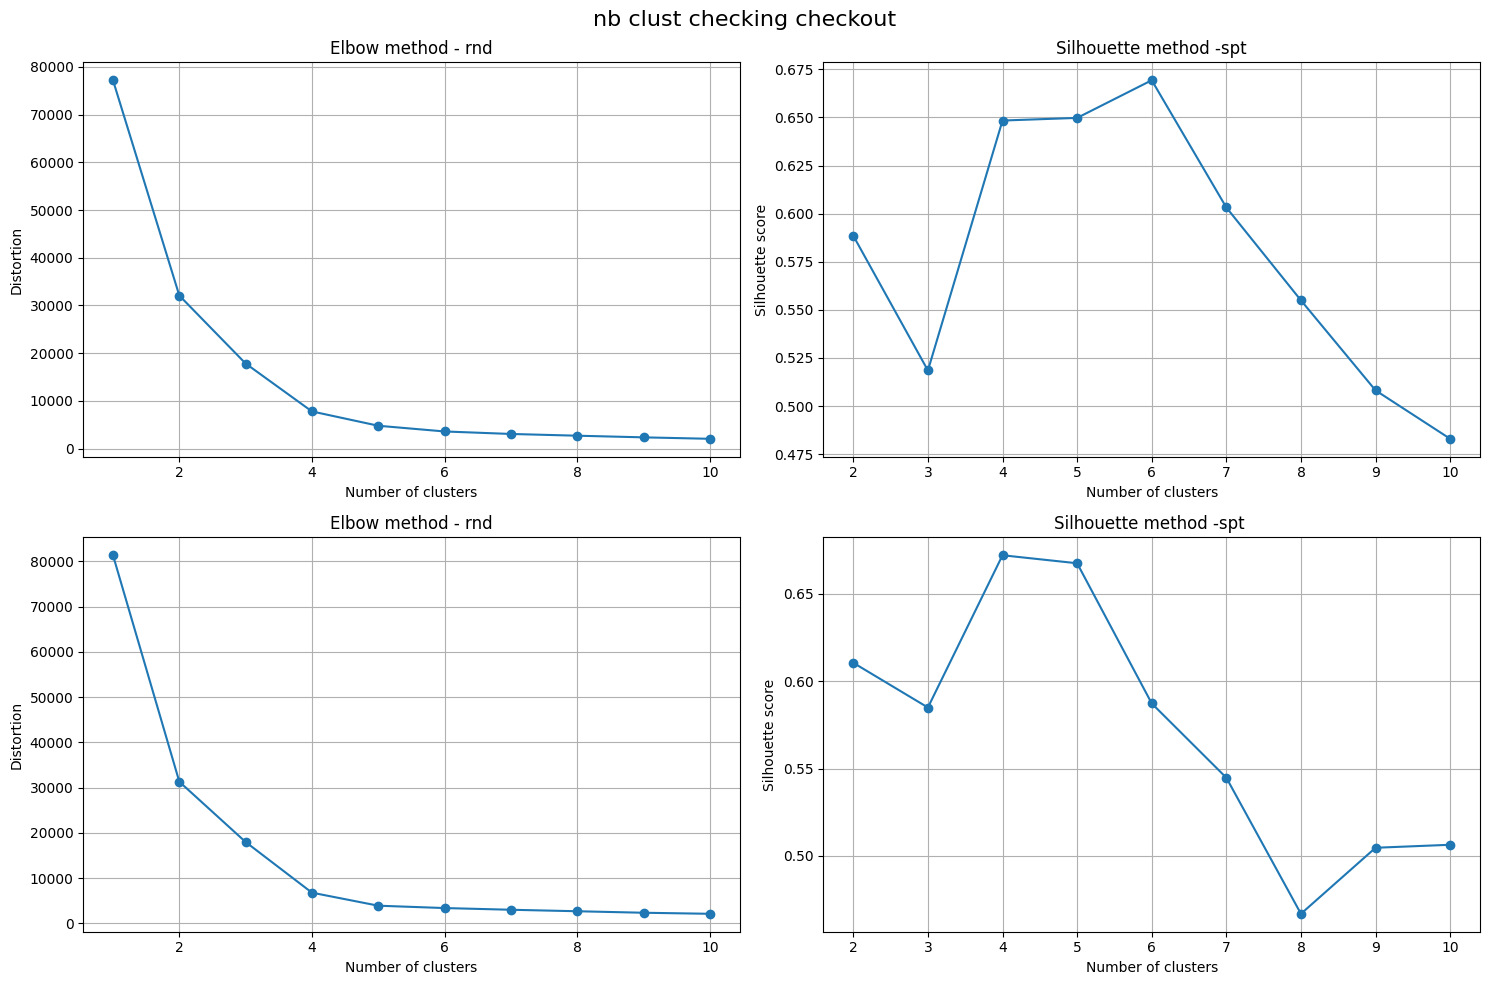

In [173]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [174]:
### None

#### >> >> >>  Kmeans++

In [175]:
kmpp_w2v_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='k-means++',
    random_state=123
)

kmpp_w2v_red_rnd_fit = kmpp_w2v_red.fit(w2v_umap_emb_irnd)
kmpp_w2v_red_spt_fit = kmpp_w2v_red.fit(w2v_umap_emb_ispt)

kmpp_lab_w2v_umap_emb_irnd = kmpp_w2v_red.fit_predict(w2v_umap_emb_irnd)
kmpp_lab_w2v_umap_emb_spt = kmpp_w2v_red.fit_predict(w2v_umap_emb_ispt)

In [176]:
umap_methods = [
    ('o1', "UMAP metric=cosine, init=random", w2v_umap_emb_irnd, topic_colors),
    ('c1', "Check Clustering - UMAP metric=cosine, init=random", w2v_umap_emb_irnd, kmpp_lab_w2v_umap_emb_irnd),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('c2', "Check Clustering UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, kmpp_lab_w2v_umap_emb_spt)
]

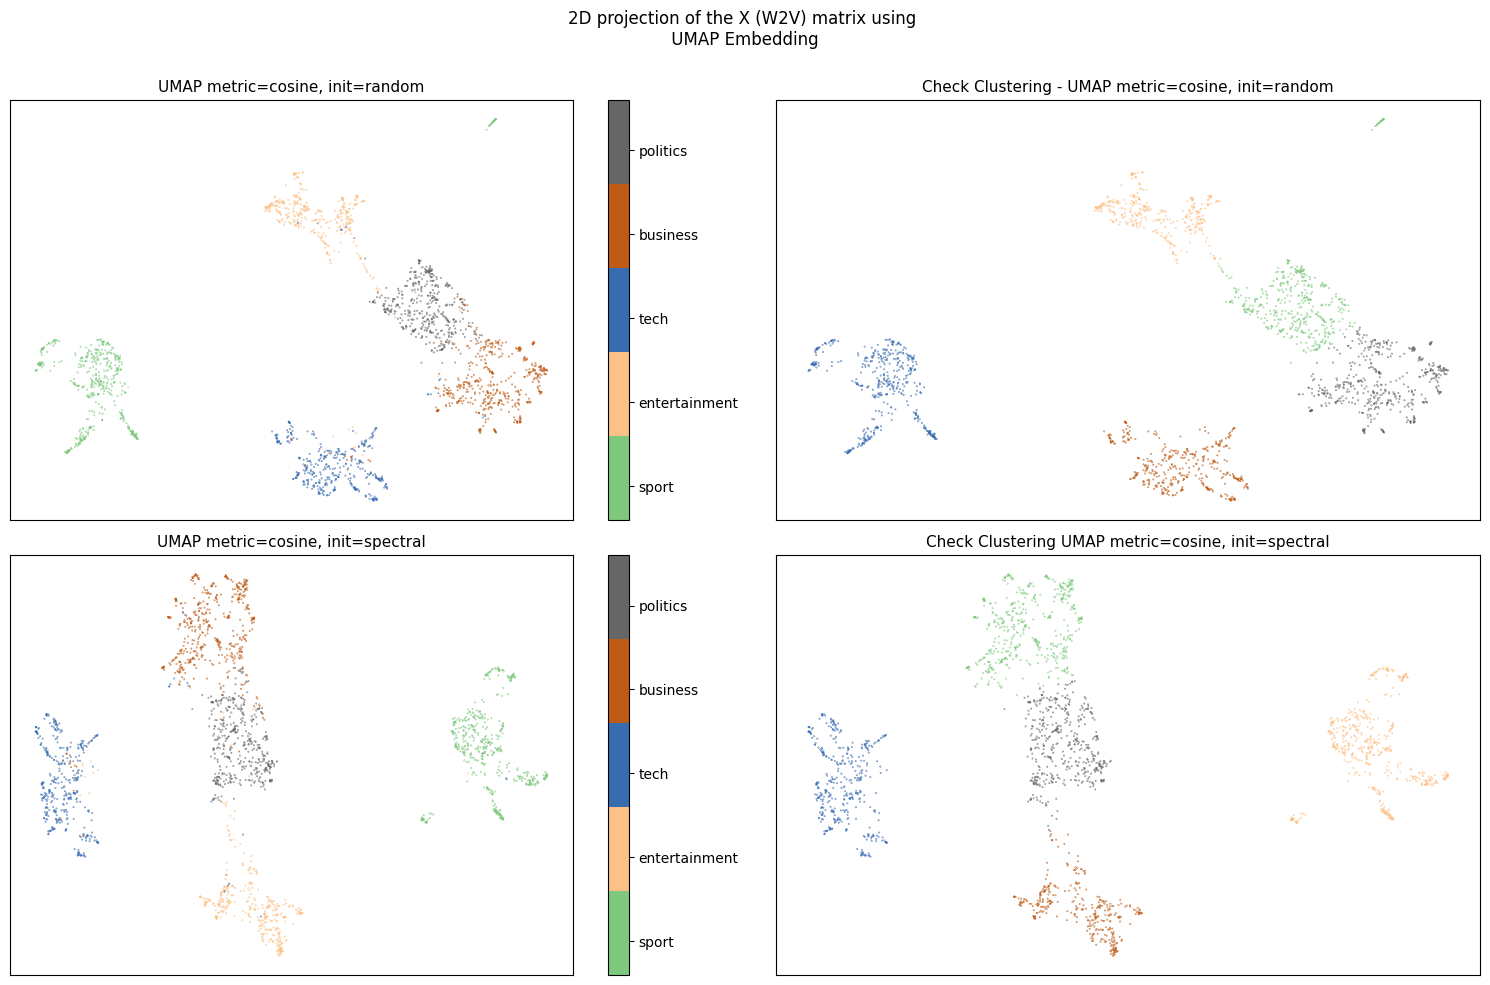

In [177]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("bbc_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_UMAP_2Dplot")
plt.show()

In [178]:
# random reducted
fit_and_evaluate_red(
    kmpp_w2v_red, # model or estimator
    w2v_umap_emb_irnd, # matrix original
    name="k-means++ - rnd",
    dset="bbc-w2v-rnd-red"
)
print("========")
# spectral reduced
fit_and_evaluate_red(
    kmpp_w2v_red,  # model or estimator
    w2v_umap_emb_ispt,  # matrix original
    name="k-means++ - spt",
    dset="bbc-w2v-spt-red"
)

clustering done in 1.36 ± 1.01 s 
Homogeneity: 0.840 ± 0.013
Completeness: 0.840 ± 0.013
V-measure: 0.840 ± 0.013
Rand index: 0.957 ± 0.005
ARI: 0.865 ± 0.015
MI: 1.346 ± 0.021
NMI: 0.840 ± 0.013
Silhouette Coefficient: 0.656 ± 0.009
clustering done in 1.32 ± 0.65 s 
Homogeneity: 0.844 ± 0.014
Completeness: 0.844 ± 0.014
V-measure: 0.844 ± 0.014
Rand index: 0.958 ± 0.005
ARI: 0.871 ± 0.016
MI: 1.353 ± 0.022
NMI: 0.844 ± 0.014
Silhouette Coefficient: 0.659 ± 0.009


In [179]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v_red_rnd_fit.inertia_:.2f}')
print(f'Distortion: {km_w2v_red_spt_fit.inertia_:.2f}')

Distortion: 3883.75
Distortion: 3883.75


###### $\rightarrow$  Elbow method to Estimate number of clusters needs


In [180]:
kmeanspp_rnd_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

kmeanspp_spt_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(w2v_umap_emb_ispt)
     for k in range(1, 11)]

In [181]:
inertias_rnd = [model.inertia_ for model in kmeanspp_rnd_per_k]
inertias_spt = [model.inertia_ for model in kmeanspp_spt_per_k]
silhouette_scores_rnd = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmeanspp_rnd_per_k[1:]]
silhouette_scores_spt = [metrics.silhouette_score(w2v_umap_emb_ispt, model.labels_)
                         for model in kmeanspp_spt_per_k[1:]]

In [182]:
nbcluster_choice_methods = [
    ("Elbow method - rnd", range(1,11), inertias_rnd, "Number of clusters", "Distortion"),
    ("Silhouette method -spt", range(2,11), silhouette_scores_rnd, "Number of clusters", "Silhouette score"),
    ("Elbow method - rnd", range(1,11), inertias_spt, "Number of clusters", "Distortion"),
    ("Silhouette method -spt ", range(2,11), silhouette_scores_spt, "Number of clusters", "Silhouette score")
]

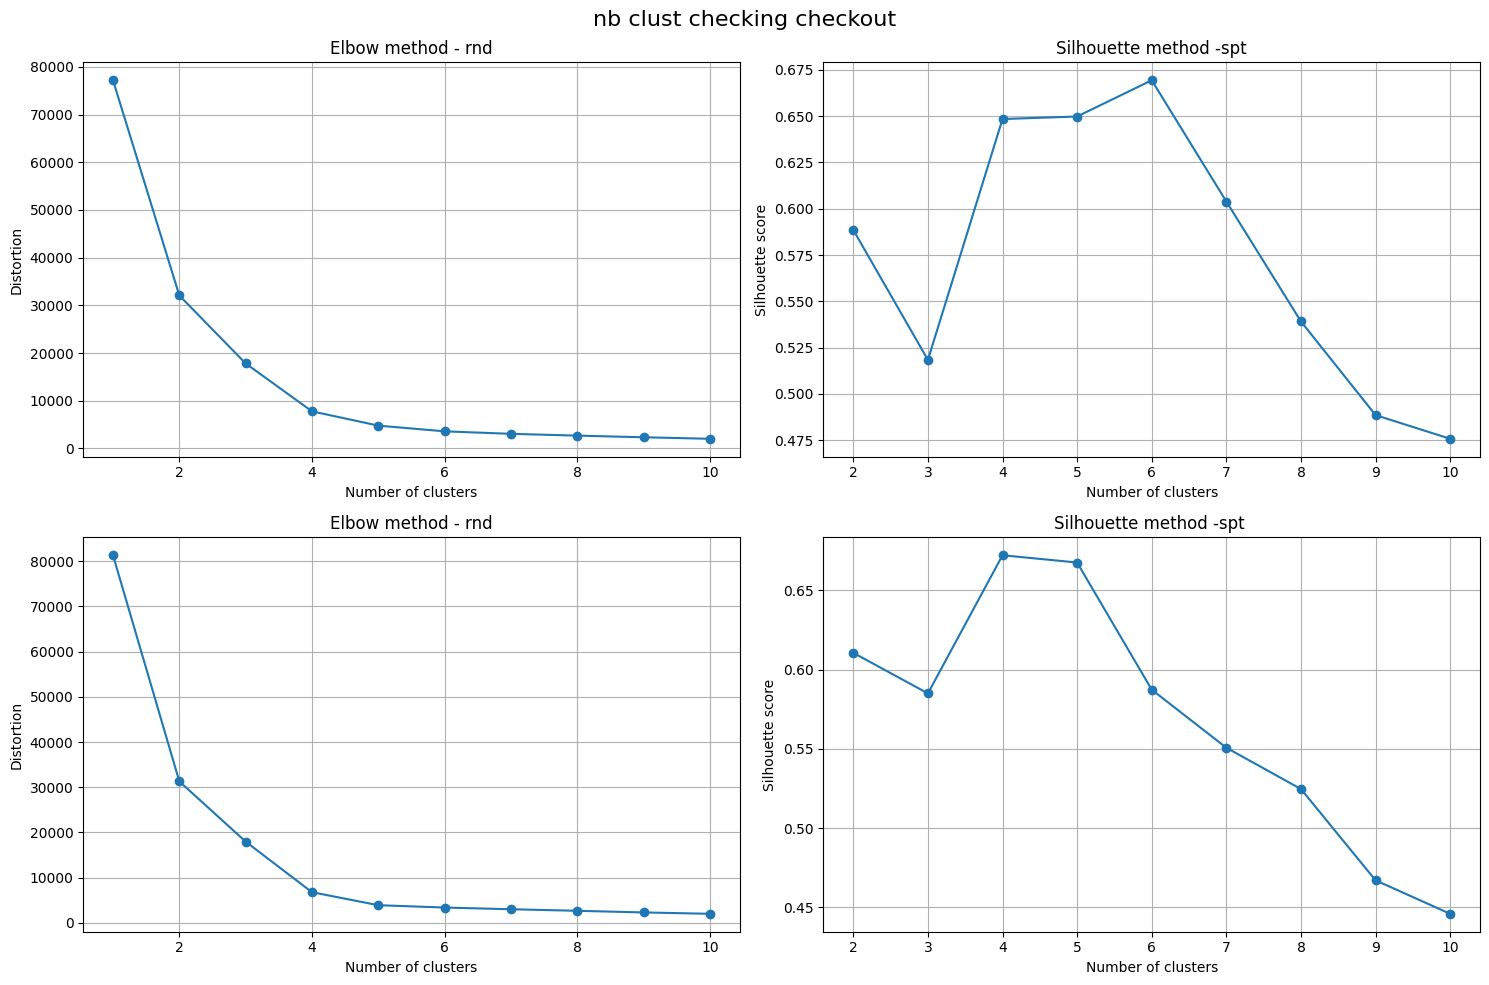

In [183]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Kmedoids

In [184]:
kmd_w2v_red_cos = KMedoids(
    metric="cosine",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

kmd_w2v_red_mnt = KMedoids(
    metric="manhattan",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

clr_w2v_red_cos = CLARA(
    metric="cosine",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clr_w2v_red_mnt = CLARA(
    metric="manhattan",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clustering_algorithms_metrics = [
    ('kcos', "K-Medoid metric=cosine \n UMAP metric=cosine, init=random", kmd_w2v_red_cos),
    ('kmnt', "K-Medoid metric=manathan \n UMAP metric=cosine, init=random", kmd_w2v_red_mnt),
    ('rcos', "CLARA metric=cosine \n UMAP metric=cosine, init=random", clr_w2v_red_cos),
    ('rmnt', "CLARA metric=manathan \nUMAP metric=cosine, init=spectral", clr_w2v_red_mnt),
]


In [185]:
umap_mth = [
    ('o1', "UMAP metric=cosine", w2v_umap_emb_irnd, topic_colors),
    ('kc', "KMenoids metric=cosine", w2v_umap_emb_irnd, kmpp_lab_w2v),
    ('km', "KMenoids metric=manhattan", w2v_umap_emb_irnd, kmpp_lab_w2v),
]

umap_mth_spt = [
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
    ('o2', "UMAP metric=cosine, init=spectral", w2v_umap_emb_ispt, topic_colors),
]

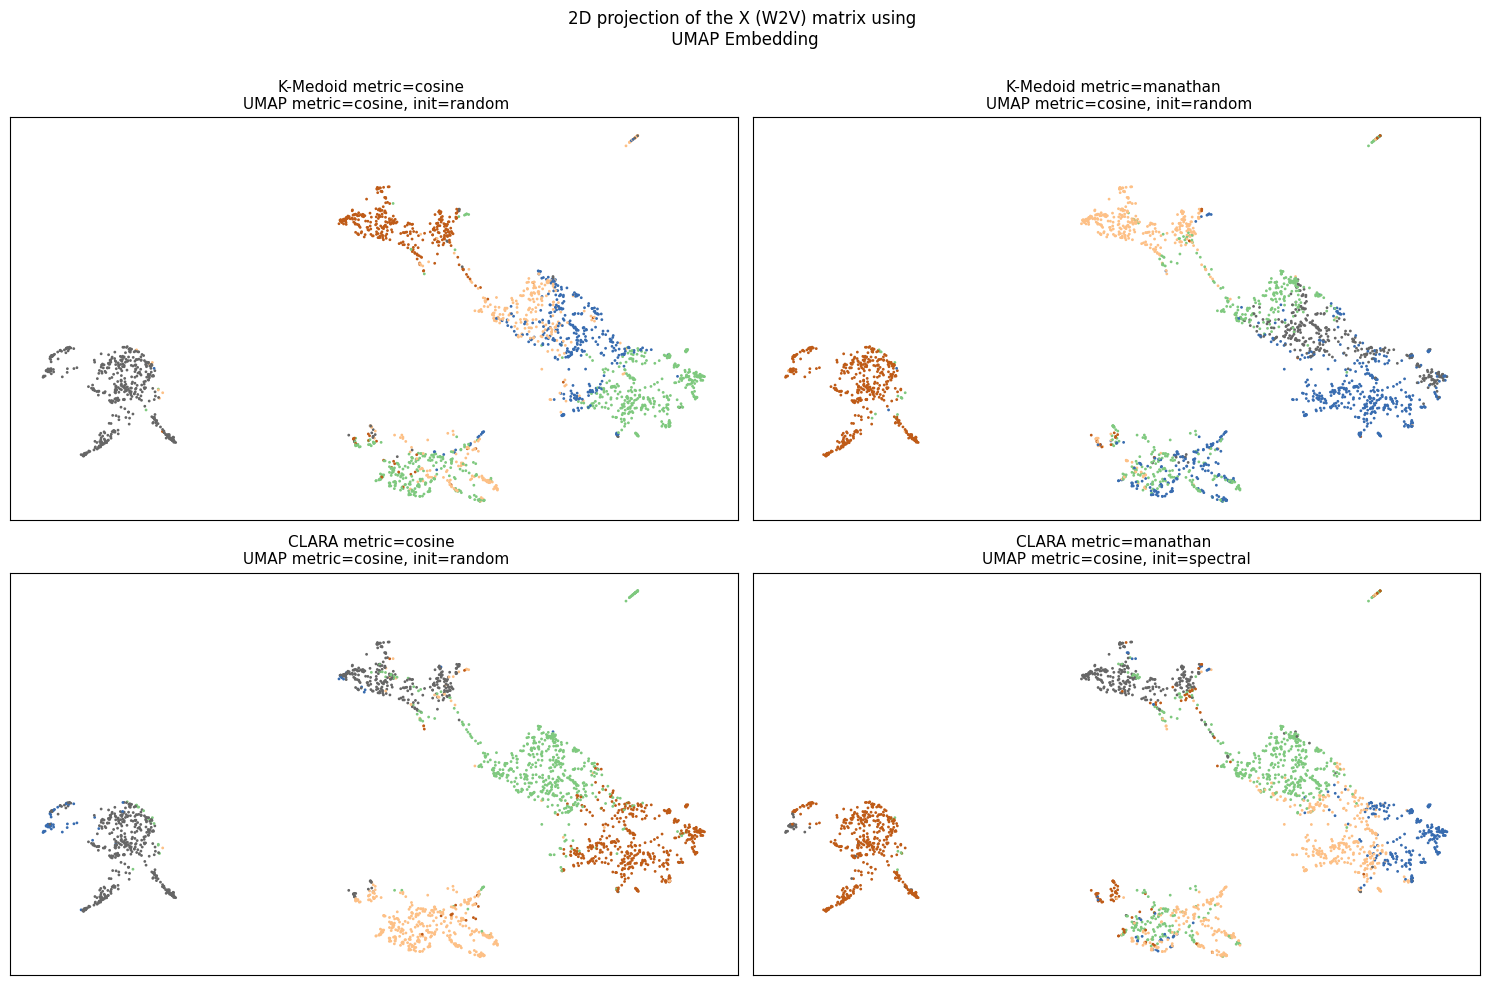

In [186]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, algorithm in zip(axs.flat, clustering_algorithms_metrics):
    tag, name, model = algorithm

    # on entraine les modèles
    model.fit(X_w2v)

    # dépendamment de l'implémentation, on peut avoir des attributs labels_ ou non
    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(w2v_umap_emb_irnd)

    # select reduction umap method for plotting
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=y_pred,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("bbc_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

In [187]:
fit_and_evaluate_red(
    kmd_w2v_red_cos, # model
    w2v_umap_emb_irnd, # matrix original
    name="kmenoid-cos",
    metric="cosine",
    dset="bbc-w2v-rnd-red"
)

clustering done in 0.27 ± 0.03 s 
Homogeneity: 0.804 ± 0.083
Completeness: 0.807 ± 0.076
V-measure: 0.805 ± 0.079
Rand index: 0.939 ± 0.038
ARI: 0.815 ± 0.113
MI: 1.288 ± 0.132
NMI: 0.805 ± 0.079
Silhouette Coefficient: 0.601 ± 0.115


In [188]:
fit_and_evaluate_red(
    kmd_w2v_red_mnt, # model
    w2v_umap_emb_irnd, # matrix original
    name="kmenoid-mnt",
    metric="manhattan",
    dset="bbc-w2v-rnd-red"
)

clustering done in 0.11 ± 0.00 s 
Homogeneity: 0.808 ± 0.076
Completeness: 0.811 ± 0.070
V-measure: 0.809 ± 0.073
Rand index: 0.942 ± 0.035
ARI: 0.821 ± 0.104
MI: 1.295 ± 0.122
NMI: 0.809 ± 0.073
Silhouette Coefficient: 0.610 ± 0.107


In [189]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_red_cos.inertia_:.2f}')
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_red_mnt.inertia_:.2f}')

Distortion: 10.72
Distortion: 3467.05


In [190]:
kmd_rnd_red_cos_per_k = \
    [KMedoids(
        metric="cosine",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

In [191]:
kmd_rnd_red_mnt_per_k = \
    [KMedoids(
        metric="manhattan",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(w2v_umap_emb_irnd)
     for k in range(1, 11)]

In [192]:
inertias_kmd_cos = [model.inertia_ for model in kmd_rnd_red_cos_per_k]
inertias_kmd_mnt = [model.inertia_ for model in kmd_rnd_red_mnt_per_k]
silhouette_scores_cos = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmenoid_cos_per_k[1:]]
silhouette_scores_mnt = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_)
                         for model in kmenoid_mnt_per_k[1:]]

###### $\rightarrow$ Elbow method to Estimate number of clusters needs

In [193]:
nbcluster_choice_methods = [
    ("Elbow method - cos", range(1,11), inertias_kmd_cos, "Number of clusters", "Distortion"),
    ("Silhouette method - cos", range(2,11), silhouette_scores_cos, "Number of clusters", "Silhouette score"),
    ("Elbow method - mnt", range(1,11), inertias_kmd_mnt, "Number of clusters", "Distortion"),
    ("Silhouette method - mnt ", range(2,11), silhouette_scores_mnt, "Number of clusters", "Silhouette score")
]

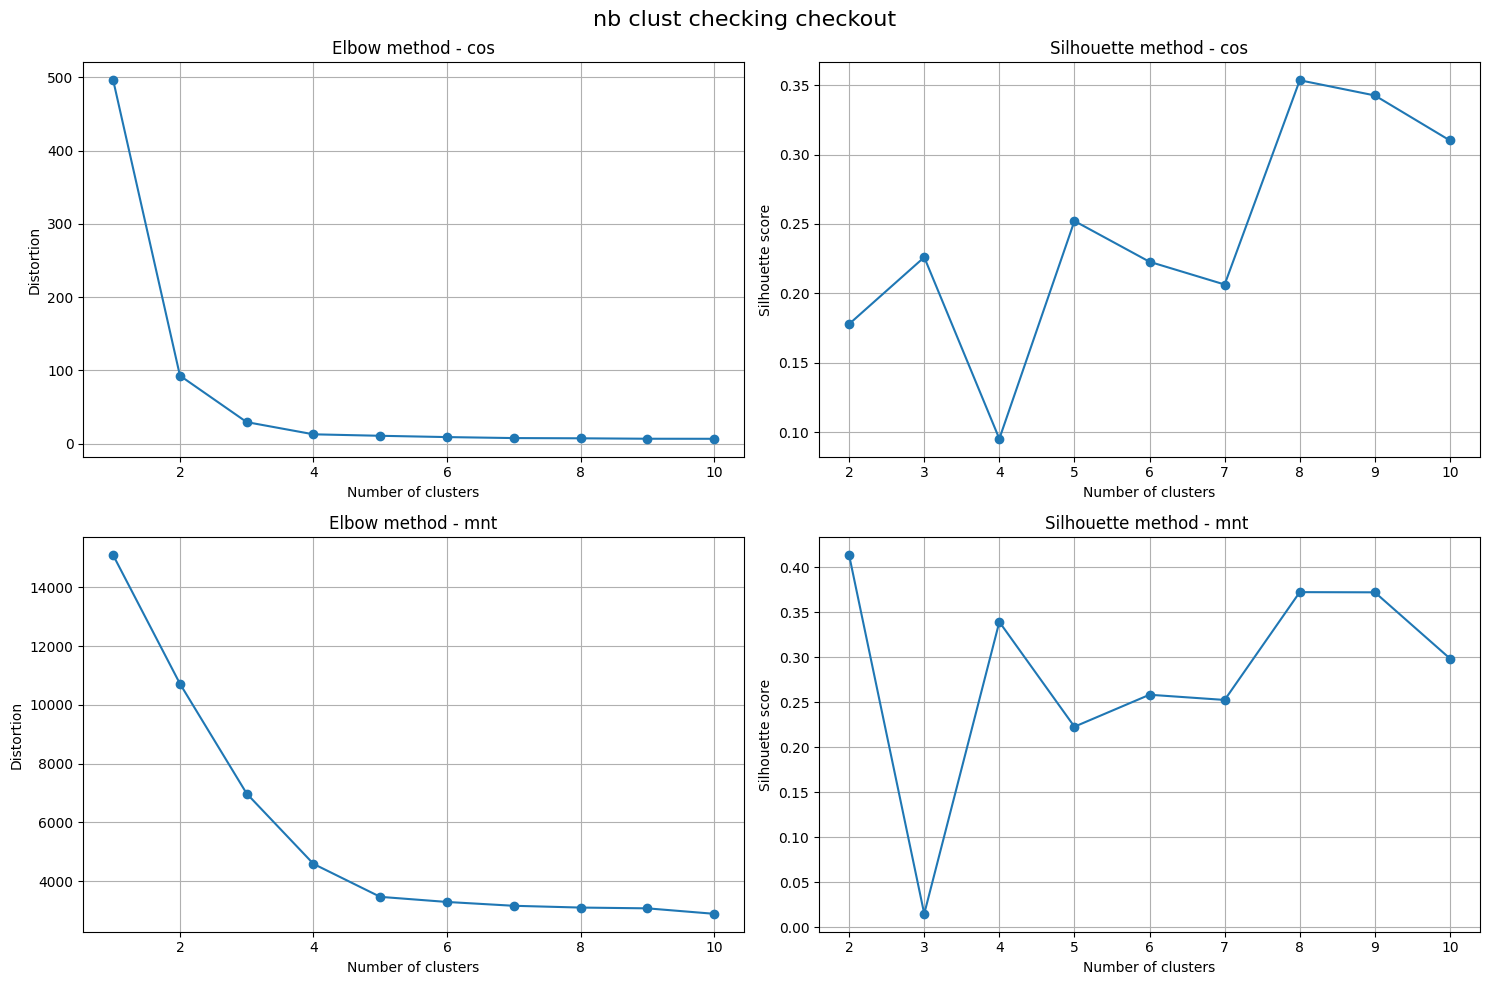

In [194]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Sphérical Kmean

In [195]:
skm = SphericalKmeans(
    n_clusters=5,
    n_init=10,
    tol=1e-4,
    max_iter=300
)

In [196]:
t0 = time()
skm.fit(w2v_umap_emb_irnd)
t = time() - t0

 == New init == 
iteration: 0
1752.2671880621751
iteration: 1
2146.0580842920135
iteration: 2
2210.7805392866035
iteration: 3
2212.886070923387
iteration: 4
2213.181980615253
iteration: 5
2213.402632567659
iteration: 6
2213.7077618026665
iteration: 7
2213.9478631689526
iteration: 8
2214.0560001516483
iteration: 9
2214.102154927686
iteration: 10
2214.1280690950553
iteration: 11
2214.170762410289
iteration: 12
2214.2257351018293
iteration: 13
2214.265698861217
iteration: 14
2214.277981035339
iteration: 15
2214.2801752331884
iteration: 16
2214.2818080441584
iteration: 17
2214.282675868052
iteration: 18
2214.284944216127
iteration: 19
2214.2876062503783
iteration: 20
2214.2904949800645
iteration: 21
2214.2916836672784
iteration: 22
2214.292470730778
iteration: 23
2214.2949822475352
iteration: 24
2214.2997401743796
iteration: 25
2214.307485518515
iteration: 26
2214.3234507846764
iteration: 27
2214.360851119854
iteration: 28
2214.431201169956
iteration: 29
2214.500402946709
iteration: 30
221

In [197]:
skm_labels = skm.labels_

In [198]:
evaluate_red(
    labels_= skm_labels, # label
    X= w2v_umap_emb_irnd, # matrix original
    name="skm _ rnd",
    metric=None,
    dset="bbc-rnd-red-w2v",
    train_times=t
)

Homogeneity: 0.803 ± 0.081
Completeness: 0.805 ± 0.075
V-measure: 0.804 ± 0.078
Rand index: 0.939 ± 0.037
ARI: 0.814 ± 0.110
MI: 1.286 ± 0.129
NMI: 0.804 ± 0.078
Silhouette Coefficient: 0.603 ± 0.111


In [199]:
space = [
    ('org', "Origin", topic_colors),
    ('skm', "skm (color just means cluster discovered)", skm_labels)
]

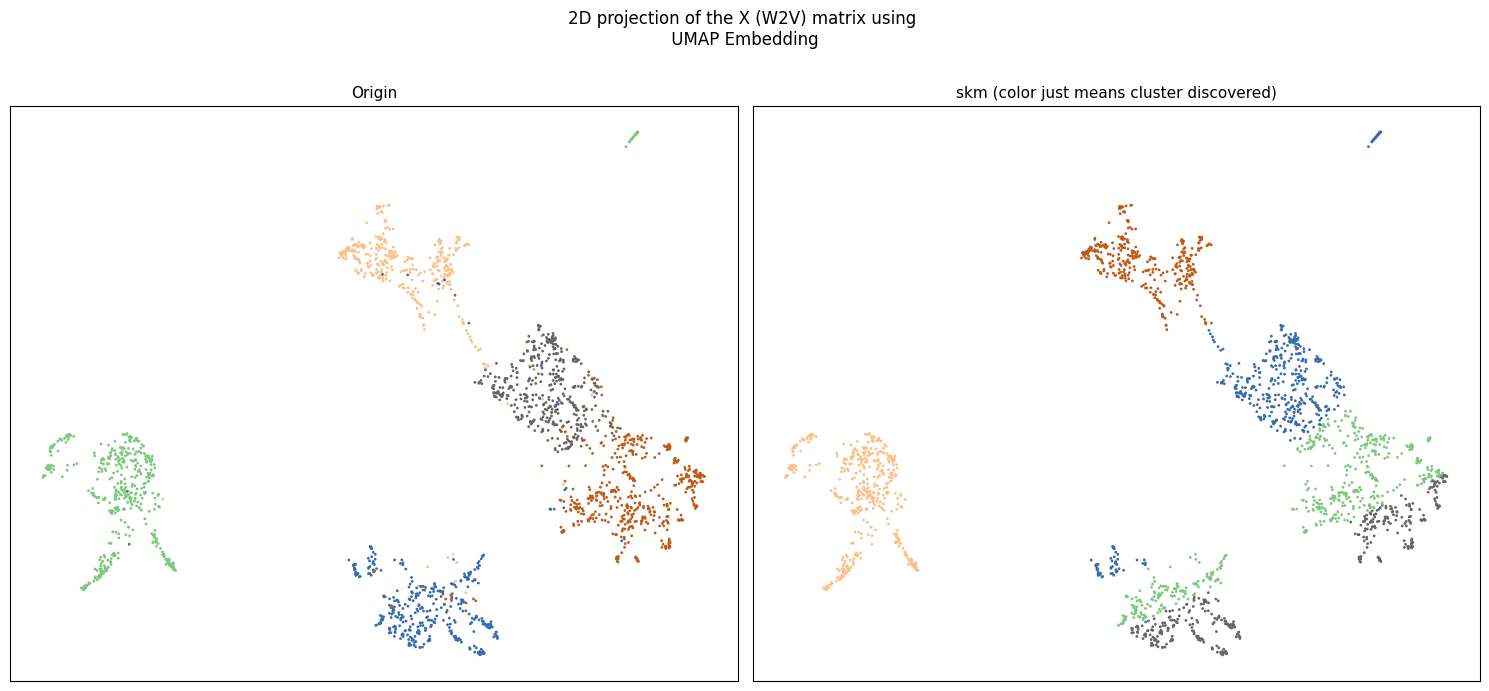

In [200]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, sp in zip(axs.flat, space):
    tag, name, cmap = sp

    # select reduction umap method
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("bbc_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

#### >> >> >>  CAH

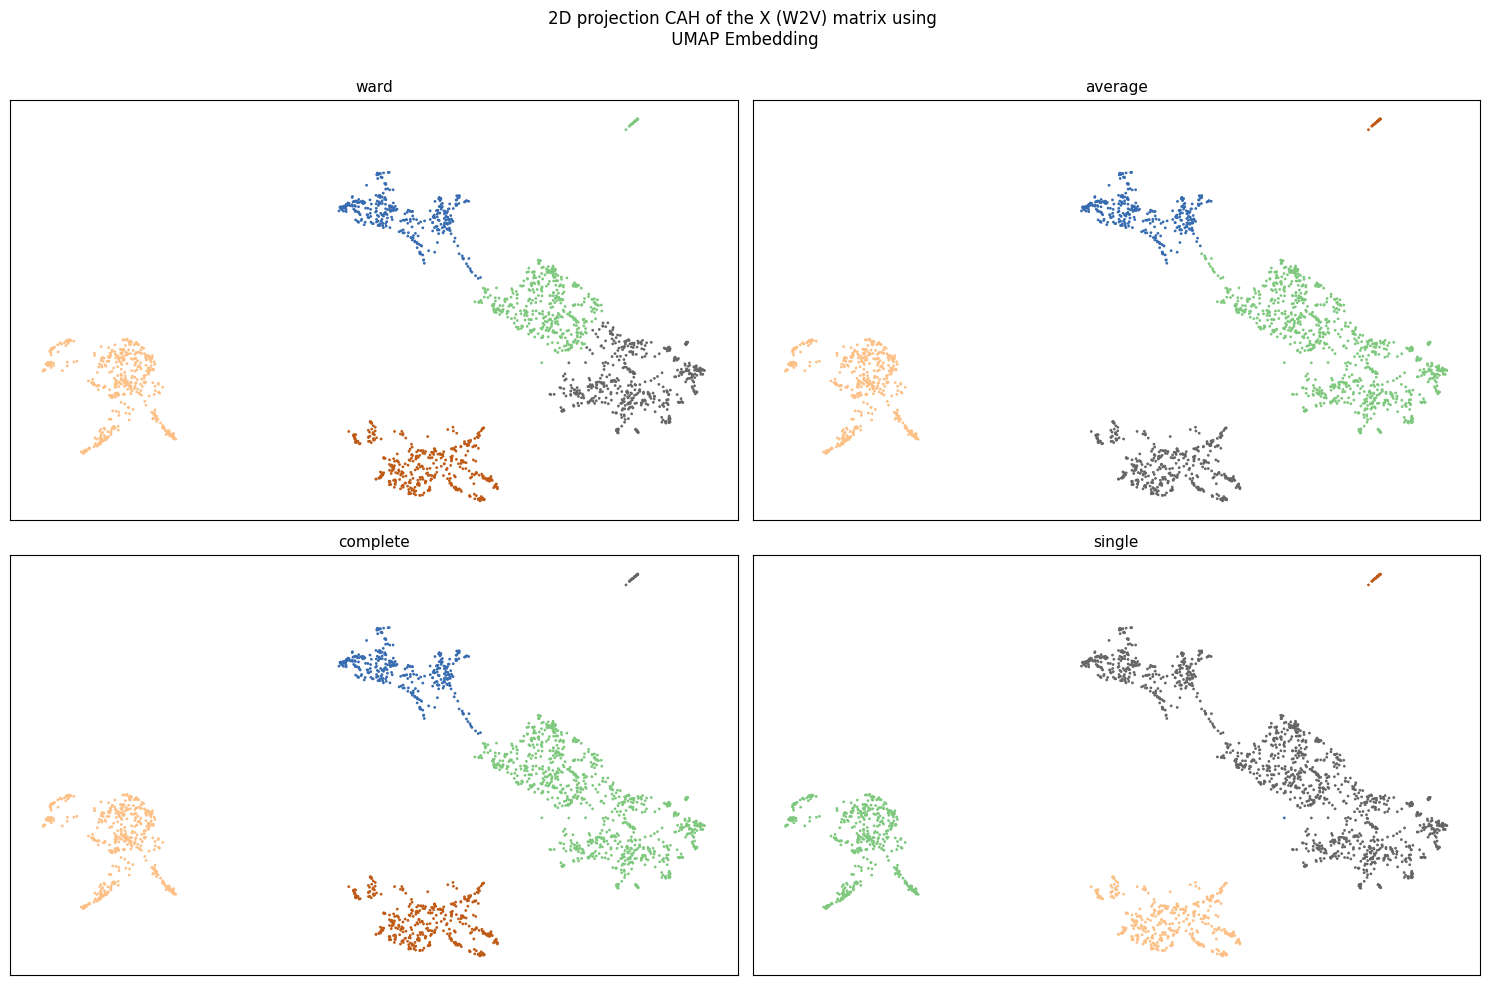

In [201]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection CAH of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, lk in zip(axs.flat, linkage):

    # select reduction umap method for plotting
    X_red = w2v_umap_emb_irnd if umap_init == 'random' else w2v_umap_emb_ispt

    clustering = AgglomerativeClustering(linkage=lk, n_clusters=5)
    clustering.fit(w2v_umap_emb_irnd)

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=clustering.labels_,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(f'{lk}', size=11)
save_fig("bbc_CAH_CLUSTERING_VARIOUS_LINKAGE_2Dplot")
plt.show()

In [202]:
cah_ward_per_k = [AgglomerativeClustering(linkage="ward", n_clusters=k).fit(w2v_umap_emb_irnd) for k in range(1, 11)]


In [203]:
silhouette_scores_cah_ward = [metrics.silhouette_score(w2v_umap_emb_irnd, model.labels_) for model in cah_ward_per_k[1:]]


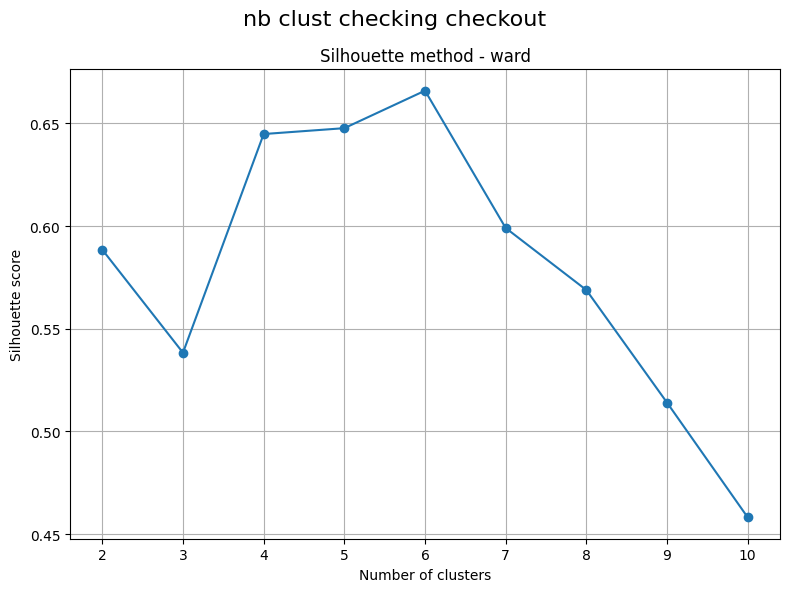

In [204]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("nb clust checking checkout", size=16)

plot = ax.plot(range(2,11), silhouette_scores_cah_ward, marker='o')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette method - ward", size=12)
ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [205]:
cah_ward_per_linkage_k5 = [AgglomerativeClustering(linkage=lk, n_clusters=5).fit(w2v_umap_emb_irnd) for lk in linkage]

In [206]:
t0 = time()
cah_single = AgglomerativeClustering(linkage="single", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-single", metric=None, dset="bbc-rnd-red-w2v", train_times=t)

Homogeneity: 0.794 ± 0.092
Completeness: 0.806 ± 0.074
V-measure: 0.799 ± 0.081
Rand index: 0.933 ± 0.049
ARI: 0.802 ± 0.126
MI: 1.272 ± 0.148
NMI: 0.799 ± 0.081
Silhouette Coefficient: 0.589 ± 0.133


In [207]:
t0 = time()
AgglomerativeClustering(linkage="average", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-average", metric=None, dset="bbc-rnd-red-w2v", train_times=t)

Homogeneity: 0.786 ± 0.101
Completeness: 0.807 ± 0.073
V-measure: 0.795 ± 0.084
Rand index: 0.928 ± 0.058
ARI: 0.792 ± 0.138
MI: 1.260 ± 0.162
NMI: 0.795 ± 0.084
Silhouette Coefficient: 0.587 ± 0.131


In [208]:
t0 = time()
AgglomerativeClustering(linkage="complete", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-complete", metric=None, dset="bbc-rnd-red-w2v", train_times=t)

Homogeneity: 0.779 ± 0.108
Completeness: 0.808 ± 0.073
V-measure: 0.791 ± 0.086
Rand index: 0.922 ± 0.064
ARI: 0.782 ± 0.147
MI: 1.248 ± 0.174
NMI: 0.791 ± 0.086
Silhouette Coefficient: 0.575 ± 0.147


In [209]:
t0 = time()
AgglomerativeClustering(linkage="ward", n_clusters=5).fit(w2v_umap_emb_irnd)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= w2v_umap_emb_irnd, name="cah-ward", metric=None, dset="bbc-rnd-red-w2v", train_times=t)

Homogeneity: 0.772 ± 0.114
Completeness: 0.809 ± 0.072
V-measure: 0.787 ± 0.088
Rand index: 0.917 ± 0.070
ARI: 0.772 ± 0.155
MI: 1.237 ± 0.183
NMI: 0.787 ± 0.088
Silhouette Coefficient: 0.563 ± 0.160


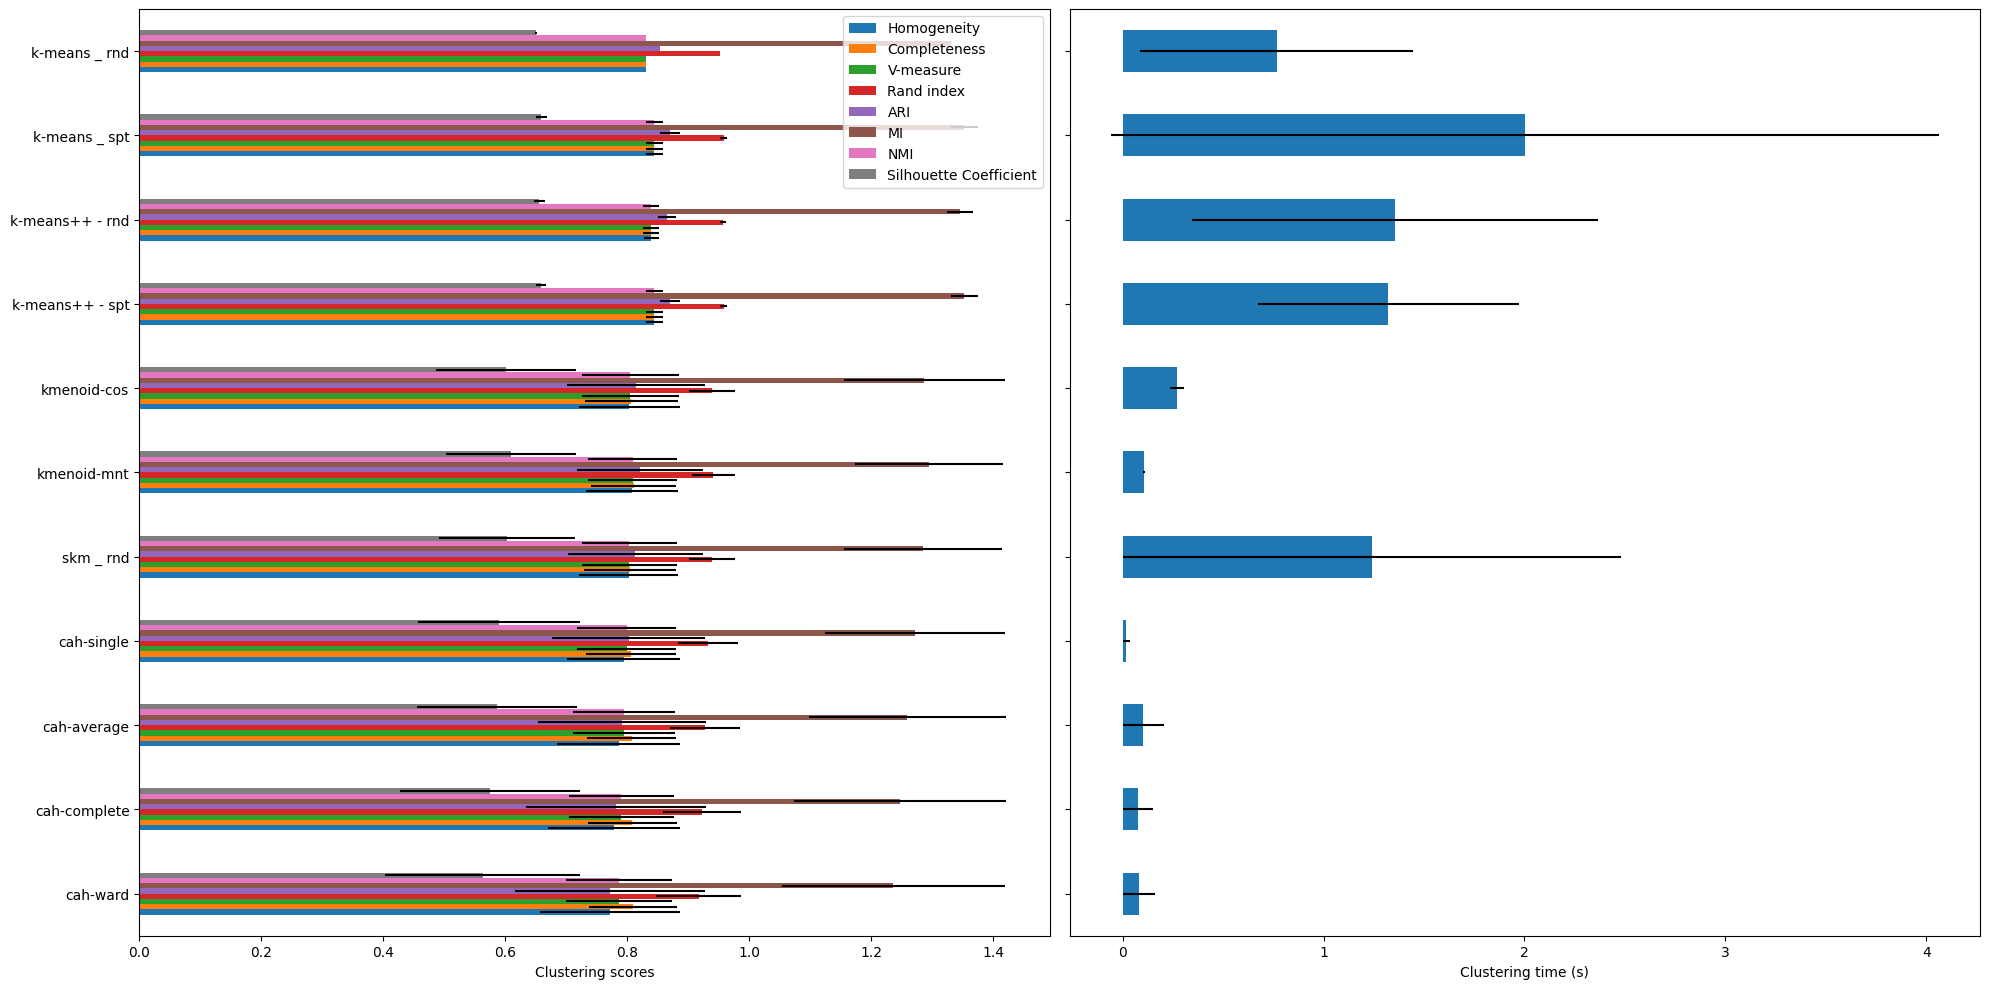

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

df = pd.DataFrame(evaluations_red[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_red_std[::-1]).set_index("estimator")

df.drop(
    ["train_time", "dset", "metric"], # we don't need plotting those (non--numeric)
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

In [211]:
df.head()

dset metric  train_time  Homogeneity  Completeness   
estimator                                                                     
cah-ward      bbc-rnd-red-w2v   None    0.081014     0.771853      0.809348  \
cah-complete  bbc-rnd-red-w2v   None    0.076503     0.778848      0.808387   
cah-average   bbc-rnd-red-w2v   None    0.102783     0.786267      0.807367   
cah-single    bbc-rnd-red-w2v   None    0.018414     0.794149      0.806284   
skm _ rnd     bbc-rnd-red-w2v   None    1.239465     0.802541      0.805131   

              V-measure  Rand index       ARI        MI       NMI   
estimator                                                           
cah-ward       0.786645    0.917496  0.772183  1.236543  0.786645  \
cah-complete   0.790559    0.922419  0.781641  1.247750  0.790559   
cah-average    0.794711    0.927640  0.791673  1.259635  0.794711   
cah-single     0.799122    0.933188  0.802331  1.272264  0.799122   
skm _ rnd      0.803818    0.939093  0.813677  1.285707  0.803818   

              Silhouette Coefficient  
estimator                             
cah-ward                    0.563438  
cah-complete                0.575073  
cah-average                 0.587323  
cah-single                  0.589338  
skm _ rnd                   0.602717

### >> <span style='color:#3390FF; font-weight: bold;'> PCA </span>

In [212]:
# réinitialisation
evaluations_red = []
evaluations_red_std = []
scores_red = defaultdict(list)

In [213]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / "bbc-red-pca"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

#### >> >> >>  Kmeans

In [214]:
km_w2v_pca_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='random',
    random_state=123
)

km_w2v_pca_red_fit = km_w2v_pca_red.fit(X_w2v_pca)
km_lab_w2v_pca_red = km_w2v_red.fit_predict(X_w2v_pca)

In [215]:
pca_methods = [
    ('o1', "PCA metric=cosine, init=random", X_w2v_pca, topic_colors),
    ('c1', "Check Clustering - PCA, init=random", X_w2v_pca, km_lab_w2v_pca_red)
]

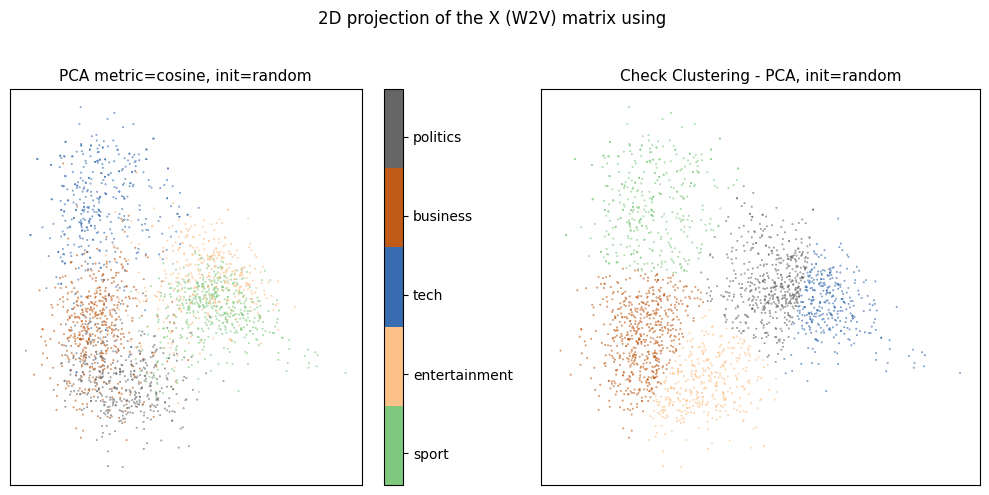

In [216]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("2D projection of the X (W2V) matrix using \n", size=12)

for ax, method in zip(axs.flat, pca_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("bbc_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_PCA_2Dplot")
plt.show()

In [217]:
# random reducted
fit_and_evaluate_red(
    km_w2v_pca_red, # model or estimator
    X_w2v_pca, # matrix original
    name="k-means _ pca",
    dset="bbc-w2v-pca-red"
)

clustering done in 3.51 ± 3.51 s 
Homogeneity: 0.492 ± 0.000
Completeness: 0.497 ± 0.000
V-measure: 0.495 ± 0.000
Rand index: 0.812 ± 0.000
ARI: 0.426 ± 0.001
MI: 0.789 ± 0.001
NMI: 0.495 ± 0.000
Silhouette Coefficient: 0.393 ± 0.001


In [218]:

print(f'Distortion: {km_w2v_pca_red_fit.inertia_:.2f}')

Distortion: 167.32


In [219]:
kmeans_pca_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='random',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(X_w2v_pca)
     for k in range(1, 11)]

In [220]:
inertias_pca = [model.inertia_ for model in kmeans_pca_per_k]

In [221]:
silhouette_scores_pca = [metrics.silhouette_score(X_w2v_pca, model.labels_)
                         for model in kmeans_pca_per_k[1:]]

In [222]:
nbcluster_choice_methods = [
    ("Elbow method - pca", range(1,11), inertias_pca, "Number of clusters", "Distortion"),
    ("Silhouette method - pca", range(2,11), silhouette_scores_pca, "Number of clusters", "Silhouette score"),
]

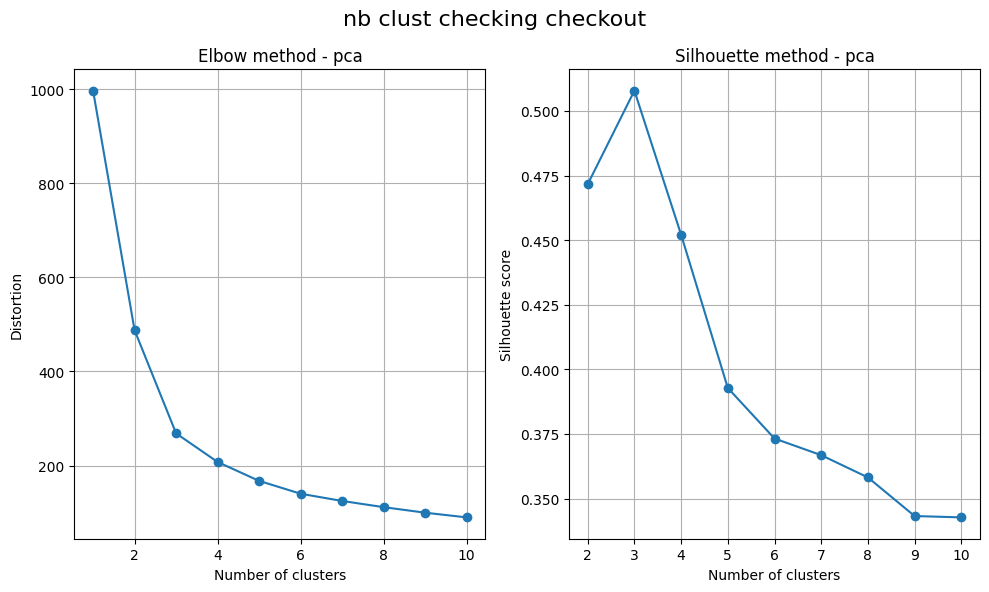

In [223]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Kmeans ++

In [224]:
kmpp_w2v_pca_red = cluster.KMeans(
    n_clusters=5,
    n_init=10,
    max_iter=300,
    tol=1e-04,
    init='k-means++',
    random_state=123
)

kmpp_w2v_pca_red_fit = kmpp_w2v_red.fit(X_w2v_pca)
kmpp_lab_w2v_pca_red = kmpp_w2v_red.fit_predict(X_w2v_pca)

In [225]:
umap_methods = [
    ('o1', "PCA, init=random", X_w2v_pca, topic_colors),
    ('c1', "Check Clustering - PCA, init=random", X_w2v_pca, kmpp_lab_w2v_pca_red),
]

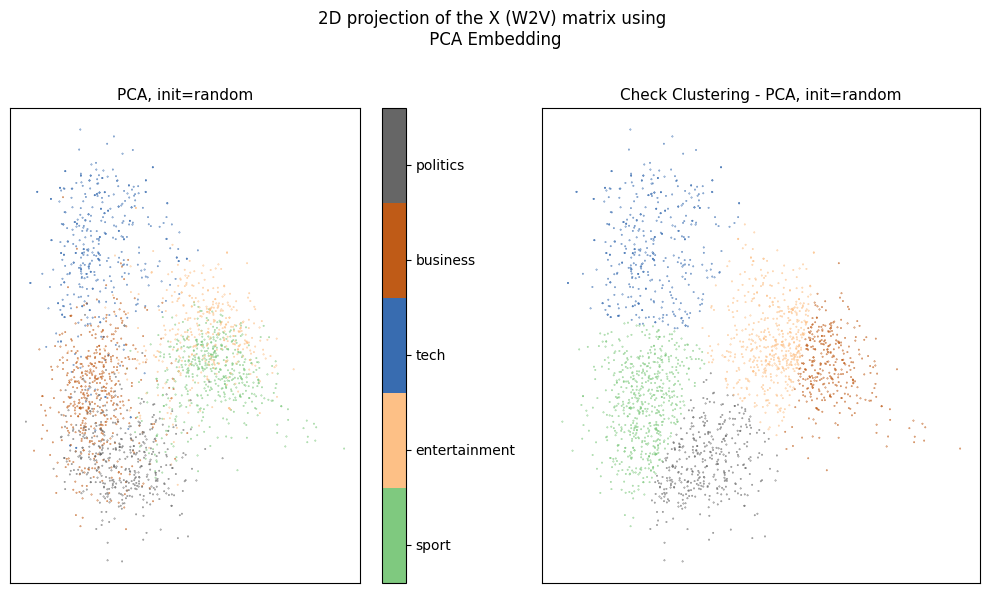

In [226]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
fig.suptitle("2D projection of the X (W2V) matrix using \n PCA Embedding \n", size=12)

for ax, method in zip(axs.flat, umap_methods):
    tag, name, X_red, cmap = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=0.1
    )

    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    if tag not in ['c1', 'c2']:
        cbar = fig.colorbar(scatter, ax=ax, boundaries=np.arange(6)-0.4)
        cbar.set_ticks(np.arange(5))
        cbar.set_ticklabels(classes, size=10)
    ax.set_title(name, size=11)
save_fig("bbc_W2V_ORIGNINAL_VS_KMEANS_CULSTERING_PCA_2Dplot")
plt.show()

In [227]:
fit_and_evaluate_red(
    kmpp_w2v_pca_red, # model or estimator
    X_w2v_pca, # matrix original
    name="k-means++ - pca",
    dset="bbc-w2v-pca-red"
)

clustering done in 1.93 ± 2.29 s 
Homogeneity: 0.492 ± 0.000
Completeness: 0.497 ± 0.000
V-measure: 0.495 ± 0.000
Rand index: 0.812 ± 0.000
ARI: 0.426 ± 0.000
MI: 0.789 ± 0.001
NMI: 0.495 ± 0.000
Silhouette Coefficient: 0.393 ± 0.002


In [228]:
# Pourcentage of variance or distortion
print(f'Distortion: {km_w2v_pca_red_fit.inertia_:.2f}')

Distortion: 167.32


In [229]:
kmeanspp_pca_per_k = \
    [cluster.KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        tol=1e-04,
        max_iter=300,
        random_state=0
    ).fit(X_w2v_pca)
     for k in range(1, 11)]

In [230]:
inertias_pca = [model.inertia_ for model in kmeanspp_pca_per_k]
silhouette_scores_pca = [metrics.silhouette_score(X_w2v_pca, model.labels_) for model in kmeanspp_pca_per_k[1:]]

In [231]:
nbcluster_choice_methods = [
    ("Elbow method - rnd", range(1,11), inertias_pca, "Number of clusters", "Distortion"),
    ("Silhouette method -spt", range(2,11), silhouette_scores_pca, "Number of clusters", "Silhouette score")
]

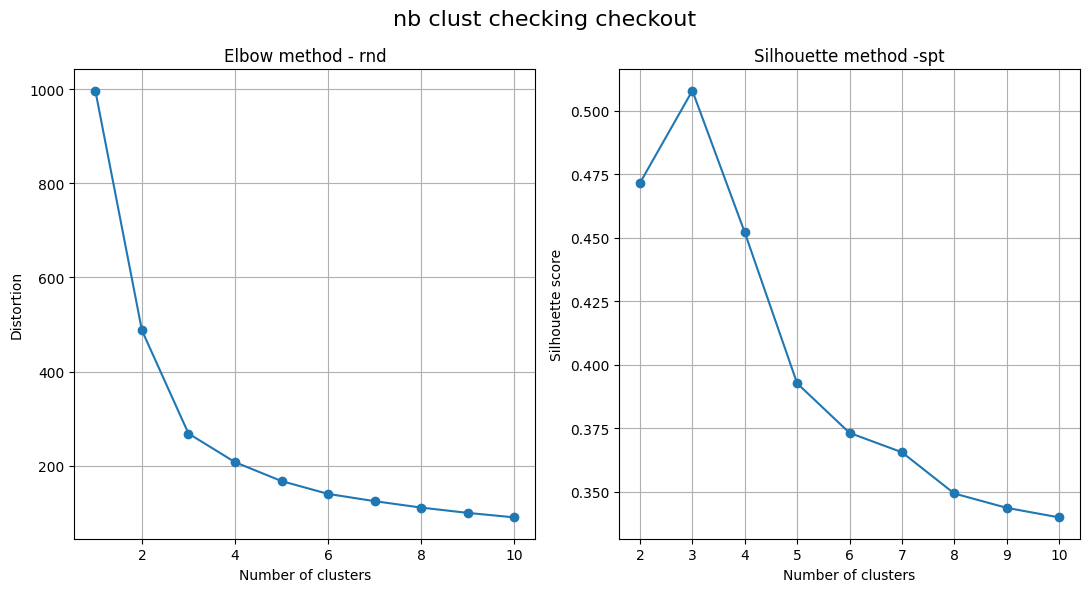

In [232]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Kmedoids

In [233]:
kmd_w2v_red_cos = KMedoids(
    metric="cosine",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

kmd_w2v_red_mnt = KMedoids(
    metric="manhattan",
    n_clusters=5,
    random_state=123,
    max_iter=300
)

clr_w2v_red_cos = CLARA(
    metric="cosine",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clr_w2v_red_mnt = CLARA(
    metric="manhattan",
    n_clusters=5,
    init="heuristic",
    n_sampling=250,
    random_state=123
)

clustering_algorithms_metrics = [
    ('kcos', "K-Medoid metric=cosine \n PCA, init=random", kmd_w2v_red_cos),
    ('kmnt', "K-Medoid metric=manathan \n PCA, init=random", kmd_w2v_red_mnt),
    ('rcos', "CLARA metric=cosine \n PCA, init=random", clr_w2v_red_cos),
    ('rmnt', "CLARA metric=manathan \nPCA, init=spectral", clr_w2v_red_mnt),
]

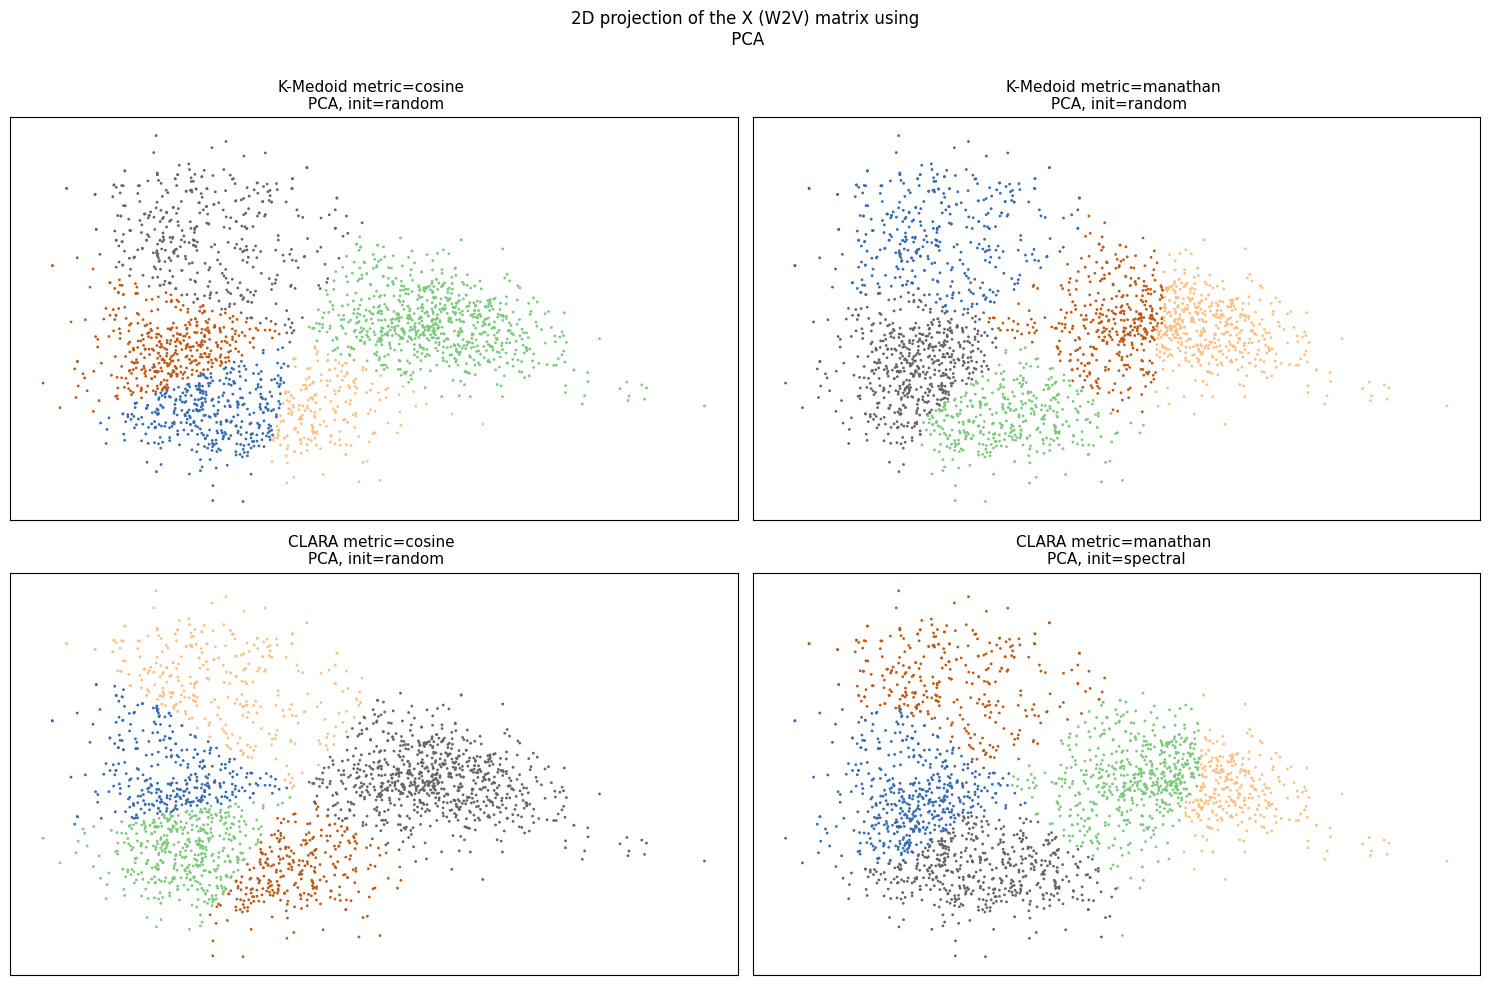

In [234]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection of the X (W2V) matrix using\n PCA\n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, algorithm in zip(axs.flat, clustering_algorithms_metrics):
    tag, name, model = algorithm

    # on entraine les modèles
    model.fit(X_w2v_pca)

    # dépendamment de l'implémentation, on peut avoir des attributs labels_ ou non
    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(X_w2v_pca)

    # select reduction umap method for plotting
    X_red = X_w2v_pca

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=y_pred,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("bbc_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

In [235]:
fit_and_evaluate_red(
    kmd_w2v_red_cos, # model
    X_w2v_pca, # matrix original
    name="kmenoid-cos",
    metric="cosine",
    dset="bbc-w2v-pca-red"
)

clustering done in 0.66 ± 0.22 s 
Homogeneity: 0.494 ± 0.002
Completeness: 0.506 ± 0.012
V-measure: 0.500 ± 0.007
Rand index: 0.811 ± 0.001
ARI: 0.432 ± 0.009
MI: 0.791 ± 0.003
NMI: 0.500 ± 0.007
Silhouette Coefficient: 0.390 ± 0.004


In [236]:
# Pourcentage of variance or distortion
print(f'Distortion: {kmd_w2v_red_cos.inertia_:.2f}')

Distortion: 107.05


In [237]:
kmd_pca_red_cos_per_k = \
    [KMedoids(
        metric="cosine",
        n_clusters=k,
        random_state=123,
        max_iter=300
    ).fit(X_w2v_pca)
     for k in range(1, 11)]

In [238]:
inertias_kmd_cos = [model.inertia_ for model in kmd_pca_red_cos_per_k]

In [239]:
silhouette_scores_cos = [metrics.silhouette_score(X_w2v_pca, model.labels_)
                         for model in kmd_pca_red_cos_per_k[1:]]

###### $\rightarrow$ Silhouette method to Estimate number of clusters needs


In [240]:
nbcluster_choice_methods = [
    ("Elbow method - cos", range(1,11), inertias_kmd_cos, "Number of clusters", "Distortion"),
    ("Silhouette method - cos", range(2,11), silhouette_scores_cos, "Number of clusters", "Silhouette score"),
]

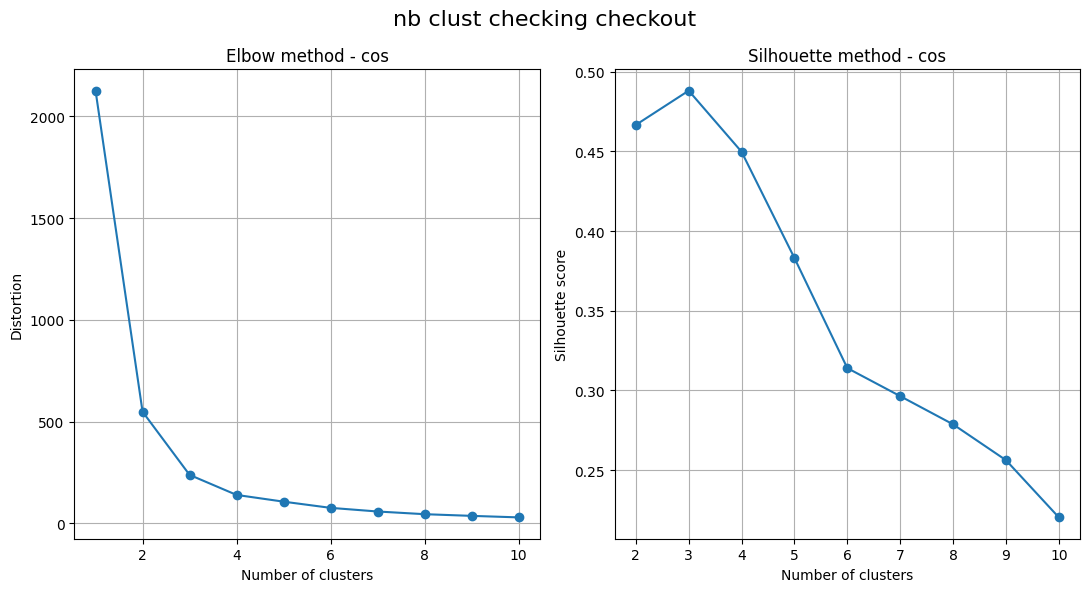

In [241]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
fig.suptitle("nb clust checking checkout", size=16)

for ax, nbclust in zip(axs.flat, nbcluster_choice_methods):
    name, x, inertias, xlab, ylab = nbclust
    plot = ax.plot(x, inertias, marker='o')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(name, size=12)
    ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

#### >> >> >>  Sphérical Kmean

In [242]:
skm = SphericalKmeans(
    n_clusters=5,
    n_init=10,
    tol=1e-4,
    max_iter=300
)

In [243]:
t0 = time()
skm.fit(X_w2v_pca)
t = time() - t0

 == New init == 
iteration: 0
1276.8422362218544
iteration: 1
2054.2622059238147
iteration: 2
2099.2583552994415
iteration: 3
2112.7061311111565
iteration: 4
2115.5113265094346
iteration: 5
2116.079861379554
iteration: 6
2116.4288232851713
iteration: 7
2116.885077975313
iteration: 8
2117.2701511020823
iteration: 9
2117.460343625181
iteration: 10
2117.562648396269
iteration: 11
2117.6800167805427
iteration: 12
2117.744277226383
iteration: 13
2117.839126700121
iteration: 14
2117.907608322992
iteration: 15
2117.950591361215
iteration: 16
2117.957830852264
iteration: 17
2117.9610677355313
iteration: 18
2117.9619273815433
iteration: 19
 == New init == 
iteration: 0
1258.5003133736852
iteration: 1
2043.7432652673338
iteration: 2
2086.2226969128387
iteration: 3
2103.9525912641193
iteration: 4
2111.0640426533555
iteration: 5
2113.38428356274
iteration: 6
2114.378877740497
iteration: 7
2114.8465493923322
iteration: 8
2115.1276208200634
iteration: 9
2115.3362130388973
iteration: 10
2115.42560763

In [244]:
skm_labels = skm.labels_

In [245]:
evaluate_red(
    labels_= skm_labels, # label
    X= X_w2v_pca, # matrix original
    name="skm _ rnd",
    metric=None,
    dset="bbc-pca-red-w2v",
    train_times=t
)

Homogeneity: 0.494 ± 0.002
Completeness: 0.507 ± 0.012
V-measure: 0.500 ± 0.007
Rand index: 0.811 ± 0.001
ARI: 0.433 ± 0.010
MI: 0.791 ± 0.003
NMI: 0.500 ± 0.007
Silhouette Coefficient: 0.390 ± 0.004


In [246]:
space = [
    ('org', "Origin", topic_colors),
    ('skm', "skm (color just means cluster discovered)", skm_labels)
]

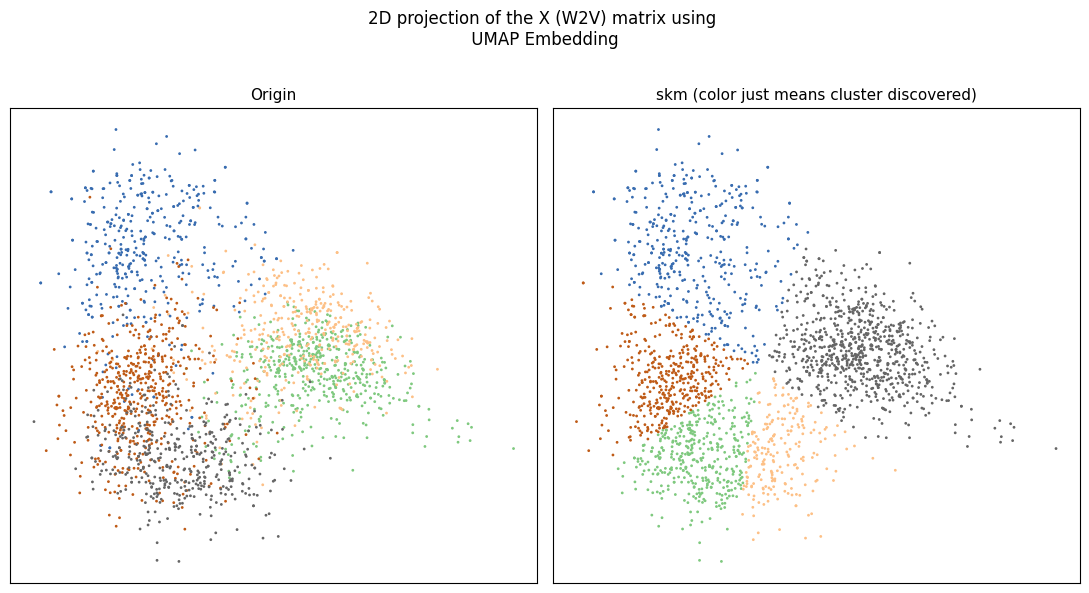

In [247]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))
fig.suptitle("2D projection of the X (W2V) matrix using \n UMAP Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, sp in zip(axs.flat, space):
    tag, name, cmap = sp

    # select reduction umap method
    X_red = X_w2v_pca

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=cmap,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(name, size=11)
save_fig("bbc_KMENOID_VS_CLARA_RANDOM_INIT_CLUSTERING_2Dplot")
plt.show()

#### >> >> >>  CAH

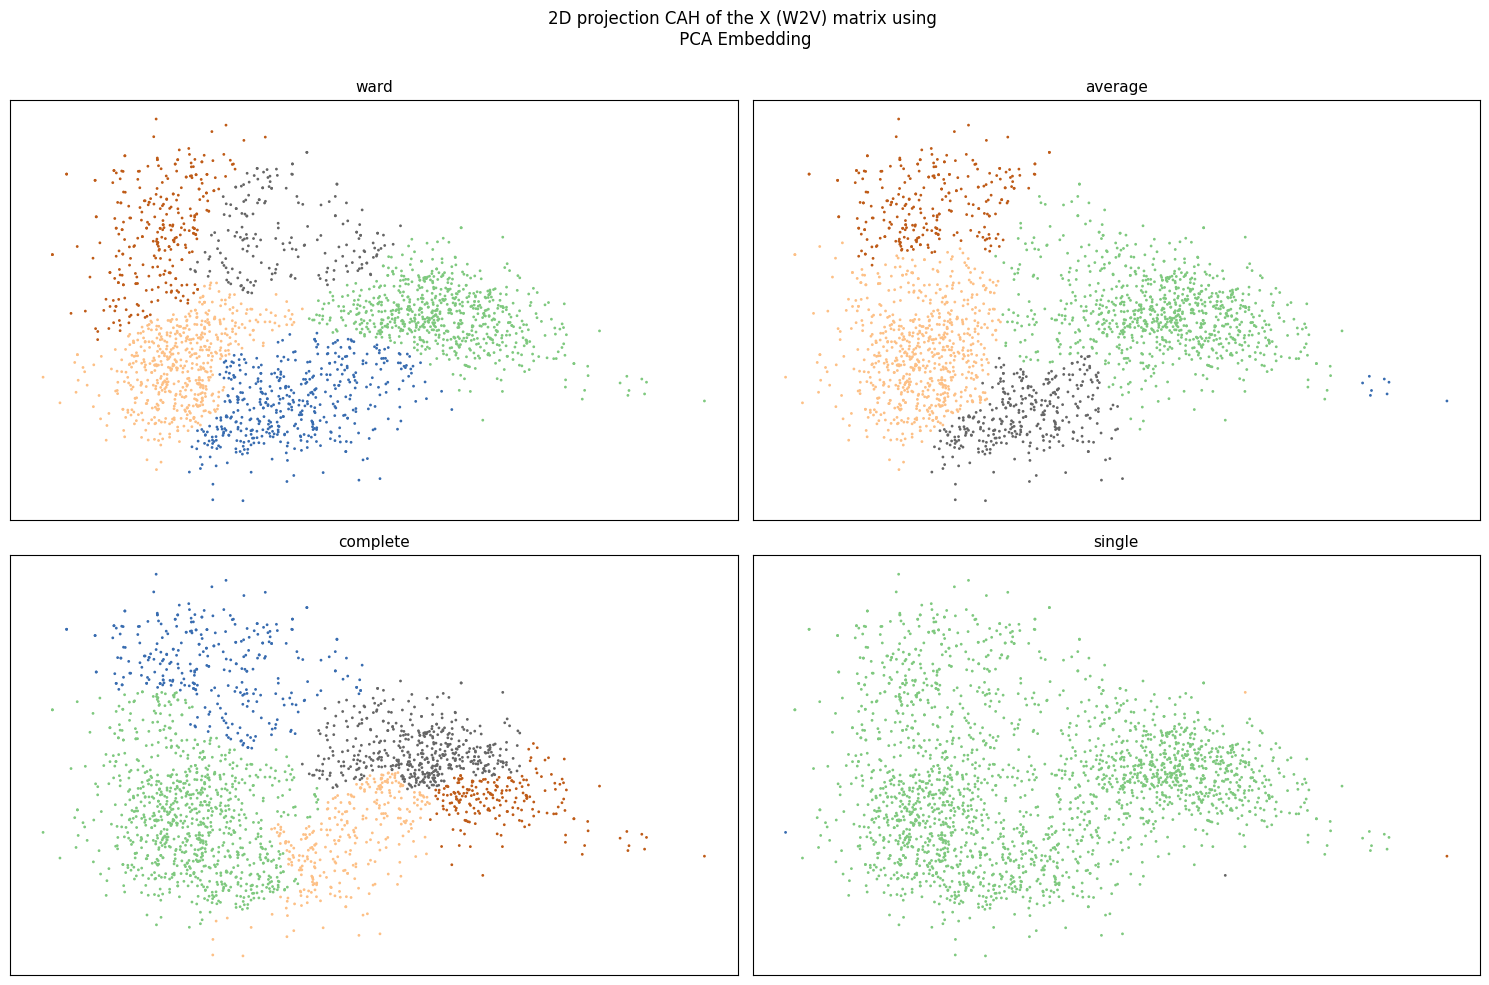

In [248]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("2D projection CAH of the X (W2V) matrix using \n PCA Embedding \n", size=12)

umap_init = 'random' #  ou 'spectral'
for ax, lk in zip(axs.flat, linkage):

    # select reduction umap method for plotting
    X_red = X_w2v_pca

    clustering = AgglomerativeClustering(linkage=lk, n_clusters=5)
    clustering.fit(X_w2v_pca)

    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=clustering.labels_,
        cmap='Accent',
        s=1
    )
    plt.setp(ax, xticks=[], yticks=[])

    # no need color bar caused we performed unsupervised clustering
    # Let's kmeans discover cluster. So no need color bar when view clusters
    ax.set_title(f'{lk}', size=11)
save_fig("bbc_CAH_CLUSTERING_VARIOUS_LINKAGE_2Dplot")
plt.show()

In [249]:
cah_ward_per_k = [AgglomerativeClustering(linkage="ward", n_clusters=k).fit(X_w2v_pca) for k in range(1, 11)]

In [250]:
silhouette_scores_cah_ward = [metrics.silhouette_score(X_w2v_pca, model.labels_) for model in cah_ward_per_k[1:]]

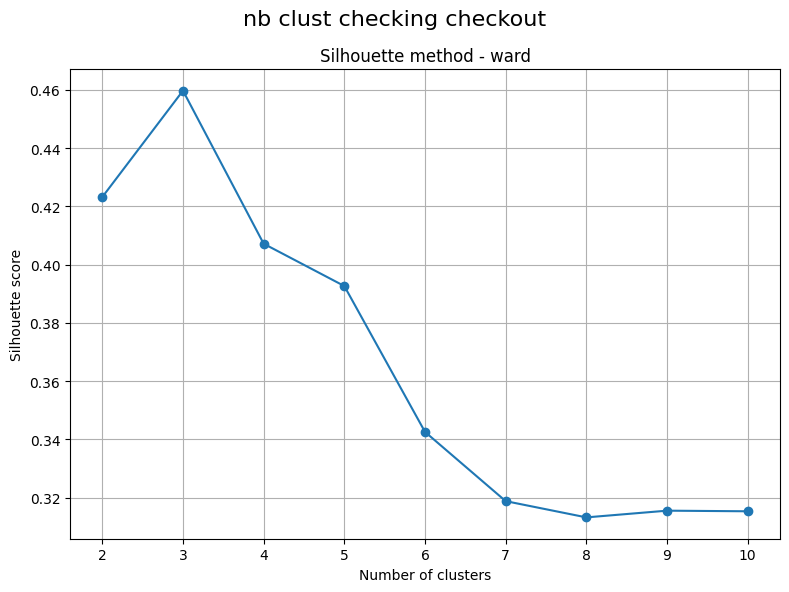

In [251]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("nb clust checking checkout", size=16)

plot = ax.plot(range(2,11), silhouette_scores_cah_ward, marker='o')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette method - ward", size=12)
ax.grid()
plt.tight_layout()
save_fig("bbc_W2V_KMENOID_BEST_NB_CLUST_SILHOUETTE_SCORE_Line_plot")
plt.show()

In [252]:
cah_ward_per_linkage_k5 = [AgglomerativeClustering(linkage=lk, n_clusters=5).fit(X_w2v_pca) for lk in linkage]

In [253]:
t0 = time()
cah_single = AgglomerativeClustering(linkage="single", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-single", metric=None, dset="bbc-pca-red-w2v", train_times=t)

Homogeneity: 0.465 ± 0.116
Completeness: 0.488 ± 0.077
V-measure: 0.471 ± 0.117
Rand index: 0.776 ± 0.143
ARI: 0.408 ± 0.102
MI: 0.745 ± 0.185
NMI: 0.471 ± 0.117
Silhouette Coefficient: 0.357 ± 0.129


In [254]:
t0 = time()
AgglomerativeClustering(linkage="average", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-average", metric=None, dset="bbc-pca-red-w2v", train_times=t)

Homogeneity: 0.439 ± 0.155
Completeness: 0.471 ± 0.102
V-measure: 0.445 ± 0.156
Rand index: 0.744 ± 0.191
ARI: 0.385 ± 0.136
MI: 0.703 ± 0.248
NMI: 0.445 ± 0.156
Silhouette Coefficient: 0.345 ± 0.136


In [255]:
t0 = time()
AgglomerativeClustering(linkage="complete", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-complete", metric=None, dset="bbc-pca-red-w2v", train_times=t)


Homogeneity: 0.416 ± 0.179
Completeness: 0.456 ± 0.119
V-measure: 0.422 ± 0.181
Rand index: 0.715 ± 0.221
ARI: 0.365 ± 0.158
MI: 0.667 ± 0.287
NMI: 0.422 ± 0.181
Silhouette Coefficient: 0.318 ± 0.174


In [256]:
t0 = time()
AgglomerativeClustering(linkage="ward", n_clusters=5).fit(X_w2v_pca)
t = time() - t0
evaluate_red(labels_= cah_single.labels_, X= X_w2v_pca, name="cah-ward", metric=None, dset="bbc-pca-red-w2v", train_times=t)


Homogeneity: 0.395 ± 0.197
Completeness: 0.442 ± 0.130
V-measure: 0.401 ± 0.199
Rand index: 0.690 ± 0.243
ARI: 0.347 ± 0.174
MI: 0.633 ± 0.315
NMI: 0.401 ± 0.199
Silhouette Coefficient: 0.295 ± 0.198


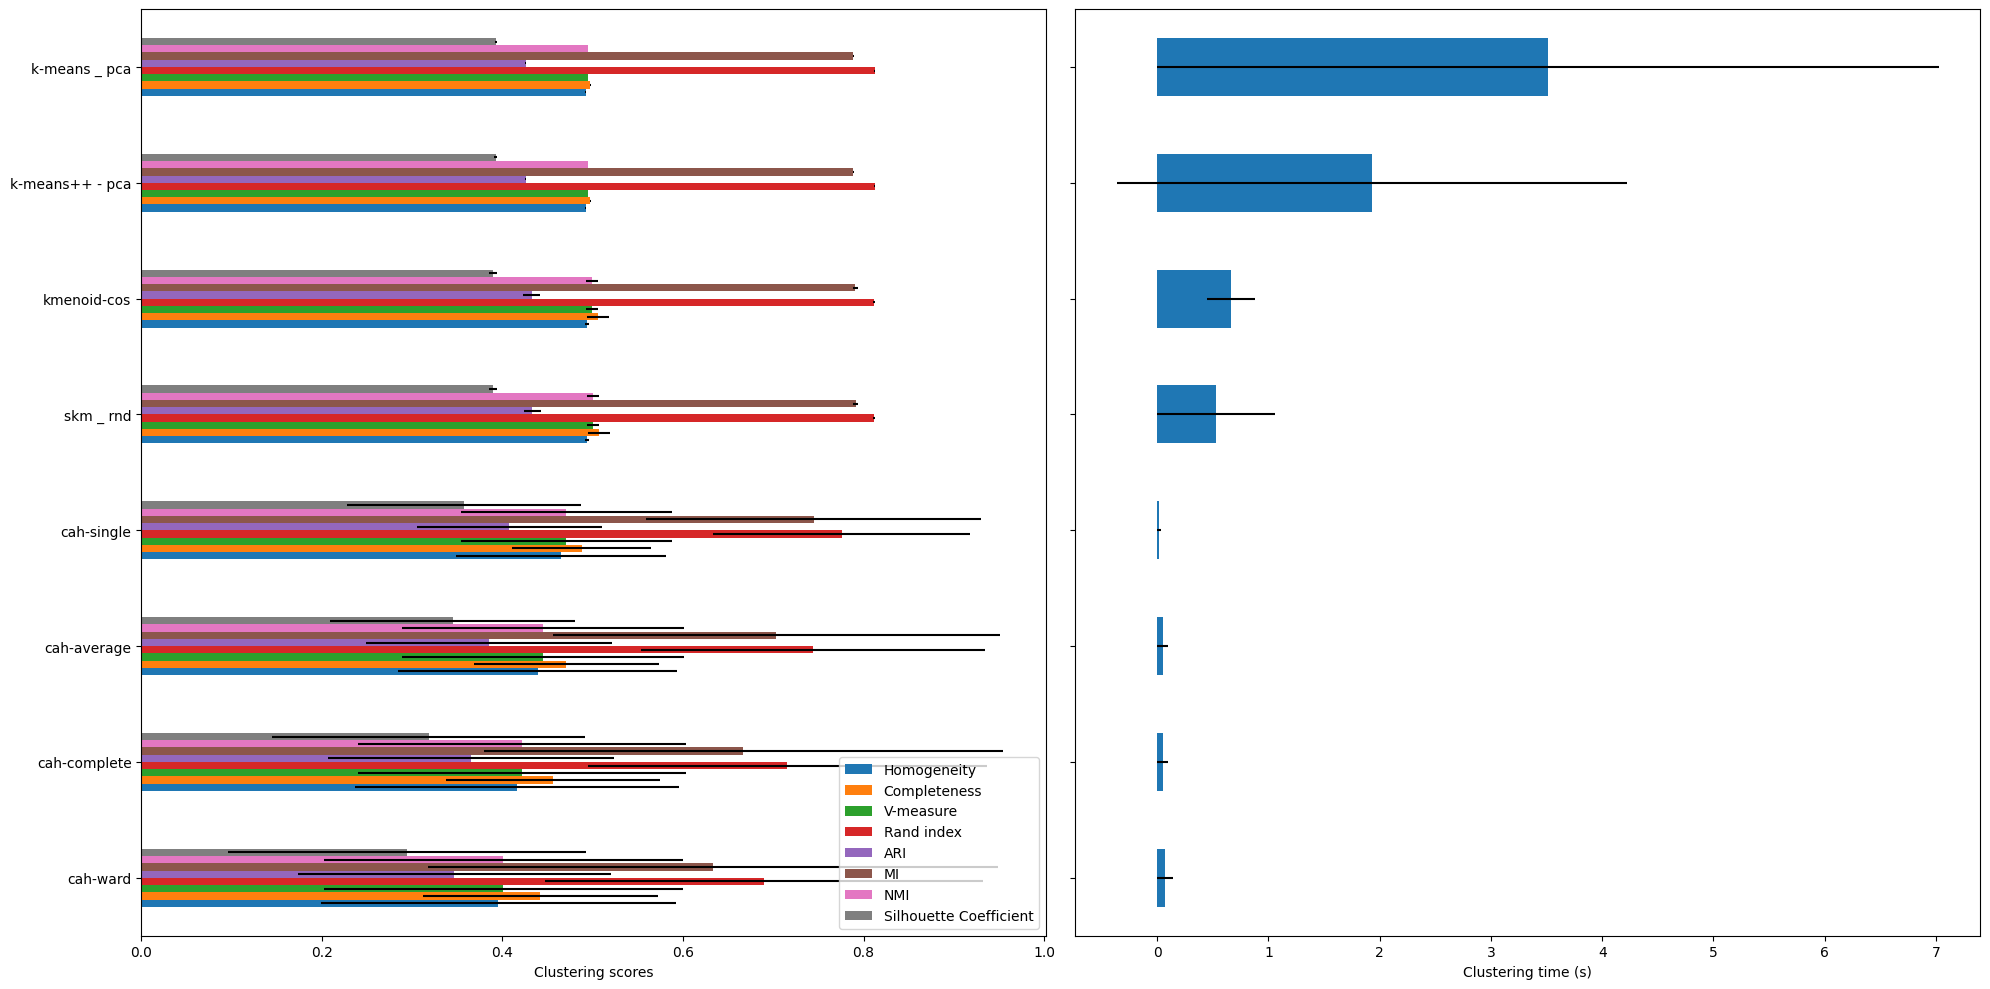

In [257]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)

df = pd.DataFrame(evaluations_red[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_red_std[::-1]).set_index("estimator")

df.drop(
    ["train_time", "dset", "metric"], # we don't need plotting those (non--numeric)
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

### >> <span style='color:#3390FF; font-weight: bold;'> t-SNE</span>

In [258]:
# reinitialise
evaluations_red_std = []
scores_red = defaultdict(list)

In [259]:
IMAGES_PATH = Path.cwd().parent.parent / "images" / "unsupervised_learning" / "bbc-red-tse"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

#### >> >> >>  Kmeans